In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率

                    Buy = current_price + Buy_trade_fee #買入成本 = 今天收盤 + 買入手續費
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax #賣出成本 = 明天開盤 - 賣出手續費 - 證交稅


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）
                
                
                
                
                elif(action == Actions.Sell.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率

                    Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                    Sold = current_price - Sold_trade_fee - Transfer_tax #賣出成本 = 今天收盤 - 賣出手續費 - 證交稅    

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0             
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000          

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = current_price + Buy_trade_fee#買入的成本
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    long_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = last_trade_price + Buy_trade_fee#買入的成本
                    Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    short_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('2603.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2603.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2000-01-31,32.259,32.685,31.939,32.152,16.318,16352913.000,2603.TW,28.745,32.685,...,62.667,71.029,56.480,0.487,0.309,31.776,29.970,28.164,1,0
1,2000-02-01,32.472,32.472,31.513,31.726,16.102,10636015.000,2603.TW,28.745,32.685,...,62.667,72.578,61.846,0.561,0.360,31.987,30.119,28.250,0,1
2,2000-02-02,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,28.958,32.685,...,57.576,73.147,65.613,0.613,0.410,32.107,30.284,28.460,0,1
3,2000-02-03,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,29.384,32.685,...,63.333,72.421,67.882,0.646,0.458,32.263,30.411,28.560,0,1
4,2000-02-04,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,29.491,32.685,...,65.517,71.614,69.126,0.665,0.499,32.348,30.438,28.528,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,2023-02-23,153.500,158.500,153.500,158.000,158.000,34299954.000,2603.TW,142.500,158.500,...,59.459,74.173,55.450,-0.771,-1.805,158.279,150.800,143.321,1,0
5757,2023-02-24,158.500,159.500,155.500,157.000,157.000,32154792.000,2603.TW,145.000,159.500,...,57.333,77.035,62.645,-0.258,-1.495,158.953,151.025,143.097,1,0
5758,2023-03-01,157.500,158.000,154.000,156.000,156.000,21240175.000,2603.TW,145.000,159.500,...,58.108,76.644,67.311,0.068,-1.183,159.512,151.300,143.088,0,1
5759,2023-03-02,158.000,161.000,157.500,160.500,160.500,33776976.000,2603.TW,145.000,161.000,...,67.532,83.388,72.670,0.680,-0.810,160.865,151.725,142.585,1,0


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4993

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5726

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
4993,2020-01-02,31.500,32.000,31.500,31.750,25.206,5983333.000,2603.TW,31.000,32.000,...,60.870,47.231,47.813,0.037,-0.025,31.775,31.075,30.375,1,0
4994,2020-01-03,32.000,32.625,31.875,32.500,25.802,13275073.000,2603.TW,31.000,32.625,...,67.857,62.257,52.628,0.133,0.006,32.085,31.156,30.228,1,0
4995,2020-01-06,32.500,33.000,32.250,32.500,25.802,10429668.000,2603.TW,31.000,33.000,...,64.000,66.505,57.253,0.207,0.046,32.314,31.250,30.186,1,0
4996,2020-01-07,32.500,32.625,32.125,32.250,25.603,5552326.000,2603.TW,31.000,33.000,...,66.667,65.170,59.892,0.242,0.086,32.428,31.337,30.247,0,1
4997,2020-01-08,31.875,31.875,31.500,31.500,25.008,5703694.000,2603.TW,31.000,33.000,...,57.143,51.780,57.188,0.208,0.110,32.423,31.381,30.340,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722,2022-12-26,168.500,168.500,162.500,162.500,162.500,23661784.000,2603.TW,151.000,172.000,...,62.366,67.278,64.430,3.172,2.330,170.040,159.075,148.110,0,1
5723,2022-12-27,164.000,167.000,162.000,162.500,162.500,19106328.000,2603.TW,152.500,172.000,...,59.302,61.946,63.602,3.004,2.465,170.187,159.150,148.113,0,1
5724,2022-12-28,162.000,164.000,159.000,159.000,159.000,20189077.000,2603.TW,154.000,172.000,...,54.839,50.557,59.253,2.559,2.483,169.844,158.950,148.056,0,1
5725,2022-12-29,159.000,161.000,157.500,160.000,160.000,17346004.000,2603.TW,157.500,172.000,...,55.319,39.452,52.653,2.261,2.439,169.667,158.850,148.033,0,1


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['UpLine', 'DownLine']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 4.94e-05 |
| fps                | 3        |
| nupdates           | 1        |
| policy_entropy     | 0.693    |
| total_timesteps    | 5        |
| value_loss         | 1.14e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.89e-05 |
| fps                | 132       |
| nupdates           | 100       |
| policy_entropy     | 0.67      |
| total_timesteps    | 500       |
| value_loss         | 7.64e+06  |
----------------------------------
----------------------------------
| explained_variance 

---------------------------------
| explained_variance | 0.000702 |
| fps                | 191      |
| nupdates           | 1500     |
| policy_entropy     | 0.0535   |
| total_timesteps    | 7500     |
| value_loss         | 8.24e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.0021  |
| fps                | 189      |
| nupdates           | 1600     |
| policy_entropy     | 0.0383   |
| total_timesteps    | 8000     |
| value_loss         | 3.27e+08 |
---------------------------------
---------------------------------
| explained_variance | -4.3e-05 |
| fps                | 188      |
| nupdates           | 1700     |
| policy_entropy     | 0.00402  |
| total_timesteps    | 8500     |
| value_loss         | 4.89e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.00243 |
| fps                | 186      |
| nupdates           | 1800     |
| policy_entropy     | 0.0262   |
| total_timest

---------------------------------
| explained_variance | 0.0212   |
| fps                | 153      |
| nupdates           | 4500     |
| policy_entropy     | 0.00177  |
| total_timesteps    | 22500    |
| value_loss         | 1.99e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 152      |
| nupdates           | 4600     |
| policy_entropy     | 0.00529  |
| total_timesteps    | 23000    |
| value_loss         | 2.32e+07 |
---------------------------------
----------------------------------
| explained_variance | -0.000159 |
| fps                | 151       |
| nupdates           | 4700      |
| policy_entropy     | 0.00888   |
| total_timesteps    | 23500     |
| value_loss         | 7.57e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.000945 |
| fps                | 150      |
| nupdates           | 4800     |
| policy_entropy     | 0.00182  |
| tota

----------------------------------
| explained_variance | -1.73e-05 |
| fps                | 138       |
| nupdates           | 7500      |
| policy_entropy     | 0.0171    |
| total_timesteps    | 37500     |
| value_loss         | 2.55e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.0208   |
| fps                | 138      |
| nupdates           | 7600     |
| policy_entropy     | 0.00136  |
| total_timesteps    | 38000    |
| value_loss         | 2.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 138      |
| nupdates           | 7700     |
| policy_entropy     | 0.00229  |
| total_timesteps    | 38500    |
| value_loss         | 2.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.000117 |
| fps                | 138      |
| nupdates           | 7800     |
| policy_entropy     | 0.0145   |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 10500     |
| policy_entropy     | 0.318     |
| total_timesteps    | 52500     |
| value_loss         | 1.97e+07  |
----------------------------------
---------------------------------
| explained_variance | -0.136   |
| fps                | 134      |
| nupdates           | 10600    |
| policy_entropy     | 0.00971  |
| total_timesteps    | 53000    |
| value_loss         | 6.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00249  |
| fps                | 134      |
| nupdates           | 10700    |
| policy_entropy     | 0.000501 |
| total_timesteps    | 53500    |
| value_loss         | 2.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0164   |
| fps                | 134      |
| nupdates           | 10800    |
| policy_entropy     | 0.00135  |
| tota

---------------------------------
| explained_variance | -0.278   |
| fps                | 132      |
| nupdates           | 13500    |
| policy_entropy     | 0.000167 |
| total_timesteps    | 67500    |
| value_loss         | 2.42e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.035    |
| fps                | 132      |
| nupdates           | 13600    |
| policy_entropy     | 0.000133 |
| total_timesteps    | 68000    |
| value_loss         | 1.76e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.493    |
| fps                | 132      |
| nupdates           | 13700    |
| policy_entropy     | 0.00032  |
| total_timesteps    | 68500    |
| value_loss         | 3.01e+05 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 132       |
| nupdates           | 13800     |
| policy_entropy     | 0.00211   |
| total_t

---------------------------------
| explained_variance | 0.248    |
| fps                | 131      |
| nupdates           | 16500    |
| policy_entropy     | 0.000192 |
| total_timesteps    | 82500    |
| value_loss         | 1.41e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 131       |
| nupdates           | 16600     |
| policy_entropy     | 0.000245  |
| total_timesteps    | 83000     |
| value_loss         | 6.79e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.131    |
| fps                | 131      |
| nupdates           | 16700    |
| policy_entropy     | 8.94e-05 |
| total_timesteps    | 83500    |
| value_loss         | 1.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.0141   |
| fps                | 131      |
| nupdates           | 16800    |
| policy_entropy     | 0.000828 |
| tota

---------------------------------
| explained_variance | 0.0488   |
| fps                | 130      |
| nupdates           | 19500    |
| policy_entropy     | 8.81e-05 |
| total_timesteps    | 97500    |
| value_loss         | 2.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0351   |
| fps                | 130      |
| nupdates           | 19600    |
| policy_entropy     | 0.000138 |
| total_timesteps    | 98000    |
| value_loss         | 2.82e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 130       |
| nupdates           | 19700     |
| policy_entropy     | 0.000285  |
| total_timesteps    | 98500     |
| value_loss         | 4.68e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.0681   |
| fps                | 130      |
| nupdates           | 19800    |
| policy_entropy     | 5.76e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 129       |
| nupdates           | 22600     |
| policy_entropy     | 0.14      |
| total_timesteps    | 113000    |
| value_loss         | 6.63e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 129       |
| nupdates           | 22700     |
| policy_entropy     | 6.51e-05  |
| total_timesteps    | 113500    |
| value_loss         | 3.94e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 129       |
| nupdates           | 22800     |
| policy_entropy     | 0.000164  |
| total_timesteps    | 114000    |
| value_loss         | 4.74e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.29     |
| fps                | 129      |
| nupdates           | 22900    |
| policy_entropy     | 9

---------------------------------
| explained_variance | 0.484    |
| fps                | 129      |
| nupdates           | 25600    |
| policy_entropy     | 0.00601  |
| total_timesteps    | 128000   |
| value_loss         | 6.82e+05 |
---------------------------------
---------------------------------
| explained_variance | 7.09e-06 |
| fps                | 129      |
| nupdates           | 25700    |
| policy_entropy     | 0.000385 |
| total_timesteps    | 128500   |
| value_loss         | 4.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.173    |
| fps                | 129      |
| nupdates           | 25800    |
| policy_entropy     | 0.000426 |
| total_timesteps    | 129000   |
| value_loss         | 1.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 129      |
| nupdates           | 25900    |
| policy_entropy     | 0.0124   |
| total_timest

---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 129      |
| nupdates           | 28600    |
| policy_entropy     | 0.00911  |
| total_timesteps    | 143000   |
| value_loss         | 1.07e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 129      |
| nupdates           | 28700    |
| policy_entropy     | 0.000984 |
| total_timesteps    | 143500   |
| value_loss         | 3.49e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 129      |
| nupdates           | 28800    |
| policy_entropy     | 0.000217 |
| total_timesteps    | 144000   |
| value_loss         | 1.1e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.186    |
| fps                | 129      |
| nupdates           | 28900    |
| policy_entropy     | 0.0159   |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 128       |
| nupdates           | 31600     |
| policy_entropy     | 0.000128  |
| total_timesteps    | 158000    |
| value_loss         | 2.75e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.142    |
| fps                | 128      |
| nupdates           | 31700    |
| policy_entropy     | 0.016    |
| total_timesteps    | 158500   |
| value_loss         | 4.08e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.101    |
| fps                | 128      |
| nupdates           | 31800    |
| policy_entropy     | 0.00648  |
| total_timesteps    | 159000   |
| value_loss         | 5.35e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.77    |
| fps                | 128      |
| nupdates           | 31900    |
| policy_entropy     | 0.0563   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 34600    |
| policy_entropy     | 5.08e-05 |
| total_timesteps    | 173000   |
| value_loss         | 1.19e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 34700    |
| policy_entropy     | 6.3e-05  |
| total_timesteps    | 173500   |
| value_loss         | 2.5e+07  |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 128       |
| nupdates           | 34800     |
| policy_entropy     | 0.601     |
| total_timesteps    | 174000    |
| value_loss         | 7.49e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 128       |
| nupdates           | 34900     |
| policy_entropy     | 0.0586    |
|

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 128       |
| nupdates           | 37600     |
| policy_entropy     | 0.000598  |
| total_timesteps    | 188000    |
| value_loss         | 6.16e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 128      |
| nupdates           | 37700    |
| policy_entropy     | 0.00464  |
| total_timesteps    | 188500   |
| value_loss         | 6.83e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 128       |
| nupdates           | 37800     |
| policy_entropy     | 0.0882    |
| total_timesteps    | 189000    |
| value_loss         | 1.2e+09   |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 128      |
| nupdates           | 37900    |
| policy_entropy     | 6.14e-05 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 127       |
| nupdates           | 40600     |
| policy_entropy     | 0.00022   |
| total_timesteps    | 203000    |
| value_loss         | 1.1e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.00024  |
| fps                | 127      |
| nupdates           | 40700    |
| policy_entropy     | 8.57e-05 |
| total_timesteps    | 203500   |
| value_loss         | 8.33e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0674   |
| fps                | 127      |
| nupdates           | 40800    |
| policy_entropy     | 0.00106  |
| total_timesteps    | 204000   |
| value_loss         | 2.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 127      |
| nupdates           | 40900    |
| policy_entropy     | 0.0597   |
| tota

---------------------------------
| explained_variance | 0.694    |
| fps                | 127      |
| nupdates           | 43600    |
| policy_entropy     | 0.138    |
| total_timesteps    | 218000   |
| value_loss         | 2.35e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 43700    |
| policy_entropy     | 0.316    |
| total_timesteps    | 218500   |
| value_loss         | 1.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.93e-06 |
| fps                | 127      |
| nupdates           | 43800    |
| policy_entropy     | 0.00022  |
| total_timesteps    | 219000   |
| value_loss         | 3.18e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 127       |
| nupdates           | 43900     |
| policy_entropy     | 7.19e-06  |
| total_t

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 127       |
| nupdates           | 46600     |
| policy_entropy     | 0.000545  |
| total_timesteps    | 233000    |
| value_loss         | 2.1e+08   |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 127      |
| nupdates           | 46700    |
| policy_entropy     | 4.26e-06 |
| total_timesteps    | 233500   |
| value_loss         | 2.69e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.86e-05 |
| fps                | 127      |
| nupdates           | 46800    |
| policy_entropy     | 0.00301  |
| total_timesteps    | 234000   |
| value_loss         | 8e+06    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 46900    |
| policy_entropy     | 0.000432 |
| tota

---------------------------------
| explained_variance | 6.91e-06 |
| fps                | 127      |
| nupdates           | 49600    |
| policy_entropy     | 0.000683 |
| total_timesteps    | 248000   |
| value_loss         | 1.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 127      |
| nupdates           | 49700    |
| policy_entropy     | 3.26e-06 |
| total_timesteps    | 248500   |
| value_loss         | 3.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.000249 |
| fps                | 127      |
| nupdates           | 49800    |
| policy_entropy     | 5.28e-06 |
| total_timesteps    | 249000   |
| value_loss         | 8.42e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 127      |
| nupdates           | 49900    |
| policy_entropy     | 0.0967   |
| total_timest

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 127       |
| nupdates           | 52600     |
| policy_entropy     | 5.62e-05  |
| total_timesteps    | 263000    |
| value_loss         | 1.77e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 127      |
| nupdates           | 52700    |
| policy_entropy     | 0.000105 |
| total_timesteps    | 263500   |
| value_loss         | 1.95e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 127       |
| nupdates           | 52800     |
| policy_entropy     | 0.000228  |
| total_timesteps    | 264000    |
| value_loss         | 2.53e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 127      |
| nupdates           | 52900    |
| policy_entropy     | 5.03e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 55600    |
| policy_entropy     | 0.000376 |
| total_timesteps    | 278000   |
| value_loss         | 1.59e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 55700    |
| policy_entropy     | 4.38e-06 |
| total_timesteps    | 278500   |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 8.7e-06  |
| fps                | 127      |
| nupdates           | 55800    |
| policy_entropy     | 6.28e-07 |
| total_timesteps    | 279000   |
| value_loss         | 2.31e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 55900    |
| policy_entropy     | 5.99e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 58600    |
| policy_entropy     | 5.61e-07 |
| total_timesteps    | 293000   |
| value_loss         | 1.92e+05 |
---------------------------------
---------------------------------
| explained_variance | -1.3e-05 |
| fps                | 126      |
| nupdates           | 58700    |
| policy_entropy     | 0.00245  |
| total_timesteps    | 293500   |
| value_loss         | 3.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 58800    |
| policy_entropy     | 0.000453 |
| total_timesteps    | 294000   |
| value_loss         | 1.29e+08 |
---------------------------------
----------------------------------
| explained_variance | -8.94e-06 |
| fps                | 126       |
| nupdates           | 58900     |
| policy_entropy     | 3.18e-06  |
| total_t

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 126      |
| nupdates           | 61600    |
| policy_entropy     | 0.122    |
| total_timesteps    | 308000   |
| value_loss         | 6.87e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.58e-05 |
| fps                | 126      |
| nupdates           | 61700    |
| policy_entropy     | 1.71e-06 |
| total_timesteps    | 308500   |
| value_loss         | 3.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.644    |
| fps                | 126      |
| nupdates           | 61800    |
| policy_entropy     | 0.000266 |
| total_timesteps    | 309000   |
| value_loss         | 2.23e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 61900    |
| policy_entropy     | 2.16e-05 |
| total_timest

---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 125      |
| nupdates           | 64600    |
| policy_entropy     | 2.26e-07 |
| total_timesteps    | 323000   |
| value_loss         | 7.68e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.421    |
| fps                | 125      |
| nupdates           | 64700    |
| policy_entropy     | 0.00511  |
| total_timesteps    | 323500   |
| value_loss         | 3.46e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 125      |
| nupdates           | 64800    |
| policy_entropy     | 2.01e-05 |
| total_timesteps    | 324000   |
| value_loss         | 6.67e+07 |
---------------------------------
---------------------------------
| explained_variance | -5.3e-05 |
| fps                | 125      |
| nupdates           | 64900    |
| policy_entropy     | 2.3e-07  |
| total_timest

----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 125       |
| nupdates           | 67700     |
| policy_entropy     | 2e-07     |
| total_timesteps    | 338500    |
| value_loss         | 9.14e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 125       |
| nupdates           | 67800     |
| policy_entropy     | 0.000227  |
| total_timesteps    | 339000    |
| value_loss         | 1.37e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 125      |
| nupdates           | 67900    |
| policy_entropy     | 3.5e-05  |
| total_timesteps    | 339500   |
| value_loss         | 3.84e+07 |
---------------------------------
---------------------------------
| explained_variance | -2.06    |
| fps                | 125      |
| nupdates           | 68000    |
| policy_entropy     | 2.62e-06 

---------------------------------
| explained_variance | 0.55     |
| fps                | 124      |
| nupdates           | 70700    |
| policy_entropy     | 0.0249   |
| total_timesteps    | 353500   |
| value_loss         | 2.88e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 124       |
| nupdates           | 70800     |
| policy_entropy     | 9.22e-06  |
| total_timesteps    | 354000    |
| value_loss         | 2.81e+06  |
----------------------------------
----------------------------------
| explained_variance | -0.000282 |
| fps                | 124       |
| nupdates           | 70900     |
| policy_entropy     | 0.00534   |
| total_timesteps    | 354500    |
| value_loss         | 1.12e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 124      |
| nupdates           | 71000    |
| policy_entropy     | 4.91e-06 

---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 73700    |
| policy_entropy     | 2.67e-07 |
| total_timesteps    | 368500   |
| value_loss         | 8.32e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 124      |
| nupdates           | 73800    |
| policy_entropy     | 8.87e-07 |
| total_timesteps    | 369000   |
| value_loss         | 3.94e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 124       |
| nupdates           | 73900     |
| policy_entropy     | 2.39e-05  |
| total_timesteps    | 369500    |
| value_loss         | 2.24e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 124      |
| nupdates           | 74000    |
| policy_entropy     | 3.28e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 123      |
| nupdates           | 76700    |
| policy_entropy     | 0.000101 |
| total_timesteps    | 383500   |
| value_loss         | 1.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 123      |
| nupdates           | 76800    |
| policy_entropy     | 2.44e-07 |
| total_timesteps    | 384000   |
| value_loss         | 1.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 123      |
| nupdates           | 76900    |
| policy_entropy     | 1.17e-05 |
| total_timesteps    | 384500   |
| value_loss         | 1e+07    |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 123       |
| nupdates           | 77000     |
| policy_entropy     | 0.0761    |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 123      |
| nupdates           | 79700    |
| policy_entropy     | 0.000132 |
| total_timesteps    | 398500   |
| value_loss         | 5.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 123      |
| nupdates           | 79800    |
| policy_entropy     | 3.57e-07 |
| total_timesteps    | 399000   |
| value_loss         | 2.29e+07 |
---------------------------------
----------------------------------
| explained_variance | -0.000107 |
| fps                | 123       |
| nupdates           | 79900     |
| policy_entropy     | 2.72e-07  |
| total_timesteps    | 399500    |
| value_loss         | 6.39e+04  |
----------------------------------
---------------------------------
| explained_variance | -2.24    |
| fps                | 123      |
| nupdates           | 80000    |
| policy_entropy     | 0.079    |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 122      |
| nupdates           | 82700    |
| policy_entropy     | 7.37e-07 |
| total_timesteps    | 413500   |
| value_loss         | 1.73e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 122       |
| nupdates           | 82800     |
| policy_entropy     | 3.61e-07  |
| total_timesteps    | 414000    |
| value_loss         | 3.94e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 122      |
| nupdates           | 82900    |
| policy_entropy     | 4.43e-07 |
| total_timesteps    | 414500   |
| value_loss         | 9.5e+07  |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 122      |
| nupdates           | 83000    |
| policy_entropy     | 1.48e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 122      |
| nupdates           | 85700    |
| policy_entropy     | 0.000216 |
| total_timesteps    | 428500   |
| value_loss         | 1.57e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 122       |
| nupdates           | 85800     |
| policy_entropy     | 0.00938   |
| total_timesteps    | 429000    |
| value_loss         | 5.94e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 122      |
| nupdates           | 85900    |
| policy_entropy     | 4.24e-06 |
| total_timesteps    | 429500   |
| value_loss         | 6.57e+04 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 122      |
| nupdates           | 86000    |
| policy_entropy     | 9.19e-06 |
| tota

---------------------------------
| explained_variance | 0.548    |
| fps                | 122      |
| nupdates           | 88700    |
| policy_entropy     | 2.84e-05 |
| total_timesteps    | 443500   |
| value_loss         | 3.77e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 122       |
| nupdates           | 88800     |
| policy_entropy     | 0.000344  |
| total_timesteps    | 444000    |
| value_loss         | 5.97e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 122      |
| nupdates           | 88900    |
| policy_entropy     | 0.131    |
| total_timesteps    | 444500   |
| value_loss         | 7.42e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.305    |
| fps                | 122      |
| nupdates           | 89000    |
| policy_entropy     | 2.59e-06 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 121      |
| nupdates           | 91800    |
| policy_entropy     | 0.0443   |
| total_timesteps    | 459000   |
| value_loss         | 5.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 121      |
| nupdates           | 91900    |
| policy_entropy     | 9.43e-07 |
| total_timesteps    | 459500   |
| value_loss         | 1.56e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 121      |
| nupdates           | 92000    |
| policy_entropy     | 0.000312 |
| total_timesteps    | 460000   |
| value_loss         | 3.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 121      |
| nupdates           | 92100    |
| policy_entropy     | 1.13e-05 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 121       |
| nupdates           | 94800     |
| policy_entropy     | 4.69e-06  |
| total_timesteps    | 474000    |
| value_loss         | 6.26e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 121      |
| nupdates           | 94900    |
| policy_entropy     | 1.64e-06 |
| total_timesteps    | 474500   |
| value_loss         | 1.25e+08 |
---------------------------------
---------------------------------
| explained_variance | -32.1    |
| fps                | 121      |
| nupdates           | 95000    |
| policy_entropy     | 1.08e-06 |
| total_timesteps    | 475000   |
| value_loss         | 4.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 121      |
| nupdates           | 95100    |
| policy_entropy     | 0.000112 |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 121       |
| nupdates           | 97800     |
| policy_entropy     | 1.2e-07   |
| total_timesteps    | 489000    |
| value_loss         | 1.09e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.448    |
| fps                | 121      |
| nupdates           | 97900    |
| policy_entropy     | 0.101    |
| total_timesteps    | 489500   |
| value_loss         | 6.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 121      |
| nupdates           | 98000    |
| policy_entropy     | 9.55e-07 |
| total_timesteps    | 490000   |
| value_loss         | 5.3e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.639    |
| fps                | 121      |
| nupdates           | 98100    |
| policy_entropy     | 0.00158  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 120      |
| nupdates           | 100800   |
| policy_entropy     | 5.01e-06 |
| total_timesteps    | 504000   |
| value_loss         | 3.59e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 120      |
| nupdates           | 100900   |
| policy_entropy     | 1.48e-06 |
| total_timesteps    | 504500   |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.399   |
| fps                | 120      |
| nupdates           | 101000   |
| policy_entropy     | 9.96e-08 |
| total_timesteps    | 505000   |
| value_loss         | 5.25e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 120       |
| nupdates           | 101100    |
| policy_entropy     | 5.73e-06  |
| total_t

---------------------------------
| explained_variance | 0.648    |
| fps                | 120      |
| nupdates           | 103800   |
| policy_entropy     | 0.112    |
| total_timesteps    | 519000   |
| value_loss         | 1.21e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 120       |
| nupdates           | 103900    |
| policy_entropy     | 2.33e-06  |
| total_timesteps    | 519500    |
| value_loss         | 2.09e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 120       |
| nupdates           | 104000    |
| policy_entropy     | 2.48e-06  |
| total_timesteps    | 520000    |
| value_loss         | 8.73e+08  |
----------------------------------
---------------------------------
| explained_variance | -0.577   |
| fps                | 120      |
| nupdates           | 104100   |
| policy_entropy     | 1.79e-06 

---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 120      |
| nupdates           | 106800   |
| policy_entropy     | 8.72e-06 |
| total_timesteps    | 534000   |
| value_loss         | 1.59e+08 |
---------------------------------
---------------------------------
| explained_variance | -184     |
| fps                | 120      |
| nupdates           | 106900   |
| policy_entropy     | 8.56e-07 |
| total_timesteps    | 534500   |
| value_loss         | 2.82e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-06 |
| fps                | 120      |
| nupdates           | 107000   |
| policy_entropy     | 0.00339  |
| total_timesteps    | 535000   |
| value_loss         | 1.31e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 120       |
| nupdates           | 107100    |
| policy_entropy     | 0.000247  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 120      |
| nupdates           | 109900   |
| policy_entropy     | 1.53e-06 |
| total_timesteps    | 549500   |
| value_loss         | 4.94e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 120       |
| nupdates           | 110000    |
| policy_entropy     | 6.97e-07  |
| total_timesteps    | 550000    |
| value_loss         | 4.19e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 120      |
| nupdates           | 110100   |
| policy_entropy     | 0.011    |
| total_timesteps    | 550500   |
| value_loss         | 1.42e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 120      |
| nupdates           | 110200   |
| policy_entropy     | 2.51e-05 |
| tota

---------------------------------
| explained_variance | 0.569    |
| fps                | 120      |
| nupdates           | 112900   |
| policy_entropy     | 0.00165  |
| total_timesteps    | 564500   |
| value_loss         | 9.66e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.554    |
| fps                | 120      |
| nupdates           | 113000   |
| policy_entropy     | 0.000132 |
| total_timesteps    | 565000   |
| value_loss         | 3.87e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 120       |
| nupdates           | 113100    |
| policy_entropy     | 7.14e-05  |
| total_timesteps    | 565500    |
| value_loss         | 1.23e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.329    |
| fps                | 120      |
| nupdates           | 113200   |
| policy_entropy     | 2.9e-07  |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 119      |
| nupdates           | 115900   |
| policy_entropy     | 0.000105 |
| total_timesteps    | 579500   |
| value_loss         | 1.25e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.195    |
| fps                | 119      |
| nupdates           | 116000   |
| policy_entropy     | 1.81e-07 |
| total_timesteps    | 580000   |
| value_loss         | 4.98e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 119      |
| nupdates           | 116100   |
| policy_entropy     | 3.93e-07 |
| total_timesteps    | 580500   |
| value_loss         | 4.76e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 119      |
| nupdates           | 116200   |
| policy_entropy     | 0.00167  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 119       |
| nupdates           | 119000    |
| policy_entropy     | 6.48e-07  |
| total_timesteps    | 595000    |
| value_loss         | 7.67e+06  |
----------------------------------
----------------------------------
| explained_variance | -8.52e-05 |
| fps                | 119       |
| nupdates           | 119100    |
| policy_entropy     | 9.57e-07  |
| total_timesteps    | 595500    |
| value_loss         | 2.49e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.0432   |
| fps                | 119      |
| nupdates           | 119200   |
| policy_entropy     | 0.00651  |
| total_timesteps    | 596000   |
| value_loss         | 1.08e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.791    |
| fps                | 119      |
| nupdates           | 119300   |
| policy_entropy     | 0.000704 

---------------------------------
| explained_variance | 0.00404  |
| fps                | 119      |
| nupdates           | 122000   |
| policy_entropy     | 4.52e-07 |
| total_timesteps    | 610000   |
| value_loss         | 5.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 119      |
| nupdates           | 122100   |
| policy_entropy     | 0.00015  |
| total_timesteps    | 610500   |
| value_loss         | 1.32e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 119      |
| nupdates           | 122200   |
| policy_entropy     | 8.93e-06 |
| total_timesteps    | 611000   |
| value_loss         | 9.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.811    |
| fps                | 119      |
| nupdates           | 122300   |
| policy_entropy     | 6.2e-06  |
| total_timest

---------------------------------
| explained_variance | 0.941    |
| fps                | 119      |
| nupdates           | 125100   |
| policy_entropy     | 1.58e-07 |
| total_timesteps    | 625500   |
| value_loss         | 399      |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 119      |
| nupdates           | 125200   |
| policy_entropy     | 3.6e-06  |
| total_timesteps    | 626000   |
| value_loss         | 1.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 119      |
| nupdates           | 125300   |
| policy_entropy     | 1.86e-06 |
| total_timesteps    | 626500   |
| value_loss         | 5.93e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.819    |
| fps                | 119      |
| nupdates           | 125400   |
| policy_entropy     | 0.12     |
| total_timest

---------------------------------
| explained_variance | 0.611    |
| fps                | 119      |
| nupdates           | 128100   |
| policy_entropy     | 0.0188   |
| total_timesteps    | 640500   |
| value_loss         | 1.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.46e-06 |
| fps                | 119      |
| nupdates           | 128200   |
| policy_entropy     | 1.77e-07 |
| total_timesteps    | 641000   |
| value_loss         | 3.72e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.786    |
| fps                | 119      |
| nupdates           | 128300   |
| policy_entropy     | 0.00679  |
| total_timesteps    | 641500   |
| value_loss         | 2.13e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 119      |
| nupdates           | 128400   |
| policy_entropy     | 1.59e-05 |
| total_timest

---------------------------------
| explained_variance | -2.5     |
| fps                | 119      |
| nupdates           | 131100   |
| policy_entropy     | 4.25e-07 |
| total_timesteps    | 655500   |
| value_loss         | 6.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.715    |
| fps                | 118      |
| nupdates           | 131200   |
| policy_entropy     | 0.123    |
| total_timesteps    | 656000   |
| value_loss         | 1.16e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 118      |
| nupdates           | 131300   |
| policy_entropy     | 1.18e-06 |
| total_timesteps    | 656500   |
| value_loss         | 6.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.904    |
| fps                | 118      |
| nupdates           | 131400   |
| policy_entropy     | 0.000392 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 118       |
| nupdates           | 134100    |
| policy_entropy     | 5.1e-06   |
| total_timesteps    | 670500    |
| value_loss         | 9.32e+08  |
----------------------------------
---------------------------------
| explained_variance | -3.19    |
| fps                | 118      |
| nupdates           | 134200   |
| policy_entropy     | 8.94e-06 |
| total_timesteps    | 671000   |
| value_loss         | 1.99e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 118       |
| nupdates           | 134300    |
| policy_entropy     | 6.77e-05  |
| total_timesteps    | 671500    |
| value_loss         | 1.46e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 118       |
| nupdates           | 134400    |
| policy_entropy     | 4.35e

---------------------------------
| explained_variance | -2.3e-05 |
| fps                | 118      |
| nupdates           | 137100   |
| policy_entropy     | 3.22e-05 |
| total_timesteps    | 685500   |
| value_loss         | 2.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.32e-05 |
| fps                | 118      |
| nupdates           | 137200   |
| policy_entropy     | 0.00032  |
| total_timesteps    | 686000   |
| value_loss         | 2.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 118      |
| nupdates           | 137300   |
| policy_entropy     | 7.75e-06 |
| total_timesteps    | 686500   |
| value_loss         | 3.3e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.808    |
| fps                | 118      |
| nupdates           | 137400   |
| policy_entropy     | 0.000228 |
| total_timest

---------------------------------
| explained_variance | -0.611   |
| fps                | 118      |
| nupdates           | 140200   |
| policy_entropy     | 6.4e-07  |
| total_timesteps    | 701000   |
| value_loss         | 2.82e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 118       |
| nupdates           | 140300    |
| policy_entropy     | 3.81e-05  |
| total_timesteps    | 701500    |
| value_loss         | 2.78e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 140400   |
| policy_entropy     | 0.000108 |
| total_timesteps    | 702000   |
| value_loss         | 2.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.73     |
| fps                | 118      |
| nupdates           | 140500   |
| policy_entropy     | 0.0157   |
| tota

---------------------------------
| explained_variance | 0.934    |
| fps                | 118      |
| nupdates           | 143300   |
| policy_entropy     | 3.58e-07 |
| total_timesteps    | 716500   |
| value_loss         | 1.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000838 |
| fps                | 118      |
| nupdates           | 143400   |
| policy_entropy     | 6.57e-06 |
| total_timesteps    | 717000   |
| value_loss         | 5.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 143500   |
| policy_entropy     | 1.39e-05 |
| total_timesteps    | 717500   |
| value_loss         | 1.59e+08 |
---------------------------------
---------------------------------
| explained_variance | -207     |
| fps                | 118      |
| nupdates           | 143600   |
| policy_entropy     | 0.000965 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 146300   |
| policy_entropy     | 2.61e-07 |
| total_timesteps    | 731500   |
| value_loss         | 4.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.863    |
| fps                | 118      |
| nupdates           | 146400   |
| policy_entropy     | 3.11e-05 |
| total_timesteps    | 732000   |
| value_loss         | 3.41e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.41    |
| fps                | 118      |
| nupdates           | 146500   |
| policy_entropy     | 0.0771   |
| total_timesteps    | 732500   |
| value_loss         | 1.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 146600   |
| policy_entropy     | 1.73e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 149400   |
| policy_entropy     | 1.86e-06 |
| total_timesteps    | 747000   |
| value_loss         | 6.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 118      |
| nupdates           | 149500   |
| policy_entropy     | 0.00128  |
| total_timesteps    | 747500   |
| value_loss         | 8.37e+06 |
---------------------------------
---------------------------------
| explained_variance | -2.19    |
| fps                | 118      |
| nupdates           | 149600   |
| policy_entropy     | 0.0966   |
| total_timesteps    | 748000   |
| value_loss         | 3.55e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.578    |
| fps                | 118      |
| nupdates           | 149700   |
| policy_entropy     | 3.49e-05 |
| total_timest

---------------------------------
| explained_variance | -0.109   |
| fps                | 118      |
| nupdates           | 152400   |
| policy_entropy     | 0.00583  |
| total_timesteps    | 762000   |
| value_loss         | 4.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-06 |
| fps                | 118      |
| nupdates           | 152500   |
| policy_entropy     | 2.47e-06 |
| total_timesteps    | 762500   |
| value_loss         | 5.93e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 118       |
| nupdates           | 152600    |
| policy_entropy     | 0.00278   |
| total_timesteps    | 763000    |
| value_loss         | 1.25e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.205    |
| fps                | 118      |
| nupdates           | 152700   |
| policy_entropy     | 4.32e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 155400   |
| policy_entropy     | 6.03e-07 |
| total_timesteps    | 777000   |
| value_loss         | 3.69e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.935    |
| fps                | 118      |
| nupdates           | 155500   |
| policy_entropy     | 1.34e-07 |
| total_timesteps    | 777500   |
| value_loss         | 9.31e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 118      |
| nupdates           | 155600   |
| policy_entropy     | 3.36e-06 |
| total_timesteps    | 778000   |
| value_loss         | 4.33e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 118       |
| nupdates           | 155700    |
| policy_entropy     | 1.01e-07  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 117      |
| nupdates           | 158500   |
| policy_entropy     | 3.7e-06  |
| total_timesteps    | 792500   |
| value_loss         | 4.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 158600   |
| policy_entropy     | 0.0013   |
| total_timesteps    | 793000   |
| value_loss         | 6.63e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.559   |
| fps                | 117      |
| nupdates           | 158700   |
| policy_entropy     | 0.311    |
| total_timesteps    | 793500   |
| value_loss         | 3.35e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 117       |
| nupdates           | 158800    |
| policy_entropy     | 0.000344  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 118      |
| nupdates           | 161600   |
| policy_entropy     | 1.85e-05 |
| total_timesteps    | 808000   |
| value_loss         | 5.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 118      |
| nupdates           | 161700   |
| policy_entropy     | 6.16e-06 |
| total_timesteps    | 808500   |
| value_loss         | 4.17e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.349   |
| fps                | 118      |
| nupdates           | 161800   |
| policy_entropy     | 4.3e-06  |
| total_timesteps    | 809000   |
| value_loss         | 2.51e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 161900   |
| policy_entropy     | 3.91e-06 |
| total_timest

---------------------------------
| explained_variance | 0.931    |
| fps                | 118      |
| nupdates           | 164600   |
| policy_entropy     | 0.0244   |
| total_timesteps    | 823000   |
| value_loss         | 4.03e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 164700   |
| policy_entropy     | 0.000241 |
| total_timesteps    | 823500   |
| value_loss         | 1.69e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.845    |
| fps                | 118      |
| nupdates           | 164800   |
| policy_entropy     | 0.000658 |
| total_timesteps    | 824000   |
| value_loss         | 5.81e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.204    |
| fps                | 118      |
| nupdates           | 164900   |
| policy_entropy     | 8.7e-07  |
| total_timest

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 118      |
| nupdates           | 167600   |
| policy_entropy     | 0.000906 |
| total_timesteps    | 838000   |
| value_loss         | 1.31e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 167700   |
| policy_entropy     | 7.54e-07 |
| total_timesteps    | 838500   |
| value_loss         | 8.31e+06 |
---------------------------------
---------------------------------
| explained_variance | -5.73    |
| fps                | 118      |
| nupdates           | 167800   |
| policy_entropy     | 0.111    |
| total_timesteps    | 839000   |
| value_loss         | 1.92e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.729    |
| fps                | 118      |
| nupdates           | 167900   |
| policy_entropy     | 2.18e-05 |
| total_timest

---------------------------------
| explained_variance | 0.464    |
| fps                | 118      |
| nupdates           | 170600   |
| policy_entropy     | 0.0234   |
| total_timesteps    | 853000   |
| value_loss         | 1.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 170700   |
| policy_entropy     | 8.58e-06 |
| total_timesteps    | 853500   |
| value_loss         | 2.11e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 170800   |
| policy_entropy     | 2.59e-06 |
| total_timesteps    | 854000   |
| value_loss         | 9.3e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.803    |
| fps                | 118      |
| nupdates           | 170900   |
| policy_entropy     | 0.102    |
| total_timest

---------------------------------
| explained_variance | 0.584    |
| fps                | 118      |
| nupdates           | 173700   |
| policy_entropy     | 0.0567   |
| total_timesteps    | 868500   |
| value_loss         | 3.2e+06  |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 118       |
| nupdates           | 173800    |
| policy_entropy     | 3.76e-06  |
| total_timesteps    | 869000    |
| value_loss         | 2.86e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.0618   |
| fps                | 118      |
| nupdates           | 173900   |
| policy_entropy     | 0.000896 |
| total_timesteps    | 869500   |
| value_loss         | 1.15e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 118      |
| nupdates           | 174000   |
| policy_entropy     | 3.26e-05 |
| tota

---------------------------------
| explained_variance | 0.536    |
| fps                | 118      |
| nupdates           | 176700   |
| policy_entropy     | 1.49e-05 |
| total_timesteps    | 883500   |
| value_loss         | 4.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 3.87e-06 |
| fps                | 118      |
| nupdates           | 176800   |
| policy_entropy     | 1.67e-05 |
| total_timesteps    | 884000   |
| value_loss         | 2.49e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.415    |
| fps                | 118      |
| nupdates           | 176900   |
| policy_entropy     | 0.000205 |
| total_timesteps    | 884500   |
| value_loss         | 1.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 177000   |
| policy_entropy     | 9.08e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 179800   |
| policy_entropy     | 4.99e-05 |
| total_timesteps    | 899000   |
| value_loss         | 2.91e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 118       |
| nupdates           | 179900    |
| policy_entropy     | 3.17e-07  |
| total_timesteps    | 899500    |
| value_loss         | 7.9e+07   |
----------------------------------
---------------------------------
| explained_variance | -0.305   |
| fps                | 118      |
| nupdates           | 180000   |
| policy_entropy     | 1.11e-07 |
| total_timesteps    | 900000   |
| value_loss         | 6.91e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 118      |
| nupdates           | 180100   |
| policy_entropy     | 3.9e-07  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 182900   |
| policy_entropy     | 0.00045  |
| total_timesteps    | 914500   |
| value_loss         | 4.74e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 183000   |
| policy_entropy     | 1.46e-06 |
| total_timesteps    | 915000   |
| value_loss         | 3.98e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 118      |
| nupdates           | 183100   |
| policy_entropy     | 5.43e-06 |
| total_timesteps    | 915500   |
| value_loss         | 1.29e+05 |
---------------------------------
---------------------------------
| explained_variance | -1.26    |
| fps                | 118      |
| nupdates           | 183200   |
| policy_entropy     | 0.0555   |
| total_timest

---------------------------------
| explained_variance | 0.0515   |
| fps                | 118      |
| nupdates           | 186000   |
| policy_entropy     | 2.92e-06 |
| total_timesteps    | 930000   |
| value_loss         | 1.52e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 186100   |
| policy_entropy     | 1.28e-06 |
| total_timesteps    | 930500   |
| value_loss         | 2.83e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 118       |
| nupdates           | 186200    |
| policy_entropy     | 0.125     |
| total_timesteps    | 931000    |
| value_loss         | 8.17e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.784    |
| fps                | 118      |
| nupdates           | 186300   |
| policy_entropy     | 0.00257  |
| tota

---------------------------------
| explained_variance | 0.78     |
| fps                | 118      |
| nupdates           | 189100   |
| policy_entropy     | 0.00308  |
| total_timesteps    | 945500   |
| value_loss         | 5.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 189200   |
| policy_entropy     | 6.68e-07 |
| total_timesteps    | 946000   |
| value_loss         | 5.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 118      |
| nupdates           | 189300   |
| policy_entropy     | 5.51e-05 |
| total_timesteps    | 946500   |
| value_loss         | 1.25e+09 |
---------------------------------
---------------------------------
| explained_variance | -0.0884  |
| fps                | 118      |
| nupdates           | 189400   |
| policy_entropy     | 9.02e-07 |
| total_timest

---------------------------------
| explained_variance | 0.959    |
| fps                | 118      |
| nupdates           | 192200   |
| policy_entropy     | 4.3e-05  |
| total_timesteps    | 961000   |
| value_loss         | 1.16e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 192300   |
| policy_entropy     | 4.04e-06 |
| total_timesteps    | 961500   |
| value_loss         | 4.28e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 118       |
| nupdates           | 192400    |
| policy_entropy     | 6.61e-08  |
| total_timesteps    | 962000    |
| value_loss         | 7.29e+06  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 118      |
| nupdates           | 192500   |
| policy_entropy     | 5.33e-07 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 118      |
| nupdates           | 195200   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 976000   |
| value_loss         | 4.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 118      |
| nupdates           | 195300   |
| policy_entropy     | 4.6e-05  |
| total_timesteps    | 976500   |
| value_loss         | 6.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 118      |
| nupdates           | 195400   |
| policy_entropy     | 5.58e-06 |
| total_timesteps    | 977000   |
| value_loss         | 5.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 195500   |
| policy_entropy     | 1.82e-05 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 118      |
| nupdates           | 198300   |
| policy_entropy     | 2e-06    |
| total_timesteps    | 991500   |
| value_loss         | 5.28e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 198400   |
| policy_entropy     | 5.36e-05 |
| total_timesteps    | 992000   |
| value_loss         | 4.16e+09 |
---------------------------------
---------------------------------
| explained_variance | -1.17    |
| fps                | 118      |
| nupdates           | 198500   |
| policy_entropy     | 1.63e-05 |
| total_timesteps    | 992500   |
| value_loss         | 2.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 198600   |
| policy_entropy     | 9.82e-07 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 118       |
| nupdates           | 201400    |
| policy_entropy     | 6.94e-05  |
| total_timesteps    | 1007000   |
| value_loss         | 1.66e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.926    |
| fps                | 118      |
| nupdates           | 201500   |
| policy_entropy     | 0.000208 |
| total_timesteps    | 1007500  |
| value_loss         | 3.12e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 118      |
| nupdates           | 201600   |
| policy_entropy     | 0.00183  |
| total_timesteps    | 1008000  |
| value_loss         | 3.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 118      |
| nupdates           | 201700   |
| policy_entropy     | 1.41e-05 |
| tota

---------------------------------
| explained_variance | 0.394    |
| fps                | 118      |
| nupdates           | 204500   |
| policy_entropy     | 5.3e-05  |
| total_timesteps    | 1022500  |
| value_loss         | 1.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.748    |
| fps                | 118      |
| nupdates           | 204600   |
| policy_entropy     | 0.00394  |
| total_timesteps    | 1023000  |
| value_loss         | 1.21e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 118       |
| nupdates           | 204700    |
| policy_entropy     | 4.22e-06  |
| total_timesteps    | 1023500   |
| value_loss         | 6.77e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.838    |
| fps                | 118      |
| nupdates           | 204800   |
| policy_entropy     | 0.0036   |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 118       |
| nupdates           | 207500    |
| policy_entropy     | 3.55e-07  |
| total_timesteps    | 1037500   |
| value_loss         | 9.28e+08  |
----------------------------------
---------------------------------
| explained_variance | -0.186   |
| fps                | 118      |
| nupdates           | 207600   |
| policy_entropy     | 4.9e-05  |
| total_timesteps    | 1038000  |
| value_loss         | 1.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 118      |
| nupdates           | 207700   |
| policy_entropy     | 1e-05    |
| total_timesteps    | 1038500  |
| value_loss         | 1.29e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 207800   |
| policy_entropy     | 2.43e-07 |
| tota

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 118       |
| nupdates           | 210500    |
| policy_entropy     | 7.43e-07  |
| total_timesteps    | 1052500   |
| value_loss         | 2.82e+07  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 118      |
| nupdates           | 210600   |
| policy_entropy     | 0.000184 |
| total_timesteps    | 1053000  |
| value_loss         | 6.49e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 118       |
| nupdates           | 210700    |
| policy_entropy     | 6.47e-05  |
| total_timesteps    | 1053500   |
| value_loss         | 3.05e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 118      |
| nupdates           | 210800   |
| policy_entropy     | 0.145    

---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 213500   |
| policy_entropy     | 0.00251  |
| total_timesteps    | 1067500  |
| value_loss         | 5.47e+06 |
---------------------------------
---------------------------------
| explained_variance | -124     |
| fps                | 118      |
| nupdates           | 213600   |
| policy_entropy     | 0.000156 |
| total_timesteps    | 1068000  |
| value_loss         | 5e+06    |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 118      |
| nupdates           | 213700   |
| policy_entropy     | 1.49e-05 |
| total_timesteps    | 1068500  |
| value_loss         | 2.76e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 213800   |
| policy_entropy     | 2.49e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 216600   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 1083000  |
| value_loss         | 7.83e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.876    |
| fps                | 117      |
| nupdates           | 216700   |
| policy_entropy     | 3.52e-08 |
| total_timesteps    | 1083500  |
| value_loss         | 1.27e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 117      |
| nupdates           | 216800   |
| policy_entropy     | 2.88e-07 |
| total_timesteps    | 1084000  |
| value_loss         | 5.56e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 216900   |
| policy_entropy     | 1.21e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 219700   |
| policy_entropy     | 1.07e-06 |
| total_timesteps    | 1098500  |
| value_loss         | 3.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 117      |
| nupdates           | 219800   |
| policy_entropy     | 0.00199  |
| total_timesteps    | 1099000  |
| value_loss         | 8e+03    |
---------------------------------
---------------------------------
| explained_variance | -0.566   |
| fps                | 117      |
| nupdates           | 219900   |
| policy_entropy     | 0.123    |
| total_timesteps    | 1099500  |
| value_loss         | 1.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 117      |
| nupdates           | 220000   |
| policy_entropy     | 1.66e-07 |
| total_timest

---------------------------------
| explained_variance | 0.76     |
| fps                | 117      |
| nupdates           | 222700   |
| policy_entropy     | 6.31e-07 |
| total_timesteps    | 1113500  |
| value_loss         | 2.68e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 222800   |
| policy_entropy     | 3.95e-06 |
| total_timesteps    | 1114000  |
| value_loss         | 2.81e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 117      |
| nupdates           | 222900   |
| policy_entropy     | 4.54e-05 |
| total_timesteps    | 1114500  |
| value_loss         | 6.17e+06 |
---------------------------------
---------------------------------
| explained_variance | -15.2    |
| fps                | 117      |
| nupdates           | 223000   |
| policy_entropy     | 0.142    |
| total_timest

---------------------------------
| explained_variance | -1.18    |
| fps                | 117      |
| nupdates           | 225800   |
| policy_entropy     | 0.0932   |
| total_timesteps    | 1129000  |
| value_loss         | 1.27e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 117       |
| nupdates           | 225900    |
| policy_entropy     | 3.87e-07  |
| total_timesteps    | 1129500   |
| value_loss         | 5.82e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 117      |
| nupdates           | 226000   |
| policy_entropy     | 1.25e-05 |
| total_timesteps    | 1130000  |
| value_loss         | 1.24e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.131    |
| fps                | 117      |
| nupdates           | 226100   |
| policy_entropy     | 7.2e-08  |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 117      |
| nupdates           | 228800   |
| policy_entropy     | 6.3e-05  |
| total_timesteps    | 1144000  |
| value_loss         | 3.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 117      |
| nupdates           | 228900   |
| policy_entropy     | 0.000193 |
| total_timesteps    | 1144500  |
| value_loss         | 1.01e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 117       |
| nupdates           | 229000    |
| policy_entropy     | 5.93e-05  |
| total_timesteps    | 1145000   |
| value_loss         | 4.23e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 229100   |
| policy_entropy     | 1.05e-08 |
| tota

---------------------------------
| explained_variance | 0.728    |
| fps                | 117      |
| nupdates           | 231800   |
| policy_entropy     | 0.00065  |
| total_timesteps    | 1159000  |
| value_loss         | 2.14e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 117       |
| nupdates           | 231900    |
| policy_entropy     | 0.136     |
| total_timesteps    | 1159500   |
| value_loss         | 4.06e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 232000   |
| policy_entropy     | 1.07e-06 |
| total_timesteps    | 1160000  |
| value_loss         | 6.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.11     |
| fps                | 117      |
| nupdates           | 232100   |
| policy_entropy     | 1.43e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 117       |
| nupdates           | 234800    |
| policy_entropy     | 7.08e-06  |
| total_timesteps    | 1174000   |
| value_loss         | 2.09e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.883    |
| fps                | 117      |
| nupdates           | 234900   |
| policy_entropy     | 0.000369 |
| total_timesteps    | 1174500  |
| value_loss         | 7.32e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 235000   |
| policy_entropy     | 2.46e-05 |
| total_timesteps    | 1175000  |
| value_loss         | 5.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 235100   |
| policy_entropy     | 2.41e-05 |
| tota

---------------------------------
| explained_variance | 0.765    |
| fps                | 117      |
| nupdates           | 237800   |
| policy_entropy     | 0.00154  |
| total_timesteps    | 1189000  |
| value_loss         | 1.81e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 117      |
| nupdates           | 237900   |
| policy_entropy     | 8.47e-06 |
| total_timesteps    | 1189500  |
| value_loss         | 2.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 117      |
| nupdates           | 238000   |
| policy_entropy     | 0.0119   |
| total_timesteps    | 1190000  |
| value_loss         | 1.08e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 238100   |
| policy_entropy     | 5.89e-06 |
| total_timest

---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 117      |
| nupdates           | 240800   |
| policy_entropy     | 1.69e-05 |
| total_timesteps    | 1204000  |
| value_loss         | 5.13e+07 |
---------------------------------
---------------------------------
| explained_variance | -1.45    |
| fps                | 117      |
| nupdates           | 240900   |
| policy_entropy     | 1.2e-07  |
| total_timesteps    | 1204500  |
| value_loss         | 3.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 117      |
| nupdates           | 241000   |
| policy_entropy     | 1.69e-06 |
| total_timesteps    | 1205000  |
| value_loss         | 1.3e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 241100   |
| policy_entropy     | 1.2e-07  |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 117       |
| nupdates           | 243800    |
| policy_entropy     | 1.23e-06  |
| total_timesteps    | 1219000   |
| value_loss         | 1.42e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 243900   |
| policy_entropy     | 3.28e-06 |
| total_timesteps    | 1219500  |
| value_loss         | 4.62e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.859    |
| fps                | 117      |
| nupdates           | 244000   |
| policy_entropy     | 0.111    |
| total_timesteps    | 1220000  |
| value_loss         | 9.48e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 117      |
| nupdates           | 244100   |
| policy_entropy     | 0.00102  |
| tota

----------------------------------
| explained_variance | -2.09e-05 |
| fps                | 118       |
| nupdates           | 246900    |
| policy_entropy     | 9.46e-07  |
| total_timesteps    | 1234500   |
| value_loss         | 2.15e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 118       |
| nupdates           | 247000    |
| policy_entropy     | 5.78e-08  |
| total_timesteps    | 1235000   |
| value_loss         | 3.67e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 118      |
| nupdates           | 247100   |
| policy_entropy     | 0.0212   |
| total_timesteps    | 1235500  |
| value_loss         | 1.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 118      |
| nupdates           | 247200   |
| policy_entropy     | 7.99e-07 

---------------------------------
| explained_variance | 0.0461   |
| fps                | 118      |
| nupdates           | 249900   |
| policy_entropy     | 9.82e-08 |
| total_timesteps    | 1249500  |
| value_loss         | 1.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 118      |
| nupdates           | 250000   |
| policy_entropy     | 0.00778  |
| total_timesteps    | 1250000  |
| value_loss         | 1.15e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.547    |
| fps                | 118      |
| nupdates           | 250100   |
| policy_entropy     | 9.55e-08 |
| total_timesteps    | 1250500  |
| value_loss         | 4.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 250200   |
| policy_entropy     | 2.31e-05 |
| total_timest

---------------------------------
| explained_variance | 0.775    |
| fps                | 118      |
| nupdates           | 252900   |
| policy_entropy     | 0.00189  |
| total_timesteps    | 1264500  |
| value_loss         | 1.69e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 253000   |
| policy_entropy     | 3.15e-07 |
| total_timesteps    | 1265000  |
| value_loss         | 2.87e+08 |
---------------------------------
---------------------------------
| explained_variance | -17.4    |
| fps                | 118      |
| nupdates           | 253100   |
| policy_entropy     | 9.04e-09 |
| total_timesteps    | 1265500  |
| value_loss         | 2.98e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 118      |
| nupdates           | 253200   |
| policy_entropy     | 5.26e-07 |
| total_timest

---------------------------------
| explained_variance | 0.966    |
| fps                | 118      |
| nupdates           | 255900   |
| policy_entropy     | 1.49e-08 |
| total_timesteps    | 1279500  |
| value_loss         | 7.89e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 118       |
| nupdates           | 256000    |
| policy_entropy     | 4.88e-06  |
| total_timesteps    | 1280000   |
| value_loss         | 1.7e+07   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 118       |
| nupdates           | 256100    |
| policy_entropy     | 1.11e-06  |
| total_timesteps    | 1280500   |
| value_loss         | 1.48e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 118      |
| nupdates           | 256200   |
| policy_entropy     | 0.131    

---------------------------------
| explained_variance | 0.998    |
| fps                | 119      |
| nupdates           | 258900   |
| policy_entropy     | 2.04e-05 |
| total_timesteps    | 1294500  |
| value_loss         | 9e+05    |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 119       |
| nupdates           | 259000    |
| policy_entropy     | 4.79e-07  |
| total_timesteps    | 1295000   |
| value_loss         | 4.98e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 119      |
| nupdates           | 259100   |
| policy_entropy     | 0.000863 |
| total_timesteps    | 1295500  |
| value_loss         | 3.41e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 119      |
| nupdates           | 259200   |
| policy_entropy     | 0.114    |
| tota

---------------------------------
| explained_variance | 0.876    |
| fps                | 119      |
| nupdates           | 261900   |
| policy_entropy     | 8.18e-08 |
| total_timesteps    | 1309500  |
| value_loss         | 1.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 119      |
| nupdates           | 262000   |
| policy_entropy     | 1.6e-05  |
| total_timesteps    | 1310000  |
| value_loss         | 3.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 119      |
| nupdates           | 262100   |
| policy_entropy     | 4.7e-08  |
| total_timesteps    | 1310500  |
| value_loss         | 2.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.755    |
| fps                | 119      |
| nupdates           | 262200   |
| policy_entropy     | 0.0372   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 119      |
| nupdates           | 264900   |
| policy_entropy     | 2.56e-07 |
| total_timesteps    | 1324500  |
| value_loss         | 1.47e+09 |
---------------------------------
---------------------------------
| explained_variance | -242     |
| fps                | 119      |
| nupdates           | 265000   |
| policy_entropy     | 1.43e-06 |
| total_timesteps    | 1325000  |
| value_loss         | 4.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 119      |
| nupdates           | 265100   |
| policy_entropy     | 6.12e-05 |
| total_timesteps    | 1325500  |
| value_loss         | 3.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 119      |
| nupdates           | 265200   |
| policy_entropy     | 3.36e-08 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 119      |
| nupdates           | 267900   |
| policy_entropy     | 1.6e-05  |
| total_timesteps    | 1339500  |
| value_loss         | 6.5e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.885    |
| fps                | 119      |
| nupdates           | 268000   |
| policy_entropy     | 0.000671 |
| total_timesteps    | 1340000  |
| value_loss         | 4.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.794    |
| fps                | 119      |
| nupdates           | 268100   |
| policy_entropy     | 1.59e-05 |
| total_timesteps    | 1340500  |
| value_loss         | 2.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 119      |
| nupdates           | 268200   |
| policy_entropy     | 0.0237   |
| total_timest

---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 120      |
| nupdates           | 270900   |
| policy_entropy     | 1.34e-07 |
| total_timesteps    | 1354500  |
| value_loss         | 8.67e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.717    |
| fps                | 120      |
| nupdates           | 271000   |
| policy_entropy     | 9.8e-08  |
| total_timesteps    | 1355000  |
| value_loss         | 1.41e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.288    |
| fps                | 120      |
| nupdates           | 271100   |
| policy_entropy     | 2.58e-05 |
| total_timesteps    | 1355500  |
| value_loss         | 3.85e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 120      |
| nupdates           | 271200   |
| policy_entropy     | 1.98e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 120      |
| nupdates           | 274000   |
| policy_entropy     | 3.87e-08 |
| total_timesteps    | 1370000  |
| value_loss         | 4.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.734    |
| fps                | 120      |
| nupdates           | 274100   |
| policy_entropy     | 0.13     |
| total_timesteps    | 1370500  |
| value_loss         | 1.47e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 120       |
| nupdates           | 274200    |
| policy_entropy     | 5.93e-06  |
| total_timesteps    | 1371000   |
| value_loss         | 5.98e+06  |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 120      |
| nupdates           | 274300   |
| policy_entropy     | 8.77e-07 |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 120       |
| nupdates           | 277100    |
| policy_entropy     | 3.17e-05  |
| total_timesteps    | 1385500   |
| value_loss         | 6.49e+06  |
----------------------------------
---------------------------------
| explained_variance | 7.68e-05 |
| fps                | 120      |
| nupdates           | 277200   |
| policy_entropy     | 2.26e-05 |
| total_timesteps    | 1386000  |
| value_loss         | 1.06e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.148    |
| fps                | 120      |
| nupdates           | 277300   |
| policy_entropy     | 0.276    |
| total_timesteps    | 1386500  |
| value_loss         | 7.85e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 120      |
| nupdates           | 277400   |
| policy_entropy     | 7.91e-08 |
| tota

---------------------------------
| explained_variance | -68      |
| fps                | 120      |
| nupdates           | 280100   |
| policy_entropy     | 0.00156  |
| total_timesteps    | 1400500  |
| value_loss         | 2.24e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 120      |
| nupdates           | 280200   |
| policy_entropy     | 9.18e-06 |
| total_timesteps    | 1401000  |
| value_loss         | 2.5e+08  |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 120       |
| nupdates           | 280300    |
| policy_entropy     | 4.14e-06  |
| total_timesteps    | 1401500   |
| value_loss         | 3.43e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.548    |
| fps                | 120      |
| nupdates           | 280400   |
| policy_entropy     | 0.00208  |
| tota

---------------------------------
| explained_variance | -0.102   |
| fps                | 121      |
| nupdates           | 283200   |
| policy_entropy     | 0.00029  |
| total_timesteps    | 1416000  |
| value_loss         | 1.38e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 121      |
| nupdates           | 283300   |
| policy_entropy     | 1.02e-06 |
| total_timesteps    | 1416500  |
| value_loss         | 2.27e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 121      |
| nupdates           | 283400   |
| policy_entropy     | 2.88e-08 |
| total_timesteps    | 1417000  |
| value_loss         | 5.06e+08 |
---------------------------------
---------------------------------
| explained_variance | -0.331   |
| fps                | 121      |
| nupdates           | 283500   |
| policy_entropy     | 0.000198 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 121      |
| nupdates           | 286200   |
| policy_entropy     | 0.0031   |
| total_timesteps    | 1431000  |
| value_loss         | 1.91e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.746    |
| fps                | 121      |
| nupdates           | 286300   |
| policy_entropy     | 0.179    |
| total_timesteps    | 1431500  |
| value_loss         | 1.36e+05 |
---------------------------------
---------------------------------
| explained_variance | -1.44    |
| fps                | 121      |
| nupdates           | 286400   |
| policy_entropy     | 0.185    |
| total_timesteps    | 1432000  |
| value_loss         | 6.83e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 121      |
| nupdates           | 286500   |
| policy_entropy     | 4.57e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 121      |
| nupdates           | 289300   |
| policy_entropy     | 9.37e-07 |
| total_timesteps    | 1446500  |
| value_loss         | 3.08e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 121       |
| nupdates           | 289400    |
| policy_entropy     | 4.22e-05  |
| total_timesteps    | 1447000   |
| value_loss         | 1.14e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 121      |
| nupdates           | 289500   |
| policy_entropy     | 0.00608  |
| total_timesteps    | 1447500  |
| value_loss         | 2.02e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.788    |
| fps                | 121      |
| nupdates           | 289600   |
| policy_entropy     | 2.67e-06 |
| tota

---------------------------------
| explained_variance | 0.874    |
| fps                | 121      |
| nupdates           | 292300   |
| policy_entropy     | 0.000706 |
| total_timesteps    | 1461500  |
| value_loss         | 8.37e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 121      |
| nupdates           | 292400   |
| policy_entropy     | 7.55e-06 |
| total_timesteps    | 1462000  |
| value_loss         | 4.64e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 121       |
| nupdates           | 292500    |
| policy_entropy     | 0.00201   |
| total_timesteps    | 1462500   |
| value_loss         | 2.08e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 121      |
| nupdates           | 292600   |
| policy_entropy     | 1.05e-08 |
| tota

---------------------------------
| explained_variance | 0.832    |
| fps                | 122      |
| nupdates           | 295400   |
| policy_entropy     | 1.32e-05 |
| total_timesteps    | 1477000  |
| value_loss         | 6.62e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 122      |
| nupdates           | 295500   |
| policy_entropy     | 0.00716  |
| total_timesteps    | 1477500  |
| value_loss         | 4.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 122      |
| nupdates           | 295600   |
| policy_entropy     | 1.11e-06 |
| total_timesteps    | 1478000  |
| value_loss         | 8.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 122      |
| nupdates           | 295700   |
| policy_entropy     | 1.28e-06 |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 122      |
| nupdates           | 298400   |
| policy_entropy     | 7.54e-07 |
| total_timesteps    | 1492000  |
| value_loss         | 4.36e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 122       |
| nupdates           | 298500    |
| policy_entropy     | 6.7e-07   |
| total_timesteps    | 1492500   |
| value_loss         | 9.61e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.95     |
| fps                | 122      |
| nupdates           | 298600   |
| policy_entropy     | 8.9e-07  |
| total_timesteps    | 1493000  |
| value_loss         | 3.93e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 122      |
| nupdates           | 298700   |
| policy_entropy     | 2.35e-05 |
| tota

---------------------------------
| explained_variance | 0.928    |
| fps                | 122      |
| nupdates           | 301400   |
| policy_entropy     | 0.000287 |
| total_timesteps    | 1507000  |
| value_loss         | 772      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 122      |
| nupdates           | 301500   |
| policy_entropy     | 1.12e-06 |
| total_timesteps    | 1507500  |
| value_loss         | 1.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 122      |
| nupdates           | 301600   |
| policy_entropy     | 1.58e-06 |
| total_timesteps    | 1508000  |
| value_loss         | 1.47e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.935    |
| fps                | 122      |
| nupdates           | 301700   |
| policy_entropy     | 1.86e-08 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 122      |
| nupdates           | 304400   |
| policy_entropy     | 2.15e-05 |
| total_timesteps    | 1522000  |
| value_loss         | 1.87e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.409    |
| fps                | 122      |
| nupdates           | 304500   |
| policy_entropy     | 0.0955   |
| total_timesteps    | 1522500  |
| value_loss         | 3.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 122      |
| nupdates           | 304600   |
| policy_entropy     | 2.41e-06 |
| total_timesteps    | 1523000  |
| value_loss         | 6.44e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 122      |
| nupdates           | 304700   |
| policy_entropy     | 0.000799 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 122      |
| nupdates           | 307400   |
| policy_entropy     | 0.000981 |
| total_timesteps    | 1537000  |
| value_loss         | 5.24e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 123      |
| nupdates           | 307500   |
| policy_entropy     | 0.00037  |
| total_timesteps    | 1537500  |
| value_loss         | 9.77e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 123      |
| nupdates           | 307600   |
| policy_entropy     | 3.92e-07 |
| total_timesteps    | 1538000  |
| value_loss         | 8.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 123      |
| nupdates           | 307700   |
| policy_entropy     | 1.88e-07 |
| total_timest

---------------------------------
| explained_variance | 0.604    |
| fps                | 123      |
| nupdates           | 310400   |
| policy_entropy     | 2.48e-07 |
| total_timesteps    | 1552000  |
| value_loss         | 3.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 123      |
| nupdates           | 310500   |
| policy_entropy     | 0.127    |
| total_timesteps    | 1552500  |
| value_loss         | 7.31e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 123      |
| nupdates           | 310600   |
| policy_entropy     | 6.68e-07 |
| total_timesteps    | 1553000  |
| value_loss         | 1.79e+08 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 123       |
| nupdates           | 310700    |
| policy_entropy     | 5.41e-08  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 123      |
| nupdates           | 313500   |
| policy_entropy     | 1.28e-06 |
| total_timesteps    | 1567500  |
| value_loss         | 5.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 123      |
| nupdates           | 313600   |
| policy_entropy     | 0.113    |
| total_timesteps    | 1568000  |
| value_loss         | 1.04e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.00165 |
| fps                | 123      |
| nupdates           | 313700   |
| policy_entropy     | 2.33e-06 |
| total_timesteps    | 1568500  |
| value_loss         | 6.87e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 123      |
| nupdates           | 313800   |
| policy_entropy     | 5.7e-06  |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 123      |
| nupdates           | 316500   |
| policy_entropy     | 0.000302 |
| total_timesteps    | 1582500  |
| value_loss         | 2.36e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.452    |
| fps                | 123      |
| nupdates           | 316600   |
| policy_entropy     | 5.17e-05 |
| total_timesteps    | 1583000  |
| value_loss         | 5.48e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 123       |
| nupdates           | 316700    |
| policy_entropy     | 0.00096   |
| total_timesteps    | 1583500   |
| value_loss         | 5.75e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.936    |
| fps                | 123      |
| nupdates           | 316800   |
| policy_entropy     | 5.5e-06  |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 123      |
| nupdates           | 319500   |
| policy_entropy     | 4.64e-09 |
| total_timesteps    | 1597500  |
| value_loss         | 1.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 123      |
| nupdates           | 319600   |
| policy_entropy     | 7.72e-09 |
| total_timesteps    | 1598000  |
| value_loss         | 6.79e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 123      |
| nupdates           | 319700   |
| policy_entropy     | 1.29e-07 |
| total_timesteps    | 1598500  |
| value_loss         | 8.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 123      |
| nupdates           | 319800   |
| policy_entropy     | 2.51e-08 |
| total_timest

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 124      |
| nupdates           | 322500   |
| policy_entropy     | 4.06e-07 |
| total_timesteps    | 1612500  |
| value_loss         | 2.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.411    |
| fps                | 124      |
| nupdates           | 322600   |
| policy_entropy     | 5.32e-08 |
| total_timesteps    | 1613000  |
| value_loss         | 5.41e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 124      |
| nupdates           | 322700   |
| policy_entropy     | 0.00734  |
| total_timesteps    | 1613500  |
| value_loss         | 4.23e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 322800   |
| policy_entropy     | 1.11e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 325500   |
| policy_entropy     | 9.49e-05 |
| total_timesteps    | 1627500  |
| value_loss         | 7.4e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 124      |
| nupdates           | 325600   |
| policy_entropy     | 0.000115 |
| total_timesteps    | 1628000  |
| value_loss         | 1.37e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.65     |
| fps                | 124      |
| nupdates           | 325700   |
| policy_entropy     | 0.00546  |
| total_timesteps    | 1628500  |
| value_loss         | 3.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0163   |
| fps                | 124      |
| nupdates           | 325800   |
| policy_entropy     | 7.01e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 328600   |
| policy_entropy     | 7.49e-08 |
| total_timesteps    | 1643000  |
| value_loss         | 1.73e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.919    |
| fps                | 124      |
| nupdates           | 328700   |
| policy_entropy     | 0.00149  |
| total_timesteps    | 1643500  |
| value_loss         | 2.53e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 124      |
| nupdates           | 328800   |
| policy_entropy     | 9.25e-07 |
| total_timesteps    | 1644000  |
| value_loss         | 2.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 124      |
| nupdates           | 328900   |
| policy_entropy     | 8.09e-09 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 124      |
| nupdates           | 331700   |
| policy_entropy     | 2.63e-07 |
| total_timesteps    | 1658500  |
| value_loss         | 2.65e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 124      |
| nupdates           | 331800   |
| policy_entropy     | 2.09e-05 |
| total_timesteps    | 1659000  |
| value_loss         | 323      |
---------------------------------
---------------------------------
| explained_variance | 0.545    |
| fps                | 124      |
| nupdates           | 331900   |
| policy_entropy     | 0.00223  |
| total_timesteps    | 1659500  |
| value_loss         | 2.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 124      |
| nupdates           | 332000   |
| policy_entropy     | 5.36e-05 |
| total_timest

---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 124      |
| nupdates           | 334800   |
| policy_entropy     | 4.47e-09 |
| total_timesteps    | 1674000  |
| value_loss         | 1.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 124      |
| nupdates           | 334900   |
| policy_entropy     | 0.000332 |
| total_timesteps    | 1674500  |
| value_loss         | 2.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.572    |
| fps                | 124      |
| nupdates           | 335000   |
| policy_entropy     | 1.85e-07 |
| total_timesteps    | 1675000  |
| value_loss         | 6.58e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 124       |
| nupdates           | 335100    |
| policy_entropy     | 2.02e-06  |
| total_t

---------------------------------
| explained_variance | 0.762    |
| fps                | 125      |
| nupdates           | 337800   |
| policy_entropy     | 5.09e-05 |
| total_timesteps    | 1689000  |
| value_loss         | 5.92e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 125       |
| nupdates           | 337900    |
| policy_entropy     | 3.45e-06  |
| total_timesteps    | 1689500   |
| value_loss         | 1.69e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 125       |
| nupdates           | 338000    |
| policy_entropy     | 4.47e-09  |
| total_timesteps    | 1690000   |
| value_loss         | 2.25e+08  |
----------------------------------
---------------------------------
| explained_variance | -0.582   |
| fps                | 125      |
| nupdates           | 338100   |
| policy_entropy     | 0.104    

---------------------------------
| explained_variance | 0.166    |
| fps                | 125      |
| nupdates           | 340800   |
| policy_entropy     | 0.0848   |
| total_timesteps    | 1704000  |
| value_loss         | 1.66e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.321    |
| fps                | 125      |
| nupdates           | 340900   |
| policy_entropy     | 5.16e-07 |
| total_timesteps    | 1704500  |
| value_loss         | 1.93e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.997   |
| fps                | 125      |
| nupdates           | 341000   |
| policy_entropy     | 0.0213   |
| total_timesteps    | 1705000  |
| value_loss         | 2.66e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 125       |
| nupdates           | 341100    |
| policy_entropy     | 6.18e-08  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 125      |
| nupdates           | 343900   |
| policy_entropy     | 2.34e-08 |
| total_timesteps    | 1719500  |
| value_loss         | 1.67e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 125       |
| nupdates           | 344000    |
| policy_entropy     | 4.48e-08  |
| total_timesteps    | 1720000   |
| value_loss         | 2.99e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 125      |
| nupdates           | 344100   |
| policy_entropy     | 0.00316  |
| total_timesteps    | 1720500  |
| value_loss         | 1.43e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 125      |
| nupdates           | 344200   |
| policy_entropy     | 2.77e-06 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 125      |
| nupdates           | 347000   |
| policy_entropy     | 1.28e-06 |
| total_timesteps    | 1735000  |
| value_loss         | 1.13e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.866    |
| fps                | 125      |
| nupdates           | 347100   |
| policy_entropy     | 3.56e-07 |
| total_timesteps    | 1735500  |
| value_loss         | 2.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 125      |
| nupdates           | 347200   |
| policy_entropy     | 0.132    |
| total_timesteps    | 1736000  |
| value_loss         | 3.77e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 125      |
| nupdates           | 347300   |
| policy_entropy     | 8.57e-07 |
| total_timest

---------------------------------
| explained_variance | 0.593    |
| fps                | 125      |
| nupdates           | 350000   |
| policy_entropy     | 8.84e-07 |
| total_timesteps    | 1750000  |
| value_loss         | 2.17e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 125      |
| nupdates           | 350100   |
| policy_entropy     | 0.000245 |
| total_timesteps    | 1750500  |
| value_loss         | 1.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 125      |
| nupdates           | 350200   |
| policy_entropy     | 2.05e-07 |
| total_timesteps    | 1751000  |
| value_loss         | 5.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 125      |
| nupdates           | 350300   |
| policy_entropy     | 0.00473  |
| total_timest

---------------------------------
| explained_variance | 0.0143   |
| fps                | 125      |
| nupdates           | 353100   |
| policy_entropy     | 2.79e-05 |
| total_timesteps    | 1765500  |
| value_loss         | 3.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 125      |
| nupdates           | 353200   |
| policy_entropy     | 3.04e-05 |
| total_timesteps    | 1766000  |
| value_loss         | 7.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.466    |
| fps                | 125      |
| nupdates           | 353300   |
| policy_entropy     | 0.000634 |
| total_timesteps    | 1766500  |
| value_loss         | 5.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 125      |
| nupdates           | 353400   |
| policy_entropy     | 3.99e-07 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 126      |
| nupdates           | 356200   |
| policy_entropy     | 4.41e-07 |
| total_timesteps    | 1781000  |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.883    |
| fps                | 126      |
| nupdates           | 356300   |
| policy_entropy     | 4.17e-09 |
| total_timesteps    | 1781500  |
| value_loss         | 1.46e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 356400   |
| policy_entropy     | 2.8e-07  |
| total_timesteps    | 1782000  |
| value_loss         | 8.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 126      |
| nupdates           | 356500   |
| policy_entropy     | 4.63e-09 |
| total_timest

---------------------------------
| explained_variance | 0.427    |
| fps                | 126      |
| nupdates           | 359300   |
| policy_entropy     | 3.76e-07 |
| total_timesteps    | 1796500  |
| value_loss         | 5.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 126      |
| nupdates           | 359400   |
| policy_entropy     | 0.00426  |
| total_timesteps    | 1797000  |
| value_loss         | 1.46e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 359500   |
| policy_entropy     | 4.87e-08 |
| total_timesteps    | 1797500  |
| value_loss         | 5.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 126      |
| nupdates           | 359600   |
| policy_entropy     | 1.04e-07 |
| total_timest

---------------------------------
| explained_variance | 0.692    |
| fps                | 126      |
| nupdates           | 362400   |
| policy_entropy     | 0.000161 |
| total_timesteps    | 1812000  |
| value_loss         | 3.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0236   |
| fps                | 126      |
| nupdates           | 362500   |
| policy_entropy     | 3.7e-05  |
| total_timesteps    | 1812500  |
| value_loss         | 1.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 126      |
| nupdates           | 362600   |
| policy_entropy     | 0.00866  |
| total_timesteps    | 1813000  |
| value_loss         | 1.25e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 126       |
| nupdates           | 362700    |
| policy_entropy     | 2.34e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 365500   |
| policy_entropy     | 7.53e-07 |
| total_timesteps    | 1827500  |
| value_loss         | 2.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 126      |
| nupdates           | 365600   |
| policy_entropy     | 1.42e-06 |
| total_timesteps    | 1828000  |
| value_loss         | 2.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 126      |
| nupdates           | 365700   |
| policy_entropy     | 0.00156  |
| total_timesteps    | 1828500  |
| value_loss         | 4.31e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 126      |
| nupdates           | 365800   |
| policy_entropy     | 2.9e-08  |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 126      |
| nupdates           | 368500   |
| policy_entropy     | 5.75e-05 |
| total_timesteps    | 1842500  |
| value_loss         | 2.15e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.541    |
| fps                | 126      |
| nupdates           | 368600   |
| policy_entropy     | 0.0208   |
| total_timesteps    | 1843000  |
| value_loss         | 2.08e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 126       |
| nupdates           | 368700    |
| policy_entropy     | 1.1e-05   |
| total_timesteps    | 1843500   |
| value_loss         | 4.26e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 126      |
| nupdates           | 368800   |
| policy_entropy     | 0.00103  |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 126       |
| nupdates           | 371600    |
| policy_entropy     | 2.28e-07  |
| total_timesteps    | 1858000   |
| value_loss         | 2.01e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.84     |
| fps                | 126      |
| nupdates           | 371700   |
| policy_entropy     | 2.54e-05 |
| total_timesteps    | 1858500  |
| value_loss         | 2.04e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 371800   |
| policy_entropy     | 1.47e-06 |
| total_timesteps    | 1859000  |
| value_loss         | 4.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0197   |
| fps                | 126      |
| nupdates           | 371900   |
| policy_entropy     | 1.37e-07 |
| tota

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 127       |
| nupdates           | 374600    |
| policy_entropy     | 6.57e-06  |
| total_timesteps    | 1873000   |
| value_loss         | 1.68e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 374700   |
| policy_entropy     | 4.4e-09  |
| total_timesteps    | 1873500  |
| value_loss         | 2.24e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 127      |
| nupdates           | 374800   |
| policy_entropy     | 0.000824 |
| total_timesteps    | 1874000  |
| value_loss         | 1.26e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 127      |
| nupdates           | 374900   |
| policy_entropy     | 6.68e-07 |
| tota

---------------------------------
| explained_variance | 0.477    |
| fps                | 127      |
| nupdates           | 377600   |
| policy_entropy     | 7.65e-08 |
| total_timesteps    | 1888000  |
| value_loss         | 1.37e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.152    |
| fps                | 127      |
| nupdates           | 377700   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 1888500  |
| value_loss         | 1.26e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 127       |
| nupdates           | 377800    |
| policy_entropy     | 2.04e-08  |
| total_timesteps    | 1889000   |
| value_loss         | 1.85e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 127      |
| nupdates           | 377900   |
| policy_entropy     | 0.000777 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 380600   |
| policy_entropy     | 2.05e-06 |
| total_timesteps    | 1903000  |
| value_loss         | 1.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 380700   |
| policy_entropy     | 2.16e-06 |
| total_timesteps    | 1903500  |
| value_loss         | 2.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 127      |
| nupdates           | 380800   |
| policy_entropy     | 0.004    |
| total_timesteps    | 1904000  |
| value_loss         | 3.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 380900   |
| policy_entropy     | 3.72e-07 |
| total_timest

---------------------------------
| explained_variance | 0.958    |
| fps                | 127      |
| nupdates           | 383600   |
| policy_entropy     | 0.00223  |
| total_timesteps    | 1918000  |
| value_loss         | 1.66e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 127       |
| nupdates           | 383700    |
| policy_entropy     | 0.000177  |
| total_timesteps    | 1918500   |
| value_loss         | 1.12e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 127      |
| nupdates           | 383800   |
| policy_entropy     | 2.78e-06 |
| total_timesteps    | 1919000  |
| value_loss         | 1.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 127      |
| nupdates           | 383900   |
| policy_entropy     | 0.0402   |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 127      |
| nupdates           | 386600   |
| policy_entropy     | 4.06e-07 |
| total_timesteps    | 1933000  |
| value_loss         | 1e+09    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 127      |
| nupdates           | 386700   |
| policy_entropy     | 1.81e-07 |
| total_timesteps    | 1933500  |
| value_loss         | 215      |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 127       |
| nupdates           | 386800    |
| policy_entropy     | 1.1e-06   |
| total_timesteps    | 1934000   |
| value_loss         | 1.64e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 386900   |
| policy_entropy     | 1.61e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 127      |
| nupdates           | 389700   |
| policy_entropy     | 1.35e-07 |
| total_timesteps    | 1948500  |
| value_loss         | 2.81e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0224   |
| fps                | 127      |
| nupdates           | 389800   |
| policy_entropy     | 1.16e-06 |
| total_timesteps    | 1949000  |
| value_loss         | 3.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 127      |
| nupdates           | 389900   |
| policy_entropy     | 2.39e-05 |
| total_timesteps    | 1949500  |
| value_loss         | 4.64e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.464    |
| fps                | 127      |
| nupdates           | 390000   |
| policy_entropy     | 0.000293 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 128       |
| nupdates           | 392800    |
| policy_entropy     | 0.000125  |
| total_timesteps    | 1964000   |
| value_loss         | 3.09e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 128      |
| nupdates           | 392900   |
| policy_entropy     | 0.000153 |
| total_timesteps    | 1964500  |
| value_loss         | 1.39e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 128      |
| nupdates           | 393000   |
| policy_entropy     | 6.67e-09 |
| total_timesteps    | 1965000  |
| value_loss         | 3.16e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 393100   |
| policy_entropy     | 0.000148 |
| tota

---------------------------------
| explained_variance | 0.989    |
| fps                | 128      |
| nupdates           | 395800   |
| policy_entropy     | 0.000421 |
| total_timesteps    | 1979000  |
| value_loss         | 2.11e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 395900   |
| policy_entropy     | 3.41e-07 |
| total_timesteps    | 1979500  |
| value_loss         | 2.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0484   |
| fps                | 128      |
| nupdates           | 396000   |
| policy_entropy     | 0.0554   |
| total_timesteps    | 1980000  |
| value_loss         | 1.34e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 128      |
| nupdates           | 396100   |
| policy_entropy     | 0.00357  |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 128      |
| nupdates           | 398800   |
| policy_entropy     | 0.046    |
| total_timesteps    | 1994000  |
| value_loss         | 8.08e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 128      |
| nupdates           | 398900   |
| policy_entropy     | 2.25e-05 |
| total_timesteps    | 1994500  |
| value_loss         | 6.4e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 128      |
| nupdates           | 399000   |
| policy_entropy     | 0.00459  |
| total_timesteps    | 1995000  |
| value_loss         | 1.04e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.724    |
| fps                | 128      |
| nupdates           | 399100   |
| policy_entropy     | 0.00164  |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 128      |
| nupdates           | 401900   |
| policy_entropy     | 2.95e-07 |
| total_timesteps    | 2009500  |
| value_loss         | 4.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.38e-06 |
| fps                | 128      |
| nupdates           | 402000   |
| policy_entropy     | 6.32e-09 |
| total_timesteps    | 2010000  |
| value_loss         | 1.68e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 128      |
| nupdates           | 402100   |
| policy_entropy     | 3.86e-06 |
| total_timesteps    | 2010500  |
| value_loss         | 8.13e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 128       |
| nupdates           | 402200    |
| policy_entropy     | 1.94e-07  |
| total_t

---------------------------------
| explained_variance | 0.96     |
| fps                | 128      |
| nupdates           | 404900   |
| policy_entropy     | 1.06e-09 |
| total_timesteps    | 2024500  |
| value_loss         | 190      |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 128      |
| nupdates           | 405000   |
| policy_entropy     | 1.65e-06 |
| total_timesteps    | 2025000  |
| value_loss         | 3.26e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 405100   |
| policy_entropy     | 2.67e-06 |
| total_timesteps    | 2025500  |
| value_loss         | 2.63e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 128      |
| nupdates           | 405200   |
| policy_entropy     | 2.75e-08 |
| total_timest

---------------------------------
| explained_variance | 0.61     |
| fps                | 128      |
| nupdates           | 407900   |
| policy_entropy     | 0.00022  |
| total_timesteps    | 2039500  |
| value_loss         | 3.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.299    |
| fps                | 128      |
| nupdates           | 408000   |
| policy_entropy     | 0.000279 |
| total_timesteps    | 2040000  |
| value_loss         | 5.39e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 128      |
| nupdates           | 408100   |
| policy_entropy     | 0.0399   |
| total_timesteps    | 2040500  |
| value_loss         | 1.48e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 128       |
| nupdates           | 408200    |
| policy_entropy     | 8.78e-09  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 411000   |
| policy_entropy     | 0.0015   |
| total_timesteps    | 2055000  |
| value_loss         | 1.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 411100   |
| policy_entropy     | 6.36e-07 |
| total_timesteps    | 2055500  |
| value_loss         | 1.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 128      |
| nupdates           | 411200   |
| policy_entropy     | 0.0459   |
| total_timesteps    | 2056000  |
| value_loss         | 689      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 411300   |
| policy_entropy     | 3.73e-06 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 128       |
| nupdates           | 414100    |
| policy_entropy     | 0.000183  |
| total_timesteps    | 2070500   |
| value_loss         | 1.59e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.731    |
| fps                | 128      |
| nupdates           | 414200   |
| policy_entropy     | 0.0549   |
| total_timesteps    | 2071000  |
| value_loss         | 1.32e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.65e-05 |
| fps                | 129      |
| nupdates           | 414300   |
| policy_entropy     | 1.71e-05 |
| total_timesteps    | 2071500  |
| value_loss         | 3.95e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.138    |
| fps                | 129      |
| nupdates           | 414400   |
| policy_entropy     | 0.0211   |
| tota

---------------------------------
| explained_variance | 0.623    |
| fps                | 129      |
| nupdates           | 417100   |
| policy_entropy     | 0.00141  |
| total_timesteps    | 2085500  |
| value_loss         | 1.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 129      |
| nupdates           | 417200   |
| policy_entropy     | 0.00539  |
| total_timesteps    | 2086000  |
| value_loss         | 2.92e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 129      |
| nupdates           | 417300   |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 2086500  |
| value_loss         | 1.65e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 129      |
| nupdates           | 417400   |
| policy_entropy     | 1.39e-07 |
| total_timest

---------------------------------
| explained_variance | 0.108    |
| fps                | 129      |
| nupdates           | 420200   |
| policy_entropy     | 8.76e-06 |
| total_timesteps    | 2101000  |
| value_loss         | 1.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0398   |
| fps                | 129      |
| nupdates           | 420300   |
| policy_entropy     | 0.128    |
| total_timesteps    | 2101500  |
| value_loss         | 5.44e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 129      |
| nupdates           | 420400   |
| policy_entropy     | 3.96e-06 |
| total_timesteps    | 2102000  |
| value_loss         | 1.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 129      |
| nupdates           | 420500   |
| policy_entropy     | 0.00308  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 129       |
| nupdates           | 423200    |
| policy_entropy     | 3.97e-06  |
| total_timesteps    | 2116000   |
| value_loss         | 1.13e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 129      |
| nupdates           | 423300   |
| policy_entropy     | 0.000564 |
| total_timesteps    | 2116500  |
| value_loss         | 1e+09    |
---------------------------------
---------------------------------
| explained_variance | 0.833    |
| fps                | 129      |
| nupdates           | 423400   |
| policy_entropy     | 3.39e-08 |
| total_timesteps    | 2117000  |
| value_loss         | 1.1e+04  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 129      |
| nupdates           | 423500   |
| policy_entropy     | 0.000122 |
| tota

---------------------------------
| explained_variance | 0.951    |
| fps                | 129      |
| nupdates           | 426200   |
| policy_entropy     | 0.07     |
| total_timesteps    | 2131000  |
| value_loss         | 1.57e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 129      |
| nupdates           | 426300   |
| policy_entropy     | 0.00787  |
| total_timesteps    | 2131500  |
| value_loss         | 6.3e+04  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 129       |
| nupdates           | 426400    |
| policy_entropy     | 4.66e-05  |
| total_timesteps    | 2132000   |
| value_loss         | 2.7e+06   |
----------------------------------
---------------------------------
| explained_variance | 0.037    |
| fps                | 129      |
| nupdates           | 426500   |
| policy_entropy     | 1.88e-08 |
| tota

---------------------------------
| explained_variance | 4.12e-05 |
| fps                | 129      |
| nupdates           | 429200   |
| policy_entropy     | 1.89e-07 |
| total_timesteps    | 2146000  |
| value_loss         | 4.63e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 129       |
| nupdates           | 429300    |
| policy_entropy     | 2.58e-05  |
| total_timesteps    | 2146500   |
| value_loss         | 3.82e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 129      |
| nupdates           | 429400   |
| policy_entropy     | 0.0048   |
| total_timesteps    | 2147000  |
| value_loss         | 3.96e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 129      |
| nupdates           | 429500   |
| policy_entropy     | 1.94e-06 |
| tota

---------------------------------
| explained_variance | 0.966    |
| fps                | 129      |
| nupdates           | 432200   |
| policy_entropy     | 0.0161   |
| total_timesteps    | 2161000  |
| value_loss         | 803      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 129       |
| nupdates           | 432300    |
| policy_entropy     | 1.22e-05  |
| total_timesteps    | 2161500   |
| value_loss         | 1.04e+09  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 129      |
| nupdates           | 432400   |
| policy_entropy     | 9.46e-06 |
| total_timesteps    | 2162000  |
| value_loss         | 3.45e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 129      |
| nupdates           | 432500   |
| policy_entropy     | 0.00214  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 129      |
| nupdates           | 435200   |
| policy_entropy     | 9.43e-05 |
| total_timesteps    | 2176000  |
| value_loss         | 4.87e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.95     |
| fps                | 129      |
| nupdates           | 435300   |
| policy_entropy     | 0.0144   |
| total_timesteps    | 2176500  |
| value_loss         | 4.58e+03 |
---------------------------------
---------------------------------
| explained_variance | -3.09    |
| fps                | 129      |
| nupdates           | 435400   |
| policy_entropy     | 6.78e-07 |
| total_timesteps    | 2177000  |
| value_loss         | 3.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 129      |
| nupdates           | 435500   |
| policy_entropy     | 0.00243  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 129       |
| nupdates           | 438300    |
| policy_entropy     | 1.15e-08  |
| total_timesteps    | 2191500   |
| value_loss         | 1.1e+08   |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 129      |
| nupdates           | 438400   |
| policy_entropy     | 5.75e-05 |
| total_timesteps    | 2192000  |
| value_loss         | 2.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 129      |
| nupdates           | 438500   |
| policy_entropy     | 7.81e-05 |
| total_timesteps    | 2192500  |
| value_loss         | 2.08e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 438600   |
| policy_entropy     | 7.62e-08 |
| tota

---------------------------------
| explained_variance | 0.995    |
| fps                | 130      |
| nupdates           | 441300   |
| policy_entropy     | 5.81e-09 |
| total_timesteps    | 2206500  |
| value_loss         | 154      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 441400   |
| policy_entropy     | 1.03e-05 |
| total_timesteps    | 2207000  |
| value_loss         | 5.07e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 130      |
| nupdates           | 441500   |
| policy_entropy     | 7.82e-07 |
| total_timesteps    | 2207500  |
| value_loss         | 1.18e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.945    |
| fps                | 130      |
| nupdates           | 441600   |
| policy_entropy     | 6.32e-10 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 130      |
| nupdates           | 444400   |
| policy_entropy     | 0.000406 |
| total_timesteps    | 2222000  |
| value_loss         | 577      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 444500   |
| policy_entropy     | 1.47e-05 |
| total_timesteps    | 2222500  |
| value_loss         | 6.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.78e-06 |
| fps                | 130      |
| nupdates           | 444600   |
| policy_entropy     | 9.64e-08 |
| total_timesteps    | 2223000  |
| value_loss         | 1.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.369    |
| fps                | 130      |
| nupdates           | 444700   |
| policy_entropy     | 3.05e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 447500   |
| policy_entropy     | 3.37e-06 |
| total_timesteps    | 2237500  |
| value_loss         | 2.63e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.947    |
| fps                | 130      |
| nupdates           | 447600   |
| policy_entropy     | 6.76e-05 |
| total_timesteps    | 2238000  |
| value_loss         | 2.89e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 447700   |
| policy_entropy     | 2.06e-05 |
| total_timesteps    | 2238500  |
| value_loss         | 1.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 130      |
| nupdates           | 447800   |
| policy_entropy     | 4.36e-08 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 130       |
| nupdates           | 450600    |
| policy_entropy     | 2.36e-05  |
| total_timesteps    | 2253000   |
| value_loss         | 5.69e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 130      |
| nupdates           | 450700   |
| policy_entropy     | 1.46e-09 |
| total_timesteps    | 2253500  |
| value_loss         | 1.07e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 130      |
| nupdates           | 450800   |
| policy_entropy     | 0.000159 |
| total_timesteps    | 2254000  |
| value_loss         | 1.56e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 130      |
| nupdates           | 450900   |
| policy_entropy     | 0.000302 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 130       |
| nupdates           | 453700    |
| policy_entropy     | 5.28e-06  |
| total_timesteps    | 2268500   |
| value_loss         | 1.18e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.574    |
| fps                | 130      |
| nupdates           | 453800   |
| policy_entropy     | 0.000345 |
| total_timesteps    | 2269000  |
| value_loss         | 1.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.859    |
| fps                | 130      |
| nupdates           | 453900   |
| policy_entropy     | 0.00341  |
| total_timesteps    | 2269500  |
| value_loss         | 9.6e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 454000   |
| policy_entropy     | 1.71e-06 |
| tota

---------------------------------
| explained_variance | 0.984    |
| fps                | 130      |
| nupdates           | 456700   |
| policy_entropy     | 5.42e-05 |
| total_timesteps    | 2283500  |
| value_loss         | 4.38e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 130       |
| nupdates           | 456800    |
| policy_entropy     | 2.67e-05  |
| total_timesteps    | 2284000   |
| value_loss         | 3.76e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.0985   |
| fps                | 130      |
| nupdates           | 456900   |
| policy_entropy     | 2.07e-07 |
| total_timesteps    | 2284500  |
| value_loss         | 1.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 130      |
| nupdates           | 457000   |
| policy_entropy     | 0.0248   |
| tota

---------------------------------
| explained_variance | 0.966    |
| fps                | 130      |
| nupdates           | 459800   |
| policy_entropy     | 0.0158   |
| total_timesteps    | 2299000  |
| value_loss         | 4.52e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 459900   |
| policy_entropy     | 3.02e-05 |
| total_timesteps    | 2299500  |
| value_loss         | 1.12e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 130      |
| nupdates           | 460000   |
| policy_entropy     | 3.28e-05 |
| total_timesteps    | 2300000  |
| value_loss         | 9.98e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.916    |
| fps                | 130      |
| nupdates           | 460100   |
| policy_entropy     | 1.6e-08  |
| total_timest

---------------------------------
| explained_variance | 0.203    |
| fps                | 130      |
| nupdates           | 462900   |
| policy_entropy     | 0.00638  |
| total_timesteps    | 2314500  |
| value_loss         | 3.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 130      |
| nupdates           | 463000   |
| policy_entropy     | 0.0584   |
| total_timesteps    | 2315000  |
| value_loss         | 2.78e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 130       |
| nupdates           | 463100    |
| policy_entropy     | 8.25e-05  |
| total_timesteps    | 2315500   |
| value_loss         | 2.59e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.0272   |
| fps                | 130      |
| nupdates           | 463200   |
| policy_entropy     | 3.97e-09 |
| tota

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 131       |
| nupdates           | 466000    |
| policy_entropy     | 8.18e-07  |
| total_timesteps    | 2330000   |
| value_loss         | 9.12e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 131      |
| nupdates           | 466100   |
| policy_entropy     | 0.0273   |
| total_timesteps    | 2330500  |
| value_loss         | 6.42e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 466200   |
| policy_entropy     | 0.0027   |
| total_timesteps    | 2331000  |
| value_loss         | 3.25e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 131       |
| nupdates           | 466300    |
| policy_entropy     | 1.47e-08  |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 131      |
| nupdates           | 469000   |
| policy_entropy     | 3.58e-07 |
| total_timesteps    | 2345000  |
| value_loss         | 1.04e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 131      |
| nupdates           | 469100   |
| policy_entropy     | 0.000946 |
| total_timesteps    | 2345500  |
| value_loss         | 8.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 131      |
| nupdates           | 469200   |
| policy_entropy     | 0.006    |
| total_timesteps    | 2346000  |
| value_loss         | 5.39e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 131      |
| nupdates           | 469300   |
| policy_entropy     | 3.01e-08 |
| total_timest

---------------------------------
| explained_variance | 0.000393 |
| fps                | 131      |
| nupdates           | 472000   |
| policy_entropy     | 0.000219 |
| total_timesteps    | 2360000  |
| value_loss         | 2.37e+05 |
---------------------------------
---------------------------------
| explained_variance | -1.69    |
| fps                | 131      |
| nupdates           | 472100   |
| policy_entropy     | 1.1e-06  |
| total_timesteps    | 2360500  |
| value_loss         | 1.62e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.624   |
| fps                | 131      |
| nupdates           | 472200   |
| policy_entropy     | 0.0424   |
| total_timesteps    | 2361000  |
| value_loss         | 9.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 472300   |
| policy_entropy     | 0.000166 |
| total_timest

---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 131      |
| nupdates           | 475100   |
| policy_entropy     | 8.22e-06 |
| total_timesteps    | 2375500  |
| value_loss         | 2.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 131      |
| nupdates           | 475200   |
| policy_entropy     | 0.00463  |
| total_timesteps    | 2376000  |
| value_loss         | 4.08e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 131       |
| nupdates           | 475300    |
| policy_entropy     | 3.19e-06  |
| total_timesteps    | 2376500   |
| value_loss         | 4.38e+07  |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 131      |
| nupdates           | 475400   |
| policy_entropy     | 2.28e-09 |
| tota

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 131       |
| nupdates           | 478100    |
| policy_entropy     | 3.03e-05  |
| total_timesteps    | 2390500   |
| value_loss         | 4.92e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 131      |
| nupdates           | 478200   |
| policy_entropy     | 1.1e-07  |
| total_timesteps    | 2391000  |
| value_loss         | 1.17e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.854    |
| fps                | 131      |
| nupdates           | 478300   |
| policy_entropy     | 5.65e-10 |
| total_timesteps    | 2391500  |
| value_loss         | 1.83e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 478400   |
| policy_entropy     | 1.2e-06  |
| tota

---------------------------------
| explained_variance | 0.997    |
| fps                | 131      |
| nupdates           | 481100   |
| policy_entropy     | 0.00281  |
| total_timesteps    | 2405500  |
| value_loss         | 987      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 131       |
| nupdates           | 481200    |
| policy_entropy     | 1.53e-06  |
| total_timesteps    | 2406000   |
| value_loss         | 6.41e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 131       |
| nupdates           | 481300    |
| policy_entropy     | 7.16e-06  |
| total_timesteps    | 2406500   |
| value_loss         | 1.54e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.345    |
| fps                | 131      |
| nupdates           | 481400   |
| policy_entropy     | 1.54e-06 

---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 484200   |
| policy_entropy     | 4.7e-07  |
| total_timesteps    | 2421000  |
| value_loss         | 2.91e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 131      |
| nupdates           | 484300   |
| policy_entropy     | 0.000105 |
| total_timesteps    | 2421500  |
| value_loss         | 6.66e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 131      |
| nupdates           | 484400   |
| policy_entropy     | 0.00273  |
| total_timesteps    | 2422000  |
| value_loss         | 1.65e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 131       |
| nupdates           | 484500    |
| policy_entropy     | 1.71e-08  |
| total_t

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 131       |
| nupdates           | 487300    |
| policy_entropy     | 4.92e-07  |
| total_timesteps    | 2436500   |
| value_loss         | 5.67e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 131      |
| nupdates           | 487400   |
| policy_entropy     | 1.8e-09  |
| total_timesteps    | 2437000  |
| value_loss         | 573      |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 131      |
| nupdates           | 487500   |
| policy_entropy     | 1.39e-06 |
| total_timesteps    | 2437500  |
| value_loss         | 1.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.717    |
| fps                | 131      |
| nupdates           | 487600   |
| policy_entropy     | 0.00057  |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 131       |
| nupdates           | 490300    |
| policy_entropy     | 4.92e-07  |
| total_timesteps    | 2451500   |
| value_loss         | 1.7e+07   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 131       |
| nupdates           | 490400    |
| policy_entropy     | 7.98e-07  |
| total_timesteps    | 2452000   |
| value_loss         | 1.15e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.554    |
| fps                | 131      |
| nupdates           | 490500   |
| policy_entropy     | 0.00046  |
| total_timesteps    | 2452500  |
| value_loss         | 9.67e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 131      |
| nupdates           | 490600   |
| policy_entropy     | 0.0302   

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 131       |
| nupdates           | 493300    |
| policy_entropy     | 0.000116  |
| total_timesteps    | 2466500   |
| value_loss         | 2.26e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.779    |
| fps                | 131      |
| nupdates           | 493400   |
| policy_entropy     | 0.0021   |
| total_timesteps    | 2467000  |
| value_loss         | 1.36e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 493500   |
| policy_entropy     | 6.9e-06  |
| total_timesteps    | 2467500  |
| value_loss         | 3.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.135    |
| fps                | 131      |
| nupdates           | 493600   |
| policy_entropy     | 1.47e-08 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 496400   |
| policy_entropy     | 2.77e-07 |
| total_timesteps    | 2482000  |
| value_loss         | 1.36e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 132      |
| nupdates           | 496500   |
| policy_entropy     | 0.173    |
| total_timesteps    | 2482500  |
| value_loss         | 2.22e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 132      |
| nupdates           | 496600   |
| policy_entropy     | 6.48e-07 |
| total_timesteps    | 2483000  |
| value_loss         | 1.4e+08  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 132       |
| nupdates           | 496700    |
| policy_entropy     | 3.7e-07   |
| total_t

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 132      |
| nupdates           | 499500   |
| policy_entropy     | 8.22e-05 |
| total_timesteps    | 2497500  |
| value_loss         | 3.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.708    |
| fps                | 132      |
| nupdates           | 499600   |
| policy_entropy     | 0.000848 |
| total_timesteps    | 2498000  |
| value_loss         | 4.73e+04 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 132      |
| nupdates           | 499700   |
| policy_entropy     | 0.0168   |
| total_timesteps    | 2498500  |
| value_loss         | 6.02e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 499800   |
| policy_entropy     | 2.59e-06 |
| total_timest

---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 132      |
| nupdates           | 502600   |
| policy_entropy     | 2.95e-06 |
| total_timesteps    | 2513000  |
| value_loss         | 4.54e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 132      |
| nupdates           | 502700   |
| policy_entropy     | 3.83e-06 |
| total_timesteps    | 2513500  |
| value_loss         | 8.57e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.908    |
| fps                | 132      |
| nupdates           | 502800   |
| policy_entropy     | 0.134    |
| total_timesteps    | 2514000  |
| value_loss         | 1.61e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 132       |
| nupdates           | 502900    |
| policy_entropy     | 1.69e-05  |
| total_t

---------------------------------
| explained_variance | 0.978    |
| fps                | 132      |
| nupdates           | 505600   |
| policy_entropy     | 0.00264  |
| total_timesteps    | 2528000  |
| value_loss         | 5.84e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 505700   |
| policy_entropy     | 3.94e-07 |
| total_timesteps    | 2528500  |
| value_loss         | 1.04e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 132       |
| nupdates           | 505800    |
| policy_entropy     | 1.6e-05   |
| total_timesteps    | 2529000   |
| value_loss         | 3.44e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 132      |
| nupdates           | 505900   |
| policy_entropy     | 2.64e-05 |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 132      |
| nupdates           | 508600   |
| policy_entropy     | 2.84e-07 |
| total_timesteps    | 2543000  |
| value_loss         | 4.84e+08 |
---------------------------------
---------------------------------
| explained_variance | 9.42e-05 |
| fps                | 132      |
| nupdates           | 508700   |
| policy_entropy     | 4.7e-05  |
| total_timesteps    | 2543500  |
| value_loss         | 1.96e+05 |
---------------------------------
---------------------------------
| explained_variance | -1.16    |
| fps                | 132      |
| nupdates           | 508800   |
| policy_entropy     | 5.55e-07 |
| total_timesteps    | 2544000  |
| value_loss         | 9.5e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.125    |
| fps                | 132      |
| nupdates           | 508900   |
| policy_entropy     | 0.000486 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 511700   |
| policy_entropy     | 1.41e-05 |
| total_timesteps    | 2558500  |
| value_loss         | 1.09e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 132      |
| nupdates           | 511800   |
| policy_entropy     | 4.12e-08 |
| total_timesteps    | 2559000  |
| value_loss         | 2.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.945    |
| fps                | 132      |
| nupdates           | 511900   |
| policy_entropy     | 0.00746  |
| total_timesteps    | 2559500  |
| value_loss         | 2.24e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 132      |
| nupdates           | 512000   |
| policy_entropy     | 3.62e-05 |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 132      |
| nupdates           | 514800   |
| policy_entropy     | 4.7e-07  |
| total_timesteps    | 2574000  |
| value_loss         | 4.77e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 132      |
| nupdates           | 514900   |
| policy_entropy     | 2.62e-07 |
| total_timesteps    | 2574500  |
| value_loss         | 1.17e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.944    |
| fps                | 132      |
| nupdates           | 515000   |
| policy_entropy     | 5.31e-10 |
| total_timesteps    | 2575000  |
| value_loss         | 480      |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 132       |
| nupdates           | 515100    |
| policy_entropy     | 1.87e-07  |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 132       |
| nupdates           | 517900    |
| policy_entropy     | 6.66e-07  |
| total_timesteps    | 2589500   |
| value_loss         | 6.35e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 518000   |
| policy_entropy     | 2.7e-06  |
| total_timesteps    | 2590000  |
| value_loss         | 1.53e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.416    |
| fps                | 132      |
| nupdates           | 518100   |
| policy_entropy     | 3.97e-06 |
| total_timesteps    | 2590500  |
| value_loss         | 4.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 132      |
| nupdates           | 518200   |
| policy_entropy     | 0.0263   |
| tota

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 132      |
| nupdates           | 520900   |
| policy_entropy     | 4.85e-07 |
| total_timesteps    | 2604500  |
| value_loss         | 3.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 132      |
| nupdates           | 521000   |
| policy_entropy     | 0.000299 |
| total_timesteps    | 2605000  |
| value_loss         | 4.28e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 521100   |
| policy_entropy     | 6.02e-07 |
| total_timesteps    | 2605500  |
| value_loss         | 1.53e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 521200   |
| policy_entropy     | 6.02e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 523900   |
| policy_entropy     | 2.53e-07 |
| total_timesteps    | 2619500  |
| value_loss         | 5.53e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.0202  |
| fps                | 132      |
| nupdates           | 524000   |
| policy_entropy     | 3.76e-08 |
| total_timesteps    | 2620000  |
| value_loss         | 5.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 132      |
| nupdates           | 524100   |
| policy_entropy     | 9.44e-10 |
| total_timesteps    | 2620500  |
| value_loss         | 164      |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 132      |
| nupdates           | 524200   |
| policy_entropy     | 1.21e-06 |
| total_timest

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 132      |
| nupdates           | 527000   |
| policy_entropy     | 9.04e-06 |
| total_timesteps    | 2635000  |
| value_loss         | 1.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 527100   |
| policy_entropy     | 2.72e-08 |
| total_timesteps    | 2635500  |
| value_loss         | 1.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.546    |
| fps                | 132      |
| nupdates           | 527200   |
| policy_entropy     | 2.64e-07 |
| total_timesteps    | 2636000  |
| value_loss         | 8.87e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 132      |
| nupdates           | 527300   |
| policy_entropy     | 4.9e-05  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 133       |
| nupdates           | 530000    |
| policy_entropy     | 2.94e-08  |
| total_timesteps    | 2650000   |
| value_loss         | 2.22e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 133      |
| nupdates           | 530100   |
| policy_entropy     | 8.44e-05 |
| total_timesteps    | 2650500  |
| value_loss         | 1.07e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 133      |
| nupdates           | 530200   |
| policy_entropy     | 2.38e-05 |
| total_timesteps    | 2651000  |
| value_loss         | 3.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.133    |
| fps                | 133      |
| nupdates           | 530300   |
| policy_entropy     | 9.22e-07 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 133      |
| nupdates           | 533000   |
| policy_entropy     | 1.35e-07 |
| total_timesteps    | 2665000  |
| value_loss         | 1.07e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 133       |
| nupdates           | 533100    |
| policy_entropy     | 2.3e-08   |
| total_timesteps    | 2665500   |
| value_loss         | 1.35e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 133      |
| nupdates           | 533200   |
| policy_entropy     | 0.000354 |
| total_timesteps    | 2666000  |
| value_loss         | 1.19e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 133      |
| nupdates           | 533300   |
| policy_entropy     | 0.000136 |
| tota

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 133       |
| nupdates           | 536100    |
| policy_entropy     | 4.64e-06  |
| total_timesteps    | 2680500   |
| value_loss         | 3.28e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 133       |
| nupdates           | 536200    |
| policy_entropy     | 3.55e-05  |
| total_timesteps    | 2681000   |
| value_loss         | 3.07e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.575    |
| fps                | 133      |
| nupdates           | 536300   |
| policy_entropy     | 0.000364 |
| total_timesteps    | 2681500  |
| value_loss         | 7.22e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 133      |
| nupdates           | 536400   |
| policy_entropy     | 0.000491 

---------------------------------
| explained_variance | 2.7e-05  |
| fps                | 133      |
| nupdates           | 539100   |
| policy_entropy     | 1.23e-08 |
| total_timesteps    | 2695500  |
| value_loss         | 6.04e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 133      |
| nupdates           | 539200   |
| policy_entropy     | 0.0291   |
| total_timesteps    | 2696000  |
| value_loss         | 5.51e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 133       |
| nupdates           | 539300    |
| policy_entropy     | 0.000316  |
| total_timesteps    | 2696500   |
| value_loss         | 4.5e+06   |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 133       |
| nupdates           | 539400    |
| policy_entropy     | 8.61e-05  |
|

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 133      |
| nupdates           | 542100   |
| policy_entropy     | 3.48e-07 |
| total_timesteps    | 2710500  |
| value_loss         | 2.96e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 133      |
| nupdates           | 542200   |
| policy_entropy     | 8.3e-06  |
| total_timesteps    | 2711000  |
| value_loss         | 1.62e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 133      |
| nupdates           | 542300   |
| policy_entropy     | 0.0081   |
| total_timesteps    | 2711500  |
| value_loss         | 671      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 542400   |
| policy_entropy     | 9.68e-08 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 133      |
| nupdates           | 545100   |
| policy_entropy     | 2.93e-07 |
| total_timesteps    | 2725500  |
| value_loss         | 558      |
---------------------------------
---------------------------------
| explained_variance | 0.918    |
| fps                | 133      |
| nupdates           | 545200   |
| policy_entropy     | 0.000756 |
| total_timesteps    | 2726000  |
| value_loss         | 1.79e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 133      |
| nupdates           | 545300   |
| policy_entropy     | 2.12e-05 |
| total_timesteps    | 2726500  |
| value_loss         | 4.82e+08 |
---------------------------------
---------------------------------
| explained_variance | 7.81e-05 |
| fps                | 133      |
| nupdates           | 545400   |
| policy_entropy     | 0.000113 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 548100   |
| policy_entropy     | 3.94e-07 |
| total_timesteps    | 2740500  |
| value_loss         | 3.38e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 133       |
| nupdates           | 548200    |
| policy_entropy     | 5.58e-08  |
| total_timesteps    | 2741000   |
| value_loss         | 3.88e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 133      |
| nupdates           | 548300   |
| policy_entropy     | 3.38e-08 |
| total_timesteps    | 2741500  |
| value_loss         | 77.6     |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 133      |
| nupdates           | 548400   |
| policy_entropy     | 5.22e-07 |
| tota

---------------------------------
| explained_variance | 0.873    |
| fps                | 133      |
| nupdates           | 551100   |
| policy_entropy     | 3e-07    |
| total_timesteps    | 2755500  |
| value_loss         | 3.03e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 551200   |
| policy_entropy     | 5.77e-09 |
| total_timesteps    | 2756000  |
| value_loss         | 1.45e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.807    |
| fps                | 133      |
| nupdates           | 551300   |
| policy_entropy     | 2.11e-06 |
| total_timesteps    | 2756500  |
| value_loss         | 8.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 133      |
| nupdates           | 551400   |
| policy_entropy     | 8.87e-10 |
| total_timest

---------------------------------
| explained_variance | 1.2e-05  |
| fps                | 133      |
| nupdates           | 554200   |
| policy_entropy     | 1.1e-06  |
| total_timesteps    | 2771000  |
| value_loss         | 6e+06    |
---------------------------------
---------------------------------
| explained_variance | 0.09     |
| fps                | 133      |
| nupdates           | 554300   |
| policy_entropy     | 0.000316 |
| total_timesteps    | 2771500  |
| value_loss         | 3.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 133      |
| nupdates           | 554400   |
| policy_entropy     | 3.36e-07 |
| total_timesteps    | 2772000  |
| value_loss         | 7.92e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 133      |
| nupdates           | 554500   |
| policy_entropy     | 0.00706  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 557300   |
| policy_entropy     | 7.37e-09 |
| total_timesteps    | 2786500  |
| value_loss         | 1.6e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 133      |
| nupdates           | 557400   |
| policy_entropy     | 0.0288   |
| total_timesteps    | 2787000  |
| value_loss         | 7.97e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 557500   |
| policy_entropy     | 9.05e-06 |
| total_timesteps    | 2787500  |
| value_loss         | 2.81e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 133       |
| nupdates           | 557600    |
| policy_entropy     | 5.91e-06  |
| total_t

---------------------------------
| explained_variance | 0.632    |
| fps                | 133      |
| nupdates           | 560400   |
| policy_entropy     | 0.000254 |
| total_timesteps    | 2802000  |
| value_loss         | 2.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 133      |
| nupdates           | 560500   |
| policy_entropy     | 1.31e-06 |
| total_timesteps    | 2802500  |
| value_loss         | 383      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 133       |
| nupdates           | 560600    |
| policy_entropy     | 8.75e-07  |
| total_timesteps    | 2803000   |
| value_loss         | 5.35e+06  |
----------------------------------
---------------------------------
| explained_variance | -0.0205  |
| fps                | 133      |
| nupdates           | 560700   |
| policy_entropy     | 5.43e-08 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 563500   |
| policy_entropy     | 4.12e-09 |
| total_timesteps    | 2817500  |
| value_loss         | 3.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 133      |
| nupdates           | 563600   |
| policy_entropy     | 2.28e-06 |
| total_timesteps    | 2818000  |
| value_loss         | 3.1e+03  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 133       |
| nupdates           | 563700    |
| policy_entropy     | 0.000342  |
| total_timesteps    | 2818500   |
| value_loss         | 1.64e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 133       |
| nupdates           | 563800    |
| policy_entropy     | 1.25e-08  |
|

---------------------------------
| explained_variance | 0.833    |
| fps                | 134      |
| nupdates           | 566600   |
| policy_entropy     | 0.0024   |
| total_timesteps    | 2833000  |
| value_loss         | 3.29e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 134       |
| nupdates           | 566700    |
| policy_entropy     | 9.01e-06  |
| total_timesteps    | 2833500   |
| value_loss         | 2.19e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 134      |
| nupdates           | 566800   |
| policy_entropy     | 2.31e-05 |
| total_timesteps    | 2834000  |
| value_loss         | 3.03e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-06 |
| fps                | 134      |
| nupdates           | 566900   |
| policy_entropy     | 0.000117 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 569700   |
| policy_entropy     | 1.33e-07 |
| total_timesteps    | 2848500  |
| value_loss         | 1.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 569800   |
| policy_entropy     | 1.34e-06 |
| total_timesteps    | 2849000  |
| value_loss         | 1.34e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 134      |
| nupdates           | 569900   |
| policy_entropy     | 6.64e-05 |
| total_timesteps    | 2849500  |
| value_loss         | 6.3e+03  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 570000    |
| policy_entropy     | 3.86e-05  |
| total_t

----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 134       |
| nupdates           | 572800    |
| policy_entropy     | 7.76e-07  |
| total_timesteps    | 2864000   |
| value_loss         | 3.23e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 572900   |
| policy_entropy     | 0.000885 |
| total_timesteps    | 2864500  |
| value_loss         | 3.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.699    |
| fps                | 134      |
| nupdates           | 573000   |
| policy_entropy     | 0.00315  |
| total_timesteps    | 2865000  |
| value_loss         | 8.17e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 134      |
| nupdates           | 573100   |
| policy_entropy     | 0.000736 |
| tota

---------------------------------
| explained_variance | 0.999    |
| fps                | 134      |
| nupdates           | 575900   |
| policy_entropy     | 0.0358   |
| total_timesteps    | 2879500  |
| value_loss         | 672      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 576000   |
| policy_entropy     | 6.94e-08 |
| total_timesteps    | 2880000  |
| value_loss         | 4.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 576100   |
| policy_entropy     | 4.28e-05 |
| total_timesteps    | 2880500  |
| value_loss         | 7.58e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 134      |
| nupdates           | 576200   |
| policy_entropy     | 0.000278 |
| total_timest

---------------------------------
| explained_variance | 0.98     |
| fps                | 134      |
| nupdates           | 579000   |
| policy_entropy     | 3.09e-05 |
| total_timesteps    | 2895000  |
| value_loss         | 1.42e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 579100   |
| policy_entropy     | 9.5e-07  |
| total_timesteps    | 2895500  |
| value_loss         | 1.03e+09 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 134      |
| nupdates           | 579200   |
| policy_entropy     | 6.01e-06 |
| total_timesteps    | 2896000  |
| value_loss         | 3.43e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 134      |
| nupdates           | 579300   |
| policy_entropy     | 1.43e-07 |
| total_timest

---------------------------------
| explained_variance | 5.14e-05 |
| fps                | 134      |
| nupdates           | 582100   |
| policy_entropy     | 6.71e-05 |
| total_timesteps    | 2910500  |
| value_loss         | 4.54e+04 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-06 |
| fps                | 134      |
| nupdates           | 582200   |
| policy_entropy     | 4.77e-08 |
| total_timesteps    | 2911000  |
| value_loss         | 4.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0.13     |
| fps                | 134      |
| nupdates           | 582300   |
| policy_entropy     | 2.48e-05 |
| total_timesteps    | 2911500  |
| value_loss         | 4.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.71e-06 |
| fps                | 134      |
| nupdates           | 582400   |
| policy_entropy     | 0.000152 |
| total_timest

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 134      |
| nupdates           | 585200   |
| policy_entropy     | 1e-06    |
| total_timesteps    | 2926000  |
| value_loss         | 1.98e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 134      |
| nupdates           | 585300   |
| policy_entropy     | 0.00565  |
| total_timesteps    | 2926500  |
| value_loss         | 7.71e+03 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 134       |
| nupdates           | 585400    |
| policy_entropy     | 1.81e-07  |
| total_timesteps    | 2927000   |
| value_loss         | 5.53e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 134      |
| nupdates           | 585500   |
| policy_entropy     | 2.2e-09  |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 588300    |
| policy_entropy     | 2e-05     |
| total_timesteps    | 2941500   |
| value_loss         | 1.17e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.934    |
| fps                | 134      |
| nupdates           | 588400   |
| policy_entropy     | 4.21e-10 |
| total_timesteps    | 2942000  |
| value_loss         | 380      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 588500    |
| policy_entropy     | 9.28e-06  |
| total_timesteps    | 2942500   |
| value_loss         | 3.04e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 134      |
| nupdates           | 588600   |
| policy_entropy     | 0.000223 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 591300    |
| policy_entropy     | 1.69e-05  |
| total_timesteps    | 2956500   |
| value_loss         | 6.23e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 591400   |
| policy_entropy     | 0.000162 |
| total_timesteps    | 2957000  |
| value_loss         | 1.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.449    |
| fps                | 134      |
| nupdates           | 591500   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 2957500  |
| value_loss         | 3.61e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 134      |
| nupdates           | 591600   |
| policy_entropy     | 3.31e-05 |
| tota

----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 134       |
| nupdates           | 594300    |
| policy_entropy     | 1.13e-06  |
| total_timesteps    | 2971500   |
| value_loss         | 3.95e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 134      |
| nupdates           | 594400   |
| policy_entropy     | 2.27e-05 |
| total_timesteps    | 2972000  |
| value_loss         | 376      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 594500    |
| policy_entropy     | 0.000192  |
| total_timesteps    | 2972500   |
| value_loss         | 8.91e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 594600   |
| policy_entropy     | 7.73e-06 

---------------------------------
| explained_variance | -0.0177  |
| fps                | 134      |
| nupdates           | 597400   |
| policy_entropy     | 1.68e-07 |
| total_timesteps    | 2987000  |
| value_loss         | 5.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 134      |
| nupdates           | 597500   |
| policy_entropy     | 4.49e-10 |
| total_timesteps    | 2987500  |
| value_loss         | 2.16e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 134      |
| nupdates           | 597600   |
| policy_entropy     | 2.1e-06  |
| total_timesteps    | 2988000  |
| value_loss         | 1.44e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.676    |
| fps                | 134      |
| nupdates           | 597700   |
| policy_entropy     | 0.00991  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 600400   |
| policy_entropy     | 2.94e-07 |
| total_timesteps    | 3002000  |
| value_loss         | 1.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 135      |
| nupdates           | 600500   |
| policy_entropy     | 9.36e-08 |
| total_timesteps    | 3002500  |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.777    |
| fps                | 135      |
| nupdates           | 600600   |
| policy_entropy     | 5.18e-07 |
| total_timesteps    | 3003000  |
| value_loss         | 8.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 135      |
| nupdates           | 600700   |
| policy_entropy     | 8.75e-06 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 135      |
| nupdates           | 603500   |
| policy_entropy     | 7.83e-05 |
| total_timesteps    | 3017500  |
| value_loss         | 5.53e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-05 |
| fps                | 135      |
| nupdates           | 603600   |
| policy_entropy     | 4.02e-05 |
| total_timesteps    | 3018000  |
| value_loss         | 3.87e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.148    |
| fps                | 135      |
| nupdates           | 603700   |
| policy_entropy     | 2.71e-05 |
| total_timesteps    | 3018500  |
| value_loss         | 1.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 135      |
| nupdates           | 603800   |
| policy_entropy     | 0.000478 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 135      |
| nupdates           | 606600   |
| policy_entropy     | 5.27e-05 |
| total_timesteps    | 3033000  |
| value_loss         | 137      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 606700   |
| policy_entropy     | 2.14e-06 |
| total_timesteps    | 3033500  |
| value_loss         | 1.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 135      |
| nupdates           | 606800   |
| policy_entropy     | 4.21e-06 |
| total_timesteps    | 3034000  |
| value_loss         | 9.89e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 135      |
| nupdates           | 606900   |
| policy_entropy     | 1.56e-09 |
| total_timest

---------------------------------
| explained_variance | 0.798    |
| fps                | 135      |
| nupdates           | 609700   |
| policy_entropy     | 0.000263 |
| total_timesteps    | 3048500  |
| value_loss         | 8.49e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 135      |
| nupdates           | 609800   |
| policy_entropy     | 0.00176  |
| total_timesteps    | 3049000  |
| value_loss         | 5.99e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 609900   |
| policy_entropy     | 0.00044  |
| total_timesteps    | 3049500  |
| value_loss         | 2.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.189    |
| fps                | 135      |
| nupdates           | 610000   |
| policy_entropy     | 5.1e-09  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 612700   |
| policy_entropy     | 2.73e-07 |
| total_timesteps    | 3063500  |
| value_loss         | 4.43e+06 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 135       |
| nupdates           | 612800    |
| policy_entropy     | 1.16e-06  |
| total_timesteps    | 3064000   |
| value_loss         | 7.13e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 135      |
| nupdates           | 612900   |
| policy_entropy     | 0.0107   |
| total_timesteps    | 3064500  |
| value_loss         | 1.16e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 135       |
| nupdates           | 613000    |
| policy_entropy     | 4.44e-06  |
|

---------------------------------
| explained_variance | 0.971    |
| fps                | 135      |
| nupdates           | 615700   |
| policy_entropy     | 8.08e-08 |
| total_timesteps    | 3078500  |
| value_loss         | 1.12e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 135      |
| nupdates           | 615800   |
| policy_entropy     | 1e-05    |
| total_timesteps    | 3079000  |
| value_loss         | 1.03e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 615900   |
| policy_entropy     | 6.13e-08 |
| total_timesteps    | 3079500  |
| value_loss         | 3.43e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 135      |
| nupdates           | 616000   |
| policy_entropy     | 4.68e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 135       |
| nupdates           | 618700    |
| policy_entropy     | 3.56e-07  |
| total_timesteps    | 3093500   |
| value_loss         | 4.78e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.272    |
| fps                | 135      |
| nupdates           | 618800   |
| policy_entropy     | 0.0133   |
| total_timesteps    | 3094000  |
| value_loss         | 1.78e+04 |
---------------------------------
---------------------------------
| explained_variance | 9.3e-06  |
| fps                | 135      |
| nupdates           | 618900   |
| policy_entropy     | 0.0004   |
| total_timesteps    | 3094500  |
| value_loss         | 4.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.133    |
| fps                | 135      |
| nupdates           | 619000   |
| policy_entropy     | 9.23e-06 |
| tota

---------------------------------
| explained_variance | 0.997    |
| fps                | 135      |
| nupdates           | 621700   |
| policy_entropy     | 7.11e-09 |
| total_timesteps    | 3108500  |
| value_loss         | 2.8e+03  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 621800   |
| policy_entropy     | 1.89e-06 |
| total_timesteps    | 3109000  |
| value_loss         | 1.06e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 135      |
| nupdates           | 621900   |
| policy_entropy     | 9.24e-09 |
| total_timesteps    | 3109500  |
| value_loss         | 1.96e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 135      |
| nupdates           | 622000   |
| policy_entropy     | 0.00679  |
| total_timest

---------------------------------
| explained_variance | 0.976    |
| fps                | 135      |
| nupdates           | 624800   |
| policy_entropy     | 4.92e-10 |
| total_timesteps    | 3124000  |
| value_loss         | 1.28e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 624900   |
| policy_entropy     | 1.55e-08 |
| total_timesteps    | 3124500  |
| value_loss         | 4.35e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 135      |
| nupdates           | 625000   |
| policy_entropy     | 4.96e-06 |
| total_timesteps    | 3125000  |
| value_loss         | 1.16e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 135      |
| nupdates           | 625100   |
| policy_entropy     | 3.28e-10 |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 135      |
| nupdates           | 627900   |
| policy_entropy     | 0.000109 |
| total_timesteps    | 3139500  |
| value_loss         | 1.05e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 628000   |
| policy_entropy     | 3.85e-05 |
| total_timesteps    | 3140000  |
| value_loss         | 6.17e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 135       |
| nupdates           | 628100    |
| policy_entropy     | 0.000674  |
| total_timesteps    | 3140500   |
| value_loss         | 1.5e+08   |
----------------------------------
---------------------------------
| explained_variance | 0.469    |
| fps                | 135      |
| nupdates           | 628200   |
| policy_entropy     | 7.8e-07  |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 135       |
| nupdates           | 630900    |
| policy_entropy     | 9.38e-06  |
| total_timesteps    | 3154500   |
| value_loss         | 2.73e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 631000   |
| policy_entropy     | 0.00278  |
| total_timesteps    | 3155000  |
| value_loss         | 4.35e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 135      |
| nupdates           | 631100   |
| policy_entropy     | 1.97e-05 |
| total_timesteps    | 3155500  |
| value_loss         | 2.03e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 135      |
| nupdates           | 631200   |
| policy_entropy     | 0.000391 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 634000   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 3170000  |
| value_loss         | 5.01e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.0173  |
| fps                | 135      |
| nupdates           | 634100   |
| policy_entropy     | 1.7e-05  |
| total_timesteps    | 3170500  |
| value_loss         | 5.69e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 135      |
| nupdates           | 634200   |
| policy_entropy     | 3.78e-10 |
| total_timesteps    | 3171000  |
| value_loss         | 2.44e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 135      |
| nupdates           | 634300   |
| policy_entropy     | 5.05e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 637100   |
| policy_entropy     | 3.08e-08 |
| total_timesteps    | 3185500  |
| value_loss         | 1.58e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 136       |
| nupdates           | 637200    |
| policy_entropy     | 1.61e-06  |
| total_timesteps    | 3186000   |
| value_loss         | 1.05e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.815    |
| fps                | 136      |
| nupdates           | 637300   |
| policy_entropy     | 4.71e-05 |
| total_timesteps    | 3186500  |
| value_loss         | 7.69e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 136      |
| nupdates           | 637400   |
| policy_entropy     | 5.76e-07 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 136      |
| nupdates           | 640100   |
| policy_entropy     | 2.43e-08 |
| total_timesteps    | 3200500  |
| value_loss         | 2.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 136      |
| nupdates           | 640200   |
| policy_entropy     | 4.51e-05 |
| total_timesteps    | 3201000  |
| value_loss         | 864      |
---------------------------------
---------------------------------
| explained_variance | 7.87e-06 |
| fps                | 136      |
| nupdates           | 640300   |
| policy_entropy     | 9.04e-07 |
| total_timesteps    | 3201500  |
| value_loss         | 3.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.163    |
| fps                | 136      |
| nupdates           | 640400   |
| policy_entropy     | 1.72e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 643100   |
| policy_entropy     | 3.34e-08 |
| total_timesteps    | 3215500  |
| value_loss         | 1.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 643200   |
| policy_entropy     | 5.71e-06 |
| total_timesteps    | 3216000  |
| value_loss         | 1.33e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 136      |
| nupdates           | 643300   |
| policy_entropy     | 0.000369 |
| total_timesteps    | 3216500  |
| value_loss         | 153      |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 136      |
| nupdates           | 643400   |
| policy_entropy     | 9.72e-08 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 136       |
| nupdates           | 646200    |
| policy_entropy     | 3.65e-05  |
| total_timesteps    | 3231000   |
| value_loss         | 3.15e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 646300   |
| policy_entropy     | 2.35e-05 |
| total_timesteps    | 3231500  |
| value_loss         | 3.03e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.885    |
| fps                | 136      |
| nupdates           | 646400   |
| policy_entropy     | 0.000226 |
| total_timesteps    | 3232000  |
| value_loss         | 6.76e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 136      |
| nupdates           | 646500   |
| policy_entropy     | 0.00144  |
| tota

---------------------------------
| explained_variance | 0.389    |
| fps                | 136      |
| nupdates           | 649200   |
| policy_entropy     | 0.000358 |
| total_timesteps    | 3246000  |
| value_loss         | 3.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 136      |
| nupdates           | 649300   |
| policy_entropy     | 3.56e-05 |
| total_timesteps    | 3246500  |
| value_loss         | 1.96e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 649400   |
| policy_entropy     | 4.52e-07 |
| total_timesteps    | 3247000  |
| value_loss         | 4.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 136      |
| nupdates           | 649500   |
| policy_entropy     | 1.29e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 136      |
| nupdates           | 652200   |
| policy_entropy     | 1.18e-08 |
| total_timesteps    | 3261000  |
| value_loss         | 2.85e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 136      |
| nupdates           | 652300   |
| policy_entropy     | 5.66e-09 |
| total_timesteps    | 3261500  |
| value_loss         | 1.59e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 136      |
| nupdates           | 652400   |
| policy_entropy     | 0.000183 |
| total_timesteps    | 3262000  |
| value_loss         | 4.11e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 652500   |
| policy_entropy     | 1.85e-06 |
| total_timest

---------------------------------
| explained_variance | 0.956    |
| fps                | 136      |
| nupdates           | 655200   |
| policy_entropy     | 8.98e-08 |
| total_timesteps    | 3276000  |
| value_loss         | 2.12e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.912    |
| fps                | 136      |
| nupdates           | 655300   |
| policy_entropy     | 9.04e-07 |
| total_timesteps    | 3276500  |
| value_loss         | 1.84e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 655400   |
| policy_entropy     | 6.61e-07 |
| total_timesteps    | 3277000  |
| value_loss         | 4.77e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 136      |
| nupdates           | 655500   |
| policy_entropy     | 0.0187   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 658300   |
| policy_entropy     | 4.49e-09 |
| total_timesteps    | 3291500  |
| value_loss         | 3.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 136      |
| nupdates           | 658400   |
| policy_entropy     | 1.5e-08  |
| total_timesteps    | 3292000  |
| value_loss         | 1.17e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 136      |
| nupdates           | 658500   |
| policy_entropy     | 8.58e-07 |
| total_timesteps    | 3292500  |
| value_loss         | 1.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 136      |
| nupdates           | 658600   |
| policy_entropy     | 9.23e-10 |
| total_timest

---------------------------------
| explained_variance | 0.806    |
| fps                | 136      |
| nupdates           | 661400   |
| policy_entropy     | 9.86e-08 |
| total_timesteps    | 3307000  |
| value_loss         | 7.96e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 136      |
| nupdates           | 661500   |
| policy_entropy     | 3.82e-10 |
| total_timesteps    | 3307500  |
| value_loss         | 445      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 661600   |
| policy_entropy     | 6.94e-08 |
| total_timesteps    | 3308000  |
| value_loss         | 4.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 136      |
| nupdates           | 661700   |
| policy_entropy     | 5.79e-08 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 136      |
| nupdates           | 664500   |
| policy_entropy     | 8.24e-07 |
| total_timesteps    | 3322500  |
| value_loss         | 7.31e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 136      |
| nupdates           | 664600   |
| policy_entropy     | 0.0207   |
| total_timesteps    | 3323000  |
| value_loss         | 2.34e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 136      |
| nupdates           | 664700   |
| policy_entropy     | 9.86e-07 |
| total_timesteps    | 3323500  |
| value_loss         | 6.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 664800   |
| policy_entropy     | 0.000378 |
| total_timest

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 136       |
| nupdates           | 667600    |
| policy_entropy     | 5.36e-06  |
| total_timesteps    | 3338000   |
| value_loss         | 2.69e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 667700   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 3338500  |
| value_loss         | 4.77e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 136      |
| nupdates           | 667800   |
| policy_entropy     | 0.000418 |
| total_timesteps    | 3339000  |
| value_loss         | 1.31e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 136       |
| nupdates           | 667900    |
| policy_entropy     | 0.000115  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 670700   |
| policy_entropy     | 7.32e-07 |
| total_timesteps    | 3353500  |
| value_loss         | 4.85e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.0156  |
| fps                | 136      |
| nupdates           | 670800   |
| policy_entropy     | 1.68e-06 |
| total_timesteps    | 3354000  |
| value_loss         | 5.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 136      |
| nupdates           | 670900   |
| policy_entropy     | 3.51e-10 |
| total_timesteps    | 3354500  |
| value_loss         | 1.61e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 136       |
| nupdates           | 671000    |
| policy_entropy     | 6.19e-08  |
| total_t

---------------------------------
| explained_variance | 0.997    |
| fps                | 136      |
| nupdates           | 673700   |
| policy_entropy     | 4.89e-07 |
| total_timesteps    | 3368500  |
| value_loss         | 644      |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 136       |
| nupdates           | 673800    |
| policy_entropy     | 8.41e-09  |
| total_timesteps    | 3369000   |
| value_loss         | 1.55e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 673900   |
| policy_entropy     | 1.32e-06 |
| total_timesteps    | 3369500  |
| value_loss         | 1.02e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.903    |
| fps                | 136      |
| nupdates           | 674000   |
| policy_entropy     | 4.67e-06 |
| tota

---------------------------------
| explained_variance | 0.999    |
| fps                | 137      |
| nupdates           | 676700   |
| policy_entropy     | 1.16e-08 |
| total_timesteps    | 3383500  |
| value_loss         | 1.08e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 676800   |
| policy_entropy     | 3.18e-08 |
| total_timesteps    | 3384000  |
| value_loss         | 2.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 137      |
| nupdates           | 676900   |
| policy_entropy     | 1.89e-05 |
| total_timesteps    | 3384500  |
| value_loss         | 1.02e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.68e-06 |
| fps                | 137      |
| nupdates           | 677000   |
| policy_entropy     | 4.18e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 679800   |
| policy_entropy     | 1.3e-07  |
| total_timesteps    | 3399000  |
| value_loss         | 1.04e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 679900   |
| policy_entropy     | 2.07e-05 |
| total_timesteps    | 3399500  |
| value_loss         | 1.32e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 137      |
| nupdates           | 680000   |
| policy_entropy     | 3.15e-06 |
| total_timesteps    | 3400000  |
| value_loss         | 960      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 680100   |
| policy_entropy     | 5.48e-08 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 137      |
| nupdates           | 682800   |
| policy_entropy     | 1.4e-05  |
| total_timesteps    | 3414000  |
| value_loss         | 2.87e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 137      |
| nupdates           | 682900   |
| policy_entropy     | 5.95e-05 |
| total_timesteps    | 3414500  |
| value_loss         | 3.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 683000   |
| policy_entropy     | 3.49e-08 |
| total_timesteps    | 3415000  |
| value_loss         | 3.02e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.94     |
| fps                | 137      |
| nupdates           | 683100   |
| policy_entropy     | 0.0201   |
| total_timest

---------------------------------
| explained_variance | 0.538    |
| fps                | 137      |
| nupdates           | 685800   |
| policy_entropy     | 3.02e-06 |
| total_timesteps    | 3429000  |
| value_loss         | 5.07e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0566   |
| fps                | 137      |
| nupdates           | 685900   |
| policy_entropy     | 5.9e-06  |
| total_timesteps    | 3429500  |
| value_loss         | 5.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 137      |
| nupdates           | 686000   |
| policy_entropy     | 0.000449 |
| total_timesteps    | 3430000  |
| value_loss         | 1.63e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 137       |
| nupdates           | 686100    |
| policy_entropy     | 0.00127   |
| total_t

---------------------------------
| explained_variance | 0.997    |
| fps                | 137      |
| nupdates           | 688800   |
| policy_entropy     | 1.85e-06 |
| total_timesteps    | 3444000  |
| value_loss         | 1.25e+03 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 137       |
| nupdates           | 688900    |
| policy_entropy     | 5.23e-08  |
| total_timesteps    | 3444500   |
| value_loss         | 2.82e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 689000   |
| policy_entropy     | 0.000276 |
| total_timesteps    | 3445000  |
| value_loss         | 1.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 137      |
| nupdates           | 689100   |
| policy_entropy     | 1.52e-05 |
| tota

---------------------------------
| explained_variance | 0.951    |
| fps                | 137      |
| nupdates           | 691900   |
| policy_entropy     | 4.54e-09 |
| total_timesteps    | 3459500  |
| value_loss         | 1.72e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.876    |
| fps                | 137      |
| nupdates           | 692000   |
| policy_entropy     | 1.71e-06 |
| total_timesteps    | 3460000  |
| value_loss         | 1.63e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 137      |
| nupdates           | 692100   |
| policy_entropy     | 3.67e-07 |
| total_timesteps    | 3460500  |
| value_loss         | 4.75e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.637    |
| fps                | 137      |
| nupdates           | 692200   |
| policy_entropy     | 7.93e-06 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 695000   |
| policy_entropy     | 1.14e-09 |
| total_timesteps    | 3475000  |
| value_loss         | 3.71e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.929    |
| fps                | 137      |
| nupdates           | 695100   |
| policy_entropy     | 2.43e-08 |
| total_timesteps    | 3475500  |
| value_loss         | 8.22e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 695200   |
| policy_entropy     | 4.71e-06 |
| total_timesteps    | 3476000  |
| value_loss         | 1.05e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 695300   |
| policy_entropy     | 1.17e-09 |
| total_timest

---------------------------------
| explained_variance | 0.806    |
| fps                | 137      |
| nupdates           | 698100   |
| policy_entropy     | 1.19e-09 |
| total_timesteps    | 3490500  |
| value_loss         | 7.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 137      |
| nupdates           | 698200   |
| policy_entropy     | 3.03e-10 |
| total_timesteps    | 3491000  |
| value_loss         | 803      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 698300   |
| policy_entropy     | 5.6e-08  |
| total_timesteps    | 3491500  |
| value_loss         | 4.09e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 137      |
| nupdates           | 698400   |
| policy_entropy     | 1.19e-09 |
| total_timest

----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 137       |
| nupdates           | 701200    |
| policy_entropy     | 2.28e-07  |
| total_timesteps    | 3506000   |
| value_loss         | 7.12e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 137      |
| nupdates           | 701300   |
| policy_entropy     | 0.00938  |
| total_timesteps    | 3506500  |
| value_loss         | 7.01e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 137       |
| nupdates           | 701400    |
| policy_entropy     | 3.31e-06  |
| total_timesteps    | 3507000   |
| value_loss         | 6.05e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 701500   |
| policy_entropy     | 8.43e-07 

---------------------------------
| explained_variance | 1        |
| fps                | 137      |
| nupdates           | 704200   |
| policy_entropy     | 0.154    |
| total_timesteps    | 3521000  |
| value_loss         | 1.47e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 704300   |
| policy_entropy     | 3.91e-06 |
| total_timesteps    | 3521500  |
| value_loss         | 2.66e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 137       |
| nupdates           | 704400    |
| policy_entropy     | 2.91e-08  |
| total_timesteps    | 3522000   |
| value_loss         | 5.21e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 137      |
| nupdates           | 704500   |
| policy_entropy     | 0.000126 |
| tota

---------------------------------
| explained_variance | 0.658    |
| fps                | 137      |
| nupdates           | 707200   |
| policy_entropy     | 1.99e-08 |
| total_timesteps    | 3536000  |
| value_loss         | 1.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 137      |
| nupdates           | 707300   |
| policy_entropy     | 1.29e-05 |
| total_timesteps    | 3536500  |
| value_loss         | 685      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 137       |
| nupdates           | 707400    |
| policy_entropy     | 0.00016   |
| total_timesteps    | 3537000   |
| value_loss         | 4.69e+06  |
----------------------------------
---------------------------------
| explained_variance | -0.0157  |
| fps                | 137      |
| nupdates           | 707500   |
| policy_entropy     | 0.000226 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 710300   |
| policy_entropy     | 1.25e-08 |
| total_timesteps    | 3551500  |
| value_loss         | 3.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 137      |
| nupdates           | 710400   |
| policy_entropy     | 1.02e-07 |
| total_timesteps    | 3552000  |
| value_loss         | 1.55e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 710500   |
| policy_entropy     | 1.8e-07  |
| total_timesteps    | 3552500  |
| value_loss         | 1.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 710600   |
| policy_entropy     | 6.32e-08 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 137      |
| nupdates           | 713300   |
| policy_entropy     | 2.25e-08 |
| total_timesteps    | 3566500  |
| value_loss         | 2.21e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 137      |
| nupdates           | 713400   |
| policy_entropy     | 3.07e-06 |
| total_timesteps    | 3567000  |
| value_loss         | 4.1e+04  |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 137      |
| nupdates           | 713500   |
| policy_entropy     | 2.33e-09 |
| total_timesteps    | 3567500  |
| value_loss         | 2.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 137      |
| nupdates           | 713600   |
| policy_entropy     | 5.9e-05  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 137      |
| nupdates           | 716400   |
| policy_entropy     | 6.74e-08 |
| total_timesteps    | 3582000  |
| value_loss         | 2.49e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 137       |
| nupdates           | 716500    |
| policy_entropy     | 1.32e-07  |
| total_timesteps    | 3582500   |
| value_loss         | 1.03e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 716600   |
| policy_entropy     | 8.37e-05 |
| total_timesteps    | 3583000  |
| value_loss         | 1.31e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 137      |
| nupdates           | 716700   |
| policy_entropy     | 2.12e-06 |
| tota

---------------------------------
| explained_variance | 0.0158   |
| fps                | 137      |
| nupdates           | 719400   |
| policy_entropy     | 1.16e-06 |
| total_timesteps    | 3597000  |
| value_loss         | 1.87e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 137      |
| nupdates           | 719500   |
| policy_entropy     | 0.000241 |
| total_timesteps    | 3597500  |
| value_loss         | 6.05e+03 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 137      |
| nupdates           | 719600   |
| policy_entropy     | 3.67e-05 |
| total_timesteps    | 3598000  |
| value_loss         | 3.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 137      |
| nupdates           | 719700   |
| policy_entropy     | 2.44e-06 |
| total_timest

---------------------------------
| explained_variance | 0.792    |
| fps                | 138      |
| nupdates           | 722500   |
| policy_entropy     | 3.43e-08 |
| total_timesteps    | 3612500  |
| value_loss         | 1.84e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0845   |
| fps                | 138      |
| nupdates           | 722600   |
| policy_entropy     | 0.0214   |
| total_timesteps    | 3613000  |
| value_loss         | 4.79e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 138      |
| nupdates           | 722700   |
| policy_entropy     | 5.44e-06 |
| total_timesteps    | 3613500  |
| value_loss         | 3.55e+03 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 138       |
| nupdates           | 722800    |
| policy_entropy     | 6.12e-06  |
| total_t

---------------------------------
| explained_variance | 0.996    |
| fps                | 138      |
| nupdates           | 725500   |
| policy_entropy     | 0.013    |
| total_timesteps    | 3627500  |
| value_loss         | 728      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 138       |
| nupdates           | 725600    |
| policy_entropy     | 4.5e-08   |
| total_timesteps    | 3628000   |
| value_loss         | 2.79e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 725700   |
| policy_entropy     | 1.44e-07 |
| total_timesteps    | 3628500  |
| value_loss         | 1.57e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 138      |
| nupdates           | 725800   |
| policy_entropy     | 0.000213 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 138       |
| nupdates           | 728500    |
| policy_entropy     | 2.6e-05   |
| total_timesteps    | 3642500   |
| value_loss         | 7.5e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 138      |
| nupdates           | 728600   |
| policy_entropy     | 5.58e-09 |
| total_timesteps    | 3643000  |
| value_loss         | 3.13e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.906    |
| fps                | 138      |
| nupdates           | 728700   |
| policy_entropy     | 2.68e-07 |
| total_timesteps    | 3643500  |
| value_loss         | 1.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 138      |
| nupdates           | 728800   |
| policy_entropy     | 1.89e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 138       |
| nupdates           | 731600    |
| policy_entropy     | 4.48e-06  |
| total_timesteps    | 3658000   |
| value_loss         | 3.17e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 731700   |
| policy_entropy     | 5.14e-10 |
| total_timesteps    | 3658500  |
| value_loss         | 3.66e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 138      |
| nupdates           | 731800   |
| policy_entropy     | 7.49e-09 |
| total_timesteps    | 3659000  |
| value_loss         | 3.82e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 731900   |
| policy_entropy     | 0.000172 |
| tota

---------------------------------
| explained_variance | 0.88     |
| fps                | 138      |
| nupdates           | 734600   |
| policy_entropy     | 6.4e-08  |
| total_timesteps    | 3673000  |
| value_loss         | 389      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 734700   |
| policy_entropy     | 1.94e-09 |
| total_timesteps    | 3673500  |
| value_loss         | 1.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.805    |
| fps                | 138      |
| nupdates           | 734800   |
| policy_entropy     | 2.94e-10 |
| total_timesteps    | 3674000  |
| value_loss         | 7.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 138      |
| nupdates           | 734900   |
| policy_entropy     | 2.1e-10  |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 138      |
| nupdates           | 737700   |
| policy_entropy     | 3.76e-08 |
| total_timesteps    | 3688500  |
| value_loss         | 474      |
---------------------------------
---------------------------------
| explained_variance | 0.106    |
| fps                | 138      |
| nupdates           | 737800   |
| policy_entropy     | 4.25e-05 |
| total_timesteps    | 3689000  |
| value_loss         | 2.86e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 138       |
| nupdates           | 737900    |
| policy_entropy     | 1.38e-07  |
| total_timesteps    | 3689500   |
| value_loss         | 6.93e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 138      |
| nupdates           | 738000   |
| policy_entropy     | 0.00264  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 740700   |
| policy_entropy     | 1.69e-06 |
| total_timesteps    | 3703500  |
| value_loss         | 7.42e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 138       |
| nupdates           | 740800    |
| policy_entropy     | 5.93e-09  |
| total_timesteps    | 3704000   |
| value_loss         | 1.18e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 138      |
| nupdates           | 740900   |
| policy_entropy     | 0.00234  |
| total_timesteps    | 3704500  |
| value_loss         | 5.61e+03 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 138       |
| nupdates           | 741000    |
| policy_entropy     | 4.63e-06  |
|

---------------------------------
| explained_variance | 0.964    |
| fps                | 138      |
| nupdates           | 743700   |
| policy_entropy     | 0.000962 |
| total_timesteps    | 3718500  |
| value_loss         | 4.39e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 743800   |
| policy_entropy     | 1.83e-07 |
| total_timesteps    | 3719000  |
| value_loss         | 2.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.657    |
| fps                | 138      |
| nupdates           | 743900   |
| policy_entropy     | 2.56e-08 |
| total_timesteps    | 3719500  |
| value_loss         | 1.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 138      |
| nupdates           | 744000   |
| policy_entropy     | 1.17e-05 |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 138      |
| nupdates           | 746800   |
| policy_entropy     | 5.3e-10  |
| total_timesteps    | 3734000  |
| value_loss         | 745      |
---------------------------------
---------------------------------
| explained_variance | 0.00139  |
| fps                | 138      |
| nupdates           | 746900   |
| policy_entropy     | 1.4e-05  |
| total_timesteps    | 3734500  |
| value_loss         | 2.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.777    |
| fps                | 138      |
| nupdates           | 747000   |
| policy_entropy     | 9.38e-06 |
| total_timesteps    | 3735000  |
| value_loss         | 2.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 138      |
| nupdates           | 747100   |
| policy_entropy     | 1.46e-07 |
| total_timest

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 138      |
| nupdates           | 749800   |
| policy_entropy     | 5.18e-08 |
| total_timesteps    | 3749000  |
| value_loss         | 3.89e+06 |
---------------------------------
----------------------------------
| explained_variance | -0.000101 |
| fps                | 138       |
| nupdates           | 749900    |
| policy_entropy     | 1.36e-07  |
| total_timesteps    | 3749500   |
| value_loss         | 9.57e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 138      |
| nupdates           | 750000   |
| policy_entropy     | 4.98e-08 |
| total_timesteps    | 3750000  |
| value_loss         | 1.81e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 138      |
| nupdates           | 750100   |
| policy_entropy     | 2.2e-09  |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 138      |
| nupdates           | 752800   |
| policy_entropy     | 0.002    |
| total_timesteps    | 3764000  |
| value_loss         | 390      |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 138      |
| nupdates           | 752900   |
| policy_entropy     | 6.73e-05 |
| total_timesteps    | 3764500  |
| value_loss         | 1.42e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 753000   |
| policy_entropy     | 3.6e-10  |
| total_timesteps    | 3765000  |
| value_loss         | 1.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 138      |
| nupdates           | 753100   |
| policy_entropy     | 9.26e-07 |
| total_timest

---------------------------------
| explained_variance | 0.968    |
| fps                | 138      |
| nupdates           | 755900   |
| policy_entropy     | 6.84e-09 |
| total_timesteps    | 3779500  |
| value_loss         | 1.38e+04 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 138       |
| nupdates           | 756000    |
| policy_entropy     | 2.6e-06   |
| total_timesteps    | 3780000   |
| value_loss         | 2.79e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.184    |
| fps                | 138      |
| nupdates           | 756100   |
| policy_entropy     | 0.00152  |
| total_timesteps    | 3780500  |
| value_loss         | 1.48e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 138      |
| nupdates           | 756200   |
| policy_entropy     | 5.93e-05 |
| tota

---------------------------------
| explained_variance | 0.000337 |
| fps                | 138      |
| nupdates           | 758900   |
| policy_entropy     | 8.95e-08 |
| total_timesteps    | 3794500  |
| value_loss         | 7.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0743   |
| fps                | 138      |
| nupdates           | 759000   |
| policy_entropy     | 7.78e-07 |
| total_timesteps    | 3795000  |
| value_loss         | 2.34e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 138      |
| nupdates           | 759100   |
| policy_entropy     | 0.00601  |
| total_timesteps    | 3795500  |
| value_loss         | 1.16e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.794    |
| fps                | 138      |
| nupdates           | 759200   |
| policy_entropy     | 6.94e-07 |
| total_timest

---------------------------------
| explained_variance | 0.757    |
| fps                | 138      |
| nupdates           | 762000   |
| policy_entropy     | 0.00136  |
| total_timesteps    | 3810000  |
| value_loss         | 5.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 762100   |
| policy_entropy     | 1.83e-10 |
| total_timesteps    | 3810500  |
| value_loss         | 5.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 138      |
| nupdates           | 762200   |
| policy_entropy     | 0.00597  |
| total_timesteps    | 3811000  |
| value_loss         | 903      |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 138      |
| nupdates           | 762300   |
| policy_entropy     | 1.05e-07 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 138      |
| nupdates           | 765000   |
| policy_entropy     | 3.58e-10 |
| total_timesteps    | 3825000  |
| value_loss         | 595      |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 138       |
| nupdates           | 765100    |
| policy_entropy     | 4.92e-07  |
| total_timesteps    | 3825500   |
| value_loss         | 9.1e+06   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 138       |
| nupdates           | 765200    |
| policy_entropy     | 4.08e-05  |
| total_timesteps    | 3826000   |
| value_loss         | 7.44e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 138      |
| nupdates           | 765300   |
| policy_entropy     | 4.25e-09 

---------------------------------
| explained_variance | 0.72     |
| fps                | 138      |
| nupdates           | 768100   |
| policy_entropy     | 8.76e-05 |
| total_timesteps    | 3840500  |
| value_loss         | 2.91e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 138      |
| nupdates           | 768200   |
| policy_entropy     | 0.0578   |
| total_timesteps    | 3841000  |
| value_loss         | 2.19e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 768300   |
| policy_entropy     | 2.11e-08 |
| total_timesteps    | 3841500  |
| value_loss         | 3.13e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 768400   |
| policy_entropy     | 2.96e-10 |
| total_timest

----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 138       |
| nupdates           | 771200    |
| policy_entropy     | 1.5e-06   |
| total_timesteps    | 3856000   |
| value_loss         | 7.34e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.764    |
| fps                | 138      |
| nupdates           | 771300   |
| policy_entropy     | 1.3e-07  |
| total_timesteps    | 3856500  |
| value_loss         | 780      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 771400   |
| policy_entropy     | 2.73e-09 |
| total_timesteps    | 3857000  |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.806    |
| fps                | 138      |
| nupdates           | 771500   |
| policy_entropy     | 5.28e-08 |
| tota

---------------------------------
| explained_variance | 0.446    |
| fps                | 138      |
| nupdates           | 774300   |
| policy_entropy     | 0.0136   |
| total_timesteps    | 3871500  |
| value_loss         | 1.67e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 138      |
| nupdates           | 774400   |
| policy_entropy     | 1.12e-06 |
| total_timesteps    | 3872000  |
| value_loss         | 7.6e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.137    |
| fps                | 138      |
| nupdates           | 774500   |
| policy_entropy     | 1.82e-07 |
| total_timesteps    | 3872500  |
| value_loss         | 2.74e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 139       |
| nupdates           | 774600    |
| policy_entropy     | 8.47e-06  |
| total_t

---------------------------------
| explained_variance | 0.998    |
| fps                | 139      |
| nupdates           | 777300   |
| policy_entropy     | 8.94e-08 |
| total_timesteps    | 3886500  |
| value_loss         | 1.44e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 777400   |
| policy_entropy     | 7.55e-08 |
| total_timesteps    | 3887000  |
| value_loss         | 7.36e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 139       |
| nupdates           | 777500    |
| policy_entropy     | 6.1e-09   |
| total_timesteps    | 3887500   |
| value_loss         | 1.11e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 139      |
| nupdates           | 777600   |
| policy_entropy     | 0.0136   |
| tota

---------------------------------
| explained_variance | 0.377    |
| fps                | 139      |
| nupdates           | 780300   |
| policy_entropy     | 8.08e-09 |
| total_timesteps    | 3901500  |
| value_loss         | 1.35e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 139      |
| nupdates           | 780400   |
| policy_entropy     | 0.000193 |
| total_timesteps    | 3902000  |
| value_loss         | 2.85e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 780500   |
| policy_entropy     | 6.92e-08 |
| total_timesteps    | 3902500  |
| value_loss         | 2.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.656    |
| fps                | 139      |
| nupdates           | 780600   |
| policy_entropy     | 7.14e-09 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 139      |
| nupdates           | 783400   |
| policy_entropy     | 1.88e-07 |
| total_timesteps    | 3917000  |
| value_loss         | 8.01e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 139      |
| nupdates           | 783500   |
| policy_entropy     | 3.8e-10  |
| total_timesteps    | 3917500  |
| value_loss         | 359      |
---------------------------------
---------------------------------
| explained_variance | 0.00154  |
| fps                | 139      |
| nupdates           | 783600   |
| policy_entropy     | 3.69e-08 |
| total_timesteps    | 3918000  |
| value_loss         | 2.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.788    |
| fps                | 139      |
| nupdates           | 783700   |
| policy_entropy     | 3.35e-05 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 139      |
| nupdates           | 786500   |
| policy_entropy     | 2.42e-08 |
| total_timesteps    | 3932500  |
| value_loss         | 3.76e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.49e-05 |
| fps                | 139       |
| nupdates           | 786600    |
| policy_entropy     | 2.07e-06  |
| total_timesteps    | 3933000   |
| value_loss         | 8.49e+06  |
----------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 139      |
| nupdates           | 786700   |
| policy_entropy     | 3.69e-08 |
| total_timesteps    | 3933500  |
| value_loss         | 3.31e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 139      |
| nupdates           | 786800   |
| policy_entropy     | 8.09e-08 |
| tota

---------------------------------
| explained_variance | 0.999    |
| fps                | 139      |
| nupdates           | 789500   |
| policy_entropy     | 0.116    |
| total_timesteps    | 3947500  |
| value_loss         | 594      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 789600   |
| policy_entropy     | 0.00269  |
| total_timesteps    | 3948000  |
| value_loss         | 1.41e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 789700   |
| policy_entropy     | 2.54e-10 |
| total_timesteps    | 3948500  |
| value_loss         | 1.21e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 139      |
| nupdates           | 789800   |
| policy_entropy     | 1.71e-07 |
| total_timest

---------------------------------
| explained_variance | 0.989    |
| fps                | 139      |
| nupdates           | 792600   |
| policy_entropy     | 1.41e-06 |
| total_timesteps    | 3963000  |
| value_loss         | 2.8e+03  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 792700   |
| policy_entropy     | 3.18e-07 |
| total_timesteps    | 3963500  |
| value_loss         | 2.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.19     |
| fps                | 139      |
| nupdates           | 792800   |
| policy_entropy     | 0.0106   |
| total_timesteps    | 3964000  |
| value_loss         | 1.49e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 139      |
| nupdates           | 792900   |
| policy_entropy     | 0.00104  |
| total_timest

---------------------------------
| explained_variance | 0.143    |
| fps                | 139      |
| nupdates           | 795700   |
| policy_entropy     | 7.81e-07 |
| total_timesteps    | 3978500  |
| value_loss         | 2.23e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 139      |
| nupdates           | 795800   |
| policy_entropy     | 0.00698  |
| total_timesteps    | 3979000  |
| value_loss         | 1.17e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.786    |
| fps                | 139      |
| nupdates           | 795900   |
| policy_entropy     | 0.00105  |
| total_timesteps    | 3979500  |
| value_loss         | 1.74e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.364    |
| fps                | 139      |
| nupdates           | 796000   |
| policy_entropy     | 0.00385  |
| total_timest

---------------------------------
| explained_variance | 0.772    |
| fps                | 139      |
| nupdates           | 798700   |
| policy_entropy     | 3.23e-05 |
| total_timesteps    | 3993500  |
| value_loss         | 5.13e+07 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 139       |
| nupdates           | 798800    |
| policy_entropy     | 1.67e-10  |
| total_timesteps    | 3994000   |
| value_loss         | 5.52e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 139      |
| nupdates           | 798900   |
| policy_entropy     | 0.00012  |
| total_timesteps    | 3994500  |
| value_loss         | 918      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 799000   |
| policy_entropy     | 2.31e-06 |
| tota

---------------------------------
| explained_variance | 0.998    |
| fps                | 139      |
| nupdates           | 801700   |
| policy_entropy     | 5.22e-10 |
| total_timesteps    | 4008500  |
| value_loss         | 395      |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 139       |
| nupdates           | 801800    |
| policy_entropy     | 4.96e-07  |
| total_timesteps    | 4009000   |
| value_loss         | 8.89e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 139      |
| nupdates           | 801900   |
| policy_entropy     | 3.25e-07 |
| total_timesteps    | 4009500  |
| value_loss         | 7.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 139      |
| nupdates           | 802000   |
| policy_entropy     | 2.79e-09 |
| tota

---------------------------------
| explained_variance | 0.788    |
| fps                | 139      |
| nupdates           | 804800   |
| policy_entropy     | 3.95e-05 |
| total_timesteps    | 4024000  |
| value_loss         | 2.67e+05 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 139      |
| nupdates           | 804900   |
| policy_entropy     | 0.000122 |
| total_timesteps    | 4024500  |
| value_loss         | 1.42e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 805000   |
| policy_entropy     | 1.91e-08 |
| total_timesteps    | 4025000  |
| value_loss         | 3.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 805100   |
| policy_entropy     | 3.27e-10 |
| total_timest

---------------------------------
| explained_variance | 0.0544   |
| fps                | 139      |
| nupdates           | 807800   |
| policy_entropy     | 0.00191  |
| total_timesteps    | 4039000  |
| value_loss         | 4.56e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 807900   |
| policy_entropy     | 2.72e-07 |
| total_timesteps    | 4039500  |
| value_loss         | 6.85e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.792    |
| fps                | 139      |
| nupdates           | 808000   |
| policy_entropy     | 1.72e-08 |
| total_timesteps    | 4040000  |
| value_loss         | 1.22e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 139      |
| nupdates           | 808100   |
| policy_entropy     | 1.81e-08 |
| total_timest

---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 139      |
| nupdates           | 810900   |
| policy_entropy     | 1.7e-09  |
| total_timesteps    | 4054500  |
| value_loss         | 6.24e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.339    |
| fps                | 139      |
| nupdates           | 811000   |
| policy_entropy     | 0.0489   |
| total_timesteps    | 4055000  |
| value_loss         | 1.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 139      |
| nupdates           | 811100   |
| policy_entropy     | 3.24e-08 |
| total_timesteps    | 4055500  |
| value_loss         | 2.99e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.137    |
| fps                | 139      |
| nupdates           | 811200   |
| policy_entropy     | 4.05e-06 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 139      |
| nupdates           | 814000   |
| policy_entropy     | 9.42e-09 |
| total_timesteps    | 4070000  |
| value_loss         | 306      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 814100   |
| policy_entropy     | 5.46e-09 |
| total_timesteps    | 4070500  |
| value_loss         | 7.3e+07  |
---------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 139      |
| nupdates           | 814200   |
| policy_entropy     | 3.2e-09  |
| total_timesteps    | 4071000  |
| value_loss         | 1.04e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 139      |
| nupdates           | 814300   |
| policy_entropy     | 0.000116 |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 139      |
| nupdates           | 817100   |
| policy_entropy     | 0.000268 |
| total_timesteps    | 4085500  |
| value_loss         | 586      |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 139       |
| nupdates           | 817200    |
| policy_entropy     | 1.97e-06  |
| total_timesteps    | 4086000   |
| value_loss         | 2.04e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.663    |
| fps                | 139      |
| nupdates           | 817300   |
| policy_entropy     | 1.01e-08 |
| total_timesteps    | 4086500  |
| value_loss         | 1.88e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 139      |
| nupdates           | 817400   |
| policy_entropy     | 1.85e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 139       |
| nupdates           | 820100    |
| policy_entropy     | 1.28e-07  |
| total_timesteps    | 4100500   |
| value_loss         | 7.99e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 139      |
| nupdates           | 820200   |
| policy_entropy     | 2.83e-10 |
| total_timesteps    | 4101000  |
| value_loss         | 1.13e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.00157  |
| fps                | 139      |
| nupdates           | 820300   |
| policy_entropy     | 7.79e-08 |
| total_timesteps    | 4101500  |
| value_loss         | 1.98e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.785    |
| fps                | 139      |
| nupdates           | 820400   |
| policy_entropy     | 0.000323 |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 139      |
| nupdates           | 823100   |
| policy_entropy     | 4.14e-05 |
| total_timesteps    | 4115500  |
| value_loss         | 1.15e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 139      |
| nupdates           | 823200   |
| policy_entropy     | 1.84e-08 |
| total_timesteps    | 4116000  |
| value_loss         | 3.63e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.04e-05 |
| fps                | 139       |
| nupdates           | 823300    |
| policy_entropy     | 3.26e-07  |
| total_timesteps    | 4116500   |
| value_loss         | 8.86e+06  |
----------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 139      |
| nupdates           | 823400   |
| policy_entropy     | 9.41e-08 |
| tota

---------------------------------
| explained_variance | 0.999    |
| fps                | 139      |
| nupdates           | 826200   |
| policy_entropy     | 0.0163   |
| total_timesteps    | 4131000  |
| value_loss         | 4.88e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 826300   |
| policy_entropy     | 2.07e-05 |
| total_timesteps    | 4131500  |
| value_loss         | 1.4e+08  |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 139      |
| nupdates           | 826400   |
| policy_entropy     | 1.53e-10 |
| total_timesteps    | 4132000  |
| value_loss         | 1.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 139      |
| nupdates           | 826500   |
| policy_entropy     | 3.44e-08 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 139      |
| nupdates           | 829300   |
| policy_entropy     | 9.04e-06 |
| total_timesteps    | 4146500  |
| value_loss         | 6.43e+03 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 139      |
| nupdates           | 829400   |
| policy_entropy     | 1.76e-05 |
| total_timesteps    | 4147000  |
| value_loss         | 2.72e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.193    |
| fps                | 139      |
| nupdates           | 829500   |
| policy_entropy     | 0.0282   |
| total_timesteps    | 4147500  |
| value_loss         | 1.49e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 139      |
| nupdates           | 829600   |
| policy_entropy     | 0.000139 |
| total_timest

---------------------------------
| explained_variance | 0.207    |
| fps                | 139      |
| nupdates           | 832400   |
| policy_entropy     | 4.88e-08 |
| total_timesteps    | 4162000  |
| value_loss         | 2.13e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 139      |
| nupdates           | 832500   |
| policy_entropy     | 0.000375 |
| total_timesteps    | 4162500  |
| value_loss         | 1.97e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 139      |
| nupdates           | 832600   |
| policy_entropy     | 3.04e-06 |
| total_timesteps    | 4163000  |
| value_loss         | 2.44e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.174    |
| fps                | 139      |
| nupdates           | 832700   |
| policy_entropy     | 4.07e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 835500   |
| policy_entropy     | 1.9e-10  |
| total_timesteps    | 4177500  |
| value_loss         | 5.47e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 140      |
| nupdates           | 835600   |
| policy_entropy     | 0.000274 |
| total_timesteps    | 4178000  |
| value_loss         | 872      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 835700   |
| policy_entropy     | 4.13e-06 |
| total_timesteps    | 4178500  |
| value_loss         | 2.69e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 835800    |
| policy_entropy     | 6.28e-07  |
| total_t

----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 140       |
| nupdates           | 838500    |
| policy_entropy     | 2.7e-07   |
| total_timesteps    | 4192500   |
| value_loss         | 4.49e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 838600    |
| policy_entropy     | 8.2e-07   |
| total_timesteps    | 4193000   |
| value_loss         | 7.31e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 140      |
| nupdates           | 838700   |
| policy_entropy     | 3.65e-09 |
| total_timesteps    | 4193500  |
| value_loss         | 1.74e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.92     |
| fps                | 140      |
| nupdates           | 838800   |
| policy_entropy     | 0.00202  

---------------------------------
| explained_variance | 0.997    |
| fps                | 140      |
| nupdates           | 841600   |
| policy_entropy     | 0.0011   |
| total_timesteps    | 4208000  |
| value_loss         | 2.8e+03  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 140      |
| nupdates           | 841700   |
| policy_entropy     | 6.06e-05 |
| total_timesteps    | 4208500  |
| value_loss         | 3.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 140      |
| nupdates           | 841800   |
| policy_entropy     | 5e-10    |
| total_timesteps    | 4209000  |
| value_loss         | 3.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 140      |
| nupdates           | 841900   |
| policy_entropy     | 1.66e-09 |
| total_timest

---------------------------------
| explained_variance | 0.966    |
| fps                | 140      |
| nupdates           | 844700   |
| policy_entropy     | 5.11e-09 |
| total_timesteps    | 4223500  |
| value_loss         | 178      |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 140      |
| nupdates           | 844800   |
| policy_entropy     | 1.94e-08 |
| total_timesteps    | 4224000  |
| value_loss         | 1.38e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.807    |
| fps                | 140      |
| nupdates           | 844900   |
| policy_entropy     | 1.51e-05 |
| total_timesteps    | 4224500  |
| value_loss         | 7.81e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 140      |
| nupdates           | 845000   |
| policy_entropy     | 2.02e-10 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 140      |
| nupdates           | 847800   |
| policy_entropy     | 1.05e-07 |
| total_timesteps    | 4239000  |
| value_loss         | 1.71e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.144    |
| fps                | 140      |
| nupdates           | 847900   |
| policy_entropy     | 9.32e-07 |
| total_timesteps    | 4239500  |
| value_loss         | 2.67e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 140       |
| nupdates           | 848000    |
| policy_entropy     | 2.95e-07  |
| total_timesteps    | 4240000   |
| value_loss         | 6.38e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 140      |
| nupdates           | 848100   |
| policy_entropy     | 2.04e-09 |
| tota

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 140      |
| nupdates           | 850800   |
| policy_entropy     | 1.3e-08  |
| total_timesteps    | 4254000  |
| value_loss         | 7.24e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 140       |
| nupdates           | 850900    |
| policy_entropy     | 6.97e-06  |
| total_timesteps    | 4254500   |
| value_loss         | 9.69e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 140      |
| nupdates           | 851000   |
| policy_entropy     | 0.00223  |
| total_timesteps    | 4255000  |
| value_loss         | 2.04e+04 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 140      |
| nupdates           | 851100   |
| policy_entropy     | 9.98e-06 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 140      |
| nupdates           | 853900   |
| policy_entropy     | 6.19e-06 |
| total_timesteps    | 4269500  |
| value_loss         | 2.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.672    |
| fps                | 140      |
| nupdates           | 854000   |
| policy_entropy     | 9.02e-06 |
| total_timesteps    | 4270000  |
| value_loss         | 1.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 140      |
| nupdates           | 854100   |
| policy_entropy     | 7.66e-05 |
| total_timesteps    | 4270500  |
| value_loss         | 745      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 854200   |
| policy_entropy     | 1.68e-07 |
| total_timest

---------------------------------
| explained_variance | 0.00166  |
| fps                | 140      |
| nupdates           | 857000   |
| policy_entropy     | 2.41e-08 |
| total_timesteps    | 4285000  |
| value_loss         | 1.95e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.775    |
| fps                | 140      |
| nupdates           | 857100   |
| policy_entropy     | 3.21e-06 |
| total_timesteps    | 4285500  |
| value_loss         | 2.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 140      |
| nupdates           | 857200   |
| policy_entropy     | 2.45e-06 |
| total_timesteps    | 4286000  |
| value_loss         | 5.27e+03 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 140       |
| nupdates           | 857300    |
| policy_entropy     | 1.57e-08  |
| total_t

---------------------------------
| explained_variance | 1        |
| fps                | 140      |
| nupdates           | 860100   |
| policy_entropy     | 4.21e-07 |
| total_timesteps    | 4300500  |
| value_loss         | 329      |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 140      |
| nupdates           | 860200   |
| policy_entropy     | 3.12e-06 |
| total_timesteps    | 4301000  |
| value_loss         | 1.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 140      |
| nupdates           | 860300   |
| policy_entropy     | 1.01e-06 |
| total_timesteps    | 4301500  |
| value_loss         | 1.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 140      |
| nupdates           | 860400   |
| policy_entropy     | 0.000106 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 140      |
| nupdates           | 863200   |
| policy_entropy     | 2.32e-08 |
| total_timesteps    | 4316000  |
| value_loss         | 2.5e+03  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 863300   |
| policy_entropy     | 6.74e-07 |
| total_timesteps    | 4316500  |
| value_loss         | 1e+08    |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 140      |
| nupdates           | 863400   |
| policy_entropy     | 2.87e-07 |
| total_timesteps    | 4317000  |
| value_loss         | 1.28e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 140      |
| nupdates           | 863500   |
| policy_entropy     | 1.54e-07 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 140      |
| nupdates           | 866300   |
| policy_entropy     | 6.14e-05 |
| total_timesteps    | 4331500  |
| value_loss         | 1.39e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 866400   |
| policy_entropy     | 2.11e-05 |
| total_timesteps    | 4332000  |
| value_loss         | 2.92e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 866500   |
| policy_entropy     | 3.12e-05 |
| total_timesteps    | 4332500  |
| value_loss         | 2.96e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 140      |
| nupdates           | 866600   |
| policy_entropy     | 0.00205  |
| total_timest

---------------------------------
| explained_variance | 0.174    |
| fps                | 140      |
| nupdates           | 869400   |
| policy_entropy     | 2.32e-06 |
| total_timesteps    | 4347000  |
| value_loss         | 3.75e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 140      |
| nupdates           | 869500   |
| policy_entropy     | 0.00434  |
| total_timesteps    | 4347500  |
| value_loss         | 1.37e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.0418   |
| fps                | 140      |
| nupdates           | 869600   |
| policy_entropy     | 3.42e-06 |
| total_timesteps    | 4348000  |
| value_loss         | 4.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000629 |
| fps                | 140      |
| nupdates           | 869700   |
| policy_entropy     | 5.05e-05 |
| total_timest

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 140      |
| nupdates           | 872500   |
| policy_entropy     | 4.61e-06 |
| total_timesteps    | 4362500  |
| value_loss         | 1.54e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 140      |
| nupdates           | 872600   |
| policy_entropy     | 1.39e-07 |
| total_timesteps    | 4363000  |
| value_loss         | 2.91e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 872700   |
| policy_entropy     | 0.00014  |
| total_timesteps    | 4363500  |
| value_loss         | 1.01e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 872800    |
| policy_entropy     | 2.09e-08  |
| total_t

---------------------------------
| explained_variance | 0.916    |
| fps                | 140      |
| nupdates           | 875500   |
| policy_entropy     | 3.66e-05 |
| total_timesteps    | 4377500  |
| value_loss         | 2.13e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 140      |
| nupdates           | 875600   |
| policy_entropy     | 0.000122 |
| total_timesteps    | 4378000  |
| value_loss         | 4.67e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 140      |
| nupdates           | 875700   |
| policy_entropy     | 0.000526 |
| total_timesteps    | 4378500  |
| value_loss         | 484      |
---------------------------------
---------------------------------
| explained_variance | -5.57    |
| fps                | 140      |
| nupdates           | 875800   |
| policy_entropy     | 0.00887  |
| total_timest

---------------------------------
| explained_variance | 0.924    |
| fps                | 140      |
| nupdates           | 878600   |
| policy_entropy     | 1.35e-09 |
| total_timesteps    | 4393000  |
| value_loss         | 3.38e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 878700   |
| policy_entropy     | 0.000273 |
| total_timesteps    | 4393500  |
| value_loss         | 1.01e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 140       |
| nupdates           | 878800    |
| policy_entropy     | 4.85e-09  |
| total_timesteps    | 4394000   |
| value_loss         | 1.59e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 140      |
| nupdates           | 878900   |
| policy_entropy     | 5.05e-05 |
| tota

---------------------------------
| explained_variance | 0.99     |
| fps                | 140      |
| nupdates           | 881700   |
| policy_entropy     | 1.72e-10 |
| total_timesteps    | 4408500  |
| value_loss         | 564      |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 140       |
| nupdates           | 881800    |
| policy_entropy     | 1.34e-08  |
| total_timesteps    | 4409000   |
| value_loss         | 3.49e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 140      |
| nupdates           | 881900   |
| policy_entropy     | 1.42e-10 |
| total_timesteps    | 4409500  |
| value_loss         | 1.15e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 140      |
| nupdates           | 882000   |
| policy_entropy     | 5.36e-10 |
| tota

---------------------------------
| explained_variance | 0.984    |
| fps                | 140      |
| nupdates           | 884800   |
| policy_entropy     | 4.34e-09 |
| total_timesteps    | 4424000  |
| value_loss         | 4.18e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 884900    |
| policy_entropy     | 4.83e-07  |
| total_timesteps    | 4424500   |
| value_loss         | 5.77e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 885000    |
| policy_entropy     | 5.51e-05  |
| total_timesteps    | 4425000   |
| value_loss         | 1.44e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.674    |
| fps                | 140      |
| nupdates           | 885100   |
| policy_entropy     | 0.03     

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 140      |
| nupdates           | 887800   |
| policy_entropy     | 3.28e-06 |
| total_timesteps    | 4439000  |
| value_loss         | 2.47e+07 |
---------------------------------
---------------------------------
| explained_variance | -0.227   |
| fps                | 140      |
| nupdates           | 887900   |
| policy_entropy     | 5.6e-09  |
| total_timesteps    | 4439500  |
| value_loss         | 7.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 140      |
| nupdates           | 888000   |
| policy_entropy     | 1.22e-06 |
| total_timesteps    | 4440000  |
| value_loss         | 1.33e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.793    |
| fps                | 140      |
| nupdates           | 888100   |
| policy_entropy     | 0.000148 |
| total_timest

---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 140      |
| nupdates           | 890900   |
| policy_entropy     | 8.01e-08 |
| total_timesteps    | 4454500  |
| value_loss         | 3.95e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.0229  |
| fps                | 140      |
| nupdates           | 891000   |
| policy_entropy     | 5.17e-09 |
| total_timesteps    | 4455000  |
| value_loss         | 5.6e+08  |
---------------------------------
---------------------------------
| explained_variance | 0.806    |
| fps                | 140      |
| nupdates           | 891100   |
| policy_entropy     | 2.53e-10 |
| total_timesteps    | 4455500  |
| value_loss         | 1.7e+04  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 140      |
| nupdates           | 891200   |
| policy_entropy     | 2.18e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 894000   |
| policy_entropy     | 1.42e-08 |
| total_timesteps    | 4470000  |
| value_loss         | 1.39e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 140       |
| nupdates           | 894100    |
| policy_entropy     | 2.94e-06  |
| total_timesteps    | 4470500   |
| value_loss         | 8.86e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 140      |
| nupdates           | 894200   |
| policy_entropy     | 7.2e-06  |
| total_timesteps    | 4471000  |
| value_loss         | 1.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 140      |
| nupdates           | 894300   |
| policy_entropy     | 1.42e-07 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 897000    |
| policy_entropy     | 4.07e-07  |
| total_timesteps    | 4485000   |
| value_loss         | 1.89e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 140      |
| nupdates           | 897100   |
| policy_entropy     | 9.21e-05 |
| total_timesteps    | 4485500  |
| value_loss         | 340      |
---------------------------------
---------------------------------
| explained_variance | 8.11e-06 |
| fps                | 140      |
| nupdates           | 897200   |
| policy_entropy     | 6.2e-05  |
| total_timesteps    | 4486000  |
| value_loss         | 4.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.199    |
| fps                | 140      |
| nupdates           | 897300   |
| policy_entropy     | 3.93e-10 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 900000   |
| policy_entropy     | 7.24e-08 |
| total_timesteps    | 4500000  |
| value_loss         | 9.93e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 900100    |
| policy_entropy     | 5.82e-07  |
| total_timesteps    | 4500500   |
| value_loss         | 1.27e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 140      |
| nupdates           | 900200   |
| policy_entropy     | 1.76e-05 |
| total_timesteps    | 4501000  |
| value_loss         | 3.86e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 140      |
| nupdates           | 900300   |
| policy_entropy     | 0.00141  |
| tota

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 140       |
| nupdates           | 903100    |
| policy_entropy     | 0.001     |
| total_timesteps    | 4515500   |
| value_loss         | 2.88e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 903200   |
| policy_entropy     | 1.77e-06 |
| total_timesteps    | 4516000  |
| value_loss         | 2.94e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 140      |
| nupdates           | 903300   |
| policy_entropy     | 0.000374 |
| total_timesteps    | 4516500  |
| value_loss         | 5.78e+03 |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 140      |
| nupdates           | 903400   |
| policy_entropy     | 0.000654 |
| tota

---------------------------------
| explained_variance | 1        |
| fps                | 141      |
| nupdates           | 906200   |
| policy_entropy     | 0.00164  |
| total_timesteps    | 4531000  |
| value_loss         | 1.25e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.0532   |
| fps                | 141      |
| nupdates           | 906300   |
| policy_entropy     | 0.000737 |
| total_timesteps    | 4531500  |
| value_loss         | 4.25e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000938 |
| fps                | 141      |
| nupdates           | 906400   |
| policy_entropy     | 6.16e-05 |
| total_timesteps    | 4532000  |
| value_loss         | 4.67e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 141      |
| nupdates           | 906500   |
| policy_entropy     | 0.017    |
| total_timest

---------------------------------
| explained_variance | 0.888    |
| fps                | 141      |
| nupdates           | 909300   |
| policy_entropy     | 1.01e-08 |
| total_timesteps    | 4546500  |
| value_loss         | 7.84e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 909400   |
| policy_entropy     | 3.26e-05 |
| total_timesteps    | 4547000  |
| value_loss         | 1.01e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 909500    |
| policy_entropy     | 7.73e-09  |
| total_timesteps    | 4547500   |
| value_loss         | 3.39e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 141      |
| nupdates           | 909600   |
| policy_entropy     | 0.00487  |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 141      |
| nupdates           | 912300   |
| policy_entropy     | 6.12e-07 |
| total_timesteps    | 4561500  |
| value_loss         | 4.66e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 141      |
| nupdates           | 912400   |
| policy_entropy     | 0.000107 |
| total_timesteps    | 4562000  |
| value_loss         | 1.13e+03 |
---------------------------------
---------------------------------
| explained_variance | -7.94    |
| fps                | 141      |
| nupdates           | 912500   |
| policy_entropy     | 5.83e-06 |
| total_timesteps    | 4562500  |
| value_loss         | 3.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.161    |
| fps                | 141      |
| nupdates           | 912600   |
| policy_entropy     | 9.43e-09 |
| total_timest

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 141       |
| nupdates           | 915400    |
| policy_entropy     | 0.000261  |
| total_timesteps    | 4577000   |
| value_loss         | 1e+08     |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 141      |
| nupdates           | 915500   |
| policy_entropy     | 4.51e-09 |
| total_timesteps    | 4577500  |
| value_loss         | 1.51e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.905    |
| fps                | 141      |
| nupdates           | 915600   |
| policy_entropy     | 0.000565 |
| total_timesteps    | 4578000  |
| value_loss         | 2.54e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 141       |
| nupdates           | 915700    |
| policy_entropy     | 0.000191  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 918500   |
| policy_entropy     | 0.000574 |
| total_timesteps    | 4592500  |
| value_loss         | 3.38e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 141       |
| nupdates           | 918600    |
| policy_entropy     | 1.9e-10   |
| total_timesteps    | 4593000   |
| value_loss         | 1.14e+09  |
----------------------------------
---------------------------------
| explained_variance | 0.944    |
| fps                | 141      |
| nupdates           | 918700   |
| policy_entropy     | 8.11e-10 |
| total_timesteps    | 4593500  |
| value_loss         | 6.88e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 918800   |
| policy_entropy     | 8.24e-06 |
| tota

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 141       |
| nupdates           | 921600    |
| policy_entropy     | 2.92e-06  |
| total_timesteps    | 4608000   |
| value_loss         | 5.72e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 921700   |
| policy_entropy     | 4.93e-07 |
| total_timesteps    | 4608500  |
| value_loss         | 1.43e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.756    |
| fps                | 141      |
| nupdates           | 921800   |
| policy_entropy     | 0.00307  |
| total_timesteps    | 4609000  |
| value_loss         | 1.58e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 141      |
| nupdates           | 921900   |
| policy_entropy     | 0.00183  |
| tota

---------------------------------
| explained_variance | 0.99     |
| fps                | 141      |
| nupdates           | 924700   |
| policy_entropy     | 5.23e-06 |
| total_timesteps    | 4623500  |
| value_loss         | 8.99e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.81     |
| fps                | 141      |
| nupdates           | 924800   |
| policy_entropy     | 3.99e-05 |
| total_timesteps    | 4624000  |
| value_loss         | 1.86e+06 |
---------------------------------
----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 141       |
| nupdates           | 924900    |
| policy_entropy     | 0.000284  |
| total_timesteps    | 4624500   |
| value_loss         | 1.1e+07   |
----------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 141      |
| nupdates           | 925000   |
| policy_entropy     | 1.11e-08 |
| tota

---------------------------------
| explained_variance | -0.0224  |
| fps                | 141      |
| nupdates           | 927700   |
| policy_entropy     | 1.5e-08  |
| total_timesteps    | 4638500  |
| value_loss         | 5.58e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 141      |
| nupdates           | 927800   |
| policy_entropy     | 5.59e-10 |
| total_timesteps    | 4639000  |
| value_loss         | 1.66e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 927900   |
| policy_entropy     | 3.11e-08 |
| total_timesteps    | 4639500  |
| value_loss         | 1.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 0.575    |
| fps                | 141      |
| nupdates           | 928000   |
| policy_entropy     | 0.00974  |
| total_timest

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 141       |
| nupdates           | 930800    |
| policy_entropy     | 4.78e-07  |
| total_timesteps    | 4654000   |
| value_loss         | 8.65e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.966    |
| fps                | 141      |
| nupdates           | 930900   |
| policy_entropy     | 6.69e-06 |
| total_timesteps    | 4654500  |
| value_loss         | 1.12e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 141      |
| nupdates           | 931000   |
| policy_entropy     | 8.79e-08 |
| total_timesteps    | 4655000  |
| value_loss         | 2.7e+03  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 931100   |
| policy_entropy     | 4.74e-08 |
| tota

---------------------------------
| explained_variance | 9.12e-06 |
| fps                | 141      |
| nupdates           | 933900   |
| policy_entropy     | 2.44e-07 |
| total_timesteps    | 4669500  |
| value_loss         | 4.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.201    |
| fps                | 141      |
| nupdates           | 934000   |
| policy_entropy     | 2.87e-10 |
| total_timesteps    | 4670000  |
| value_loss         | 1.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.914    |
| fps                | 141      |
| nupdates           | 934100   |
| policy_entropy     | 0.00095  |
| total_timesteps    | 4670500  |
| value_loss         | 2.02e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 934200   |
| policy_entropy     | 1.84e-07 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 937000   |
| policy_entropy     | 0.000684 |
| total_timesteps    | 4685000  |
| value_loss         | 7.38e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 141      |
| nupdates           | 937100   |
| policy_entropy     | 1.7e-05  |
| total_timesteps    | 4685500  |
| value_loss         | 9.68e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 141      |
| nupdates           | 937200   |
| policy_entropy     | 2.65e-10 |
| total_timesteps    | 4686000  |
| value_loss         | 2.52e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 141      |
| nupdates           | 937300   |
| policy_entropy     | 0.000657 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 141      |
| nupdates           | 940100   |
| policy_entropy     | 0.00048  |
| total_timesteps    | 4700500  |
| value_loss         | 7.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 141      |
| nupdates           | 940200   |
| policy_entropy     | 1.16e-06 |
| total_timesteps    | 4701000  |
| value_loss         | 1.54e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.211    |
| fps                | 141      |
| nupdates           | 940300   |
| policy_entropy     | 0.000171 |
| total_timesteps    | 4701500  |
| value_loss         | 2.5e+06  |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 141      |
| nupdates           | 940400   |
| policy_entropy     | 2.49e-07 |
| total_timest

---------------------------------
| explained_variance | 0.935    |
| fps                | 141      |
| nupdates           | 943200   |
| policy_entropy     | 0.0102   |
| total_timesteps    | 4716000  |
| value_loss         | 9.27e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 141      |
| nupdates           | 943300   |
| policy_entropy     | 2.32e-06 |
| total_timesteps    | 4716500  |
| value_loss         | 2.43e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 943400    |
| policy_entropy     | 3.33e-10  |
| total_timesteps    | 4717000   |
| value_loss         | 1.26e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 141      |
| nupdates           | 943500   |
| policy_entropy     | 3.57e-10 |
| tota

---------------------------------
| explained_variance | 0.993    |
| fps                | 141      |
| nupdates           | 946300   |
| policy_entropy     | 0.0218   |
| total_timesteps    | 4731500  |
| value_loss         | 3.55e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 141      |
| nupdates           | 946400   |
| policy_entropy     | 2.14e-05 |
| total_timesteps    | 4732000  |
| value_loss         | 2.25e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.0151   |
| fps                | 141      |
| nupdates           | 946500   |
| policy_entropy     | 0.00349  |
| total_timesteps    | 4732500  |
| value_loss         | 8.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 141      |
| nupdates           | 946600   |
| policy_entropy     | 0.000195 |
| total_timest

---------------------------------
| explained_variance | 0.556    |
| fps                | 141      |
| nupdates           | 949400   |
| policy_entropy     | 0.0143   |
| total_timesteps    | 4747000  |
| value_loss         | 1.61e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 141      |
| nupdates           | 949500   |
| policy_entropy     | 1.99e-05 |
| total_timesteps    | 4747500  |
| value_loss         | 1.13e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.942    |
| fps                | 141      |
| nupdates           | 949600   |
| policy_entropy     | 0.0292   |
| total_timesteps    | 4748000  |
| value_loss         | 4.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.107    |
| fps                | 141      |
| nupdates           | 949700   |
| policy_entropy     | 2.06e-06 |
| total_timest

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 141      |
| nupdates           | 952400   |
| policy_entropy     | 0.000128 |
| total_timesteps    | 4762000  |
| value_loss         | 5.02e+07 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 141       |
| nupdates           | 952500    |
| policy_entropy     | 1.88e-10  |
| total_timesteps    | 4762500   |
| value_loss         | 1.34e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 141      |
| nupdates           | 952600   |
| policy_entropy     | 4.21e-05 |
| total_timesteps    | 4763000  |
| value_loss         | 742      |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 141       |
| nupdates           | 952700    |
| policy_entropy     | 1.62e-05  |
|

---------------------------------
| explained_variance | 0.916    |
| fps                | 141      |
| nupdates           | 955400   |
| policy_entropy     | 5.36e-10 |
| total_timesteps    | 4777000  |
| value_loss         | 3.12e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 141      |
| nupdates           | 955500   |
| policy_entropy     | 4.9e-06  |
| total_timesteps    | 4777500  |
| value_loss         | 2.65e+07 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 141      |
| nupdates           | 955600   |
| policy_entropy     | 2.81e-06 |
| total_timesteps    | 4778000  |
| value_loss         | 2.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 141      |
| nupdates           | 955700   |
| policy_entropy     | 6.95e-10 |
| total_timest

---------------------------------
| explained_variance | 0.753    |
| fps                | 141      |
| nupdates           | 958500   |
| policy_entropy     | 6.65e-05 |
| total_timesteps    | 4792500  |
| value_loss         | 1.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 141      |
| nupdates           | 958600   |
| policy_entropy     | 0.00181  |
| total_timesteps    | 4793000  |
| value_loss         | 8.87e+03 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 141       |
| nupdates           | 958700    |
| policy_entropy     | 1.23e-08  |
| total_timesteps    | 4793500   |
| value_loss         | 1.33e+07  |
----------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 141      |
| nupdates           | 958800   |
| policy_entropy     | 1.18e-08 |
| tota

----------------------------------
| explained_variance | -7.75e-06 |
| fps                | 141       |
| nupdates           | 961600    |
| policy_entropy     | 5.95e-09  |
| total_timesteps    | 4808000   |
| value_loss         | 1.08e+07  |
----------------------------------
---------------------------------
| explained_variance | 0.927    |
| fps                | 141      |
| nupdates           | 961700   |
| policy_entropy     | 2.85e-09 |
| total_timesteps    | 4808500  |
| value_loss         | 4.37e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 961800   |
| policy_entropy     | 1.3e-05  |
| total_timesteps    | 4809000  |
| value_loss         | 1.53e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 961900   |
| policy_entropy     | 5.43e-08 |
| tota

---------------------------------
| explained_variance | 0.631    |
| fps                | 141      |
| nupdates           | 964700   |
| policy_entropy     | 0.0017   |
| total_timesteps    | 4823500  |
| value_loss         | 1.47e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 141      |
| nupdates           | 964800   |
| policy_entropy     | 9.13e-09 |
| total_timesteps    | 4824000  |
| value_loss         | 3.58e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.588    |
| fps                | 141      |
| nupdates           | 964900   |
| policy_entropy     | 0.0277   |
| total_timesteps    | 4824500  |
| value_loss         | 5.66e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 965000    |
| policy_entropy     | 2.48e-07  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 141      |
| nupdates           | 967800   |
| policy_entropy     | 1.49e-05 |
| total_timesteps    | 4839000  |
| value_loss         | 1.51e+08 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 141      |
| nupdates           | 967900   |
| policy_entropy     | 3.51e-06 |
| total_timesteps    | 4839500  |
| value_loss         | 1.24e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 141      |
| nupdates           | 968000   |
| policy_entropy     | 2.49e-05 |
| total_timesteps    | 4840000  |
| value_loss         | 5.16e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 968100   |
| policy_entropy     | 3.55e-05 |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 141      |
| nupdates           | 970900   |
| policy_entropy     | 7.85e-09 |
| total_timesteps    | 4854500  |
| value_loss         | 1e+08    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 141      |
| nupdates           | 971000   |
| policy_entropy     | 5.07e-08 |
| total_timesteps    | 4855000  |
| value_loss         | 4.9e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.921    |
| fps                | 141      |
| nupdates           | 971100   |
| policy_entropy     | 0.0132   |
| total_timesteps    | 4855500  |
| value_loss         | 1.95e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 971200   |
| policy_entropy     | 4.32e-09 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 974000   |
| policy_entropy     | 6.15e-06 |
| total_timesteps    | 4870000  |
| value_loss         | 1.21e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 141      |
| nupdates           | 974100   |
| policy_entropy     | 5.46e-06 |
| total_timesteps    | 4870500  |
| value_loss         | 4.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 141      |
| nupdates           | 974200   |
| policy_entropy     | 1.27e-05 |
| total_timesteps    | 4871000  |
| value_loss         | 2.74e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.000945 |
| fps                | 141      |
| nupdates           | 974300   |
| policy_entropy     | 5.94e-05 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 141      |
| nupdates           | 977100   |
| policy_entropy     | 1.04e-06 |
| total_timesteps    | 4885500  |
| value_loss         | 1.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.497    |
| fps                | 141      |
| nupdates           | 977200   |
| policy_entropy     | 4.9e-08  |
| total_timesteps    | 4886000  |
| value_loss         | 6.08e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 141      |
| nupdates           | 977300   |
| policy_entropy     | 0.00198  |
| total_timesteps    | 4886500  |
| value_loss         | 3.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 141      |
| nupdates           | 977400   |
| policy_entropy     | 0.0277   |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 141      |
| nupdates           | 980200   |
| policy_entropy     | 2.2e-10  |
| total_timesteps    | 4901000  |
| value_loss         | 2.6e+03  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 141      |
| nupdates           | 980300   |
| policy_entropy     | 3.25e-07 |
| total_timesteps    | 4901500  |
| value_loss         | 7.1e+07  |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 141      |
| nupdates           | 980400   |
| policy_entropy     | 1.11e-06 |
| total_timesteps    | 4902000  |
| value_loss         | 2.07e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 141      |
| nupdates           | 980500   |
| policy_entropy     | 3.27e-10 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 141      |
| nupdates           | 983300   |
| policy_entropy     | 0.000164 |
| total_timesteps    | 4916500  |
| value_loss         | 1.69e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 983400   |
| policy_entropy     | 0.000142 |
| total_timesteps    | 4917000  |
| value_loss         | 4.35e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 141       |
| nupdates           | 983500    |
| policy_entropy     | 9.9e-05   |
| total_timesteps    | 4917500   |
| value_loss         | 1.27e+08  |
----------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 141      |
| nupdates           | 983600   |
| policy_entropy     | 0.000837 |
| tota

---------------------------------
| explained_variance | 0.111    |
| fps                | 141      |
| nupdates           | 986400   |
| policy_entropy     | 1.06e-05 |
| total_timesteps    | 4932000  |
| value_loss         | 8.7e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 141      |
| nupdates           | 986500   |
| policy_entropy     | 0.00377  |
| total_timesteps    | 4932500  |
| value_loss         | 4e+03    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 986600   |
| policy_entropy     | 0.000331 |
| total_timesteps    | 4933000  |
| value_loss         | 2.85e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.86e-05 |
| fps                | 141      |
| nupdates           | 986700   |
| policy_entropy     | 2.62e-06 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 989500   |
| policy_entropy     | 4.7e-07  |
| total_timesteps    | 4947500  |
| value_loss         | 2.18e+08 |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 142      |
| nupdates           | 989600   |
| policy_entropy     | 0.00849  |
| total_timesteps    | 4948000  |
| value_loss         | 1.09e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 142       |
| nupdates           | 989700    |
| policy_entropy     | 1.62e-06  |
| total_timesteps    | 4948500   |
| value_loss         | 4.38e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 989800   |
| policy_entropy     | 1.02e-08 |
| tota

---------------------------------
| explained_variance | 0.555    |
| fps                | 142      |
| nupdates           | 992500   |
| policy_entropy     | 1.14e-06 |
| total_timesteps    | 4962500  |
| value_loss         | 1.96e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 142      |
| nupdates           | 992600   |
| policy_entropy     | 8.03e-05 |
| total_timesteps    | 4963000  |
| value_loss         | 4e+08    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 142      |
| nupdates           | 992700   |
| policy_entropy     | 0.000224 |
| total_timesteps    | 4963500  |
| value_loss         | 586      |
---------------------------------
---------------------------------
| explained_variance | -4.84    |
| fps                | 142      |
| nupdates           | 992800   |
| policy_entropy     | 0.00745  |
| total_timest

---------------------------------
| explained_variance | 0.976    |
| fps                | 142      |
| nupdates           | 995600   |
| policy_entropy     | 0.00175  |
| total_timesteps    | 4978000  |
| value_loss         | 925      |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 995700   |
| policy_entropy     | 3.43e-06 |
| total_timesteps    | 4978500  |
| value_loss         | 3.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.252    |
| fps                | 142      |
| nupdates           | 995800   |
| policy_entropy     | 3.32e-05 |
| total_timesteps    | 4979000  |
| value_loss         | 5.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 142      |
| nupdates           | 995900   |
| policy_entropy     | 4.68e-07 |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 142      |
| nupdates           | 998700   |
| policy_entropy     | 3.12e-06 |
| total_timesteps    | 4993500  |
| value_loss         | 1.2e+03  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 998800   |
| policy_entropy     | 1.72e-09 |
| total_timesteps    | 4994000  |
| value_loss         | 1.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 998900   |
| policy_entropy     | 1.49e-05 |
| total_timesteps    | 4994500  |
| value_loss         | 1.41e+09 |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 142      |
| nupdates           | 999000   |
| policy_entropy     | 2.03e-10 |
| total_timest

In [11]:
model.save("2603TW_5MTimestep_20200102_20220831Training_128_64_64_UpDownLine")

In [10]:
model = A2C.load("2603TW_5MTimestep_20200102_20220831Training_128_64_64_UpDownLine")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [12]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-24')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [17]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards 288.2875000000058
Day 2 Rewards 1302.2749999999942
Day 3 Rewards 801.9187499999825
Day 4 Rewards -1699.8625000000175
Day 5 Rewards -187.73125000001164
Day 6 Rewards 806.34375
Day 7 Rewards -1696.2250000000058
Day 8 Rewards 819.6187499999942
Day 9 Rewards -176.66875000001164
Day 10 Rewards -2677.8125
Day 11 Rewards -176.66875000001164
Day 12 Rewards 828.46875
Day 13 Rewards -174.45624999998836
Day 14 Rewards -2680.024999999994
Day 15 Rewards 1800.4187500000116
Day 16 Rewards -1691.0124999999825
Day 17 Rewards 328.11250000001746
Day 18 Rewards 328.11250000001746
Day 19 Rewards -670.3875000000116
Day 20 Rewards -1667.4624999999942
Day 21 Rewards -1646.7624999999825
Day 22 Rewards 1357.5874999999942
Day 23 Rewards -659.3250000000116
Day 24 Rewards -1150.1187499999942
Day 25 Rewards -2149.3312500000175
Day 26 Rewards -646.0499999999884
Day 27 Rewards 843.9562500000175
Day 28 Rewards -1682.1625000000058
Day 29 Rewards 321.4750000000058
Day 30 Rewards 0
info {'total_reward': -11

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


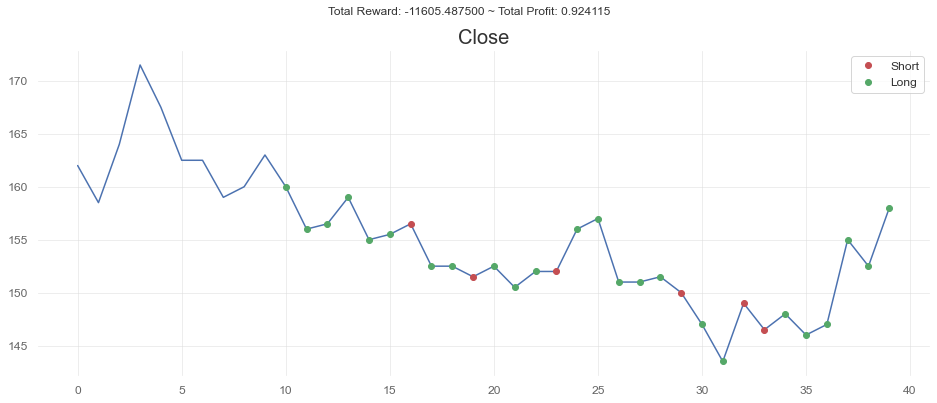

In [18]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


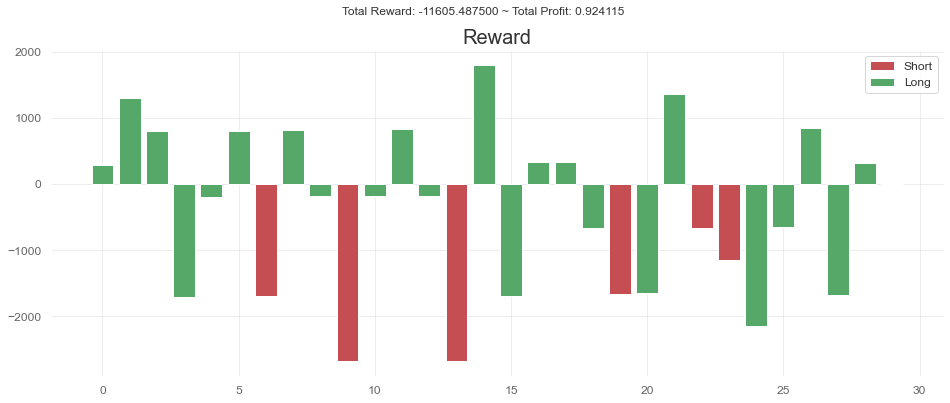

In [19]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


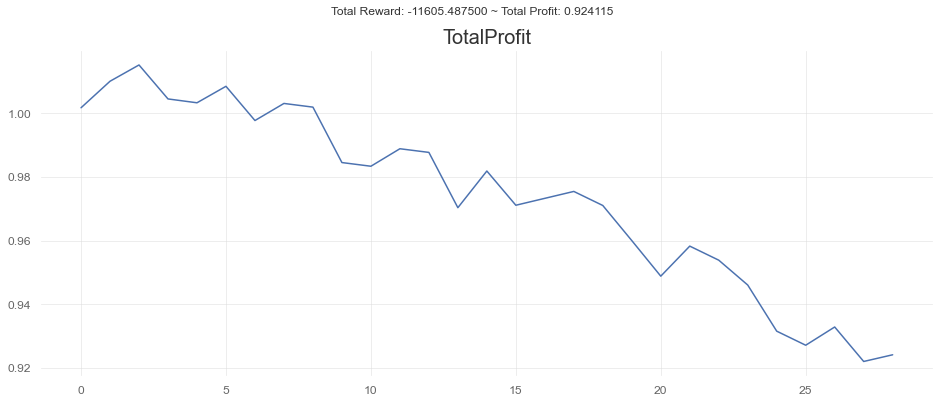

In [20]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [1]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)